In [1]:
'''
Demos written and developed by: Andrew E. Oriani 2020 EMAIL: oriani@uchicago.edu

'''
from PyInventor import *
import numpy as np
from numpy import pi, cos, sin, sqrt, log
import math
import glob
import time
import datetime

#Import plotting libraries for later
import matplotlib
from matplotlib import pyplot as plt

from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm 
from matplotlib.ticker import MaxNLocator

import pandas as pd

import pyEPR
from pyEPR import ansys as HFSS
from pyEPR.core_distributed_analysis import CalcObject

import scipy
from scipy import constants as const

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity
import os
import re as regex

# Field integrals code
import sys
sys.path.append('../python/src')
import field_integrals as fint

In [2]:
'''
Some code for frequency estimation
'''

class unique_element:
    def __init__(self,value,occurrences):
        self.value = value
        self.occurrences = occurrences
        
def perm_unique(elements):
    eset=set(elements)
    listunique = [unique_element(i,elements.count(i)) for i in eset]
    u=len(elements)
    return perm_unique_helper(listunique,[0]*u,u-1)

def perm_unique_helper(listunique,result_list,d):
    if d < 0:
        yield tuple(result_list)
    else:
        for i in listunique:
            if i.occurrences > 0:
                result_list[d]=i.value
                i.occurrences-=1
                for g in  perm_unique_helper(listunique,result_list,d-1):
                    yield g
                i.occurrences+=1

def TE_mode_sort(mode_num=1):
    '''
    This calculates allowable nml values for the TE modes of the resonator. Uses above functions
    '''
    
    permutes=[[1,0,1],[1,0,2],[1,0,3],[1,0,4],[1,0,5],[2,0,2],[2,0,3],[2,0,4],[2,0,5],[3,0,3],[3,0,4],[3,0,5]]
    nml=[]
    for i in range(len(permutes)):
        perms=np.array(list(perm_unique(permutes[i])))
        for vals in perms:
            if vals[0]!=0 and vals[1]==0 and vals[2]!=0:
                nml.append(list(vals))
            else:
                pass
    nml=np.array(nml)
    i_sort=np.argsort(nml[:,0])
    return nml[i_sort][0:mode_num]


def freq_rect(a,b,c, modes=1, unit='metric'):
    '''
    Calculate the lowest n-mode frequencies for a rectangular cavity of a,b,c dimensions where b is the smallest dim
    '''
    if unit=='metric':
        a=a/1000.
        b=b/1000.
        c=c/1000.
    elif unit=='imperial':
        a=a*.0254
        b=b*.0254
        c=c*.0254
    else:
        raise Exception('ERROR: Unit must be metric or imperial')
    
    eps=const.epsilon_0
    mu=const.mu_0
    c_speed=const.c
    nml_array=TE_mode_sort(10)
    f=[]

    for vals in nml_array:
        n=vals[0]
        m=vals[1]
        l=vals[2]
        f.append(((c_speed)/(2*pi))*sqrt((n*pi/a)**2+(m*pi/b)**2+(l*pi/c)**2))
    f=np.array(f)
    f_sort=np.argsort(f)
    return f[f_sort][0:modes], nml_array[f_sort]

def get_c_dim(f,a,b, unit='metric'):
    '''
    Estimates the second long dimension based on a target frequency and the other two dimensions. Works only for the 
    fundamental mode
    '''
    brentq=scipy.optimize.brentq
    f_intercept=lambda c:freq_rect(a,b,c,1, unit)[0][0]-f
    c=brentq(f_intercept, min([10*a, b]), max([10*a, b]))

    return c

def round_dim(dim, frac):
    val=frac*math.ceil(dim/frac)+frac
    if (val-dim)/2<frac:
        val=val+.25
    else:
        pass
    return val

def check_path(path):
    check=glob.glob(path)
    if check==[]:
        return False
    else:
        return True

def cap_sigma(cmat, units='fF'):
    cmat=Q(cmat, units).to('F').magnitude
    c11=abs(cmat[0,0])-abs(cmat[0,1])
    c22=abs(cmat[1,1])-abs(cmat[1,0])
    c12=abs(cmat[0,1])/2+abs(cmat[1,0])/2
    return (c12+(c11*c22)/(c11+c22))

def C_to_Ec(cmat, cap_units='fF'):
    csig=cap_sigma(cmat, cap_units)
    print (csig)
    return const.e**2/(2*(csig))/const.h

def C_to_Ec(cmat, cap_units='fF'):
    csig=cap_sigma(cmat, cap_units)
    return const.e**2/(2*(csig))/const.h

def Ec_to_C(Ec):
    Ec = Ec*const.h
    return const.e**2/(2*Ec)

def L_from_nu_and_C(nu,C):
    return (1/nu**2/4/np.pi**2/C)

In [3]:
'''
Some code for frequency estimation
'''

class unique_element:
    def __init__(self,value,occurrences):
        self.value = value
        self.occurrences = occurrences
        
def perm_unique(elements):
    eset=set(elements)
    listunique = [unique_element(i,elements.count(i)) for i in eset]
    u=len(elements)
    return perm_unique_helper(listunique,[0]*u,u-1)

def perm_unique_helper(listunique,result_list,d):
    if d < 0:
        yield tuple(result_list)
    else:
        for i in listunique:
            if i.occurrences > 0:
                result_list[d]=i.value
                i.occurrences-=1
                for g in  perm_unique_helper(listunique,result_list,d-1):
                    yield g
                i.occurrences+=1

def TE_mode_sort(mode_num=1):
    '''
    This calculates allowable nml values for the TE modes of the resonator. Uses above functions
    '''
    
    permutes=[[1,0,1],[1,0,2],[1,0,3],[1,0,4],[1,0,5],[2,0,2],[2,0,3],[2,0,4],[2,0,5],[3,0,3],[3,0,4],[3,0,5]]
    nml=[]
    for i in range(len(permutes)):
        perms=np.array(list(perm_unique(permutes[i])))
        for vals in perms:
            if vals[0]!=0 and vals[1]==0 and vals[2]!=0:
                nml.append(list(vals))
            else:
                pass
    nml=np.array(nml)
    i_sort=np.argsort(nml[:,0])
    return nml[i_sort][0:mode_num]


def freq_rect(a,b,c, modes=1, unit='metric'):
    '''
    Calculate the lowest n-mode frequencies for a rectangular cavity of a,b,c dimensions where b is the smallest dim
    '''
    if unit=='metric':
        a=a/1000.
        b=b/1000.
        c=c/1000.
    elif unit=='imperial':
        a=a*.0254
        b=b*.0254
        c=c*.0254
    else:
        raise Exception('ERROR: Unit must be metric or imperial')
    
    eps=const.epsilon_0
    mu=const.mu_0
    c_speed=const.c
    nml_array=TE_mode_sort(10)
    f=[]

    for vals in nml_array:
        n=vals[0]
        m=vals[1]
        l=vals[2]
        f.append(((c_speed)/(2*pi))*sqrt((n*pi/a)**2+(m*pi/b)**2+(l*pi/c)**2))
    f=np.array(f)
    f_sort=np.argsort(f)
    return f[f_sort][0:modes], nml_array[f_sort]

def get_c_dim(f,a,b, unit='metric'):
    '''
    Estimates the second long dimension based on a target frequency and the other two dimensions. Works only for the 
    fundamental mode
    '''
    brentq=scipy.optimize.brentq
    f_intercept=lambda c:freq_rect(a,b,c,1, unit)[0][0]-f
    c=brentq(f_intercept, min([10*a, b]), max([10*a, b]))

    return c

def round_dim(dim, frac):
    val=frac*math.ceil(dim/frac)+frac
    if (val-dim)/2<frac:
        val=val+.25
    else:
        pass
    return val

def check_path(path):
    check=glob.glob(path)
    if check==[]:
        return False
    else:
        return True

def cap_sigma(cmat, units='fF'):
    cmat=Q(cmat, units).to('F').magnitude
    c11=abs(cmat[0,0])-abs(cmat[0,1])
    c22=abs(cmat[1,1])-abs(cmat[1,0])
    c12=abs(cmat[0,1])/2+abs(cmat[1,0])/2
    return (c12+(c11*c22)/(c11+c22))

def C_to_Ec(cmat, cap_units='fF'):
    csig=cap_sigma(cmat, cap_units)
    print (csig)
    return const.e**2/(2*(csig))/const.h

def C_to_Ec(cmat, cap_units='fF'):
    csig=cap_sigma(cmat, cap_units)
    return const.e**2/(2*(csig))/const.h

def Ec_to_C(Ec):
    Ec = Ec*const.h
    return const.e**2/(2*Ec)

def L_from_nu_and_C(nu,C):
    return (1/nu**2/4/np.pi**2/C)

# PyInventor and cavity design:
The following shows a basic example of how to setup and compile an Inventor design using the PyInventor designs. To learn more about PyInventor and see various examples of how PyInventor can be used for cavity design please refer to: https://github.com/AndrewOriani/PyInventor and the tutorial and demo notebooks contained within.


In [4]:
def single_pan_pipe(target_freq, hole_spacing=0.2375,
                   hole_dia=0.1875, H_stock=2.25,
                    evan_length=0.5,
                   units='imperial',
                   fname='single_pan_pipe.ipt'):
    """
    Creates a single mode pan-pipe cavity with inventor
    """
    # Start at the origin
    stock_origin=(0,0)

    #calculate cavity height allowed by stock
    H_cav=H_stock-2*evan_length

    #calculate what you want the length of t he cavity to be for  the proper fundamental frequency
    L_cav=get_c_dim(target_freq, H_cav, hole_dia, units)

    #set the maximum number of holes, call them top
    num_holes_top=round((L_cav-hole_dia)/hole_spacing)+1

    #number of bottom holes
    num_holes_bot=num_holes_top-1

    #recalculate frequency now that holes are set
    eff_cav_L=(num_holes_top-1)*hole_spacing+hole_dia
    H_cav=get_c_dim(target_freq, eff_cav_L, hole_dia, units)

    # calculate stock length for the given cavity length needed
    # rounds length to nearest designated fraction
    L_stock=round_dim(L_cav, .25)
    W_stock=round_dim(hole_dia, .125)

    #start inventor and close all inventor objects
    com_obj().close_all_parts()

    #set it to overwrite file every time the part is instantiated (REMEMBER TO PUT SAVE AT THE BOTTOM!)
    overwrite=True

    # path='Z:\\Andrew Oriani\\CQED 3D Resonators\\Multimode Manipulate Cavity\\3D MM V3'

    #for demo set the path to path='' to save in current working directory
    path=os.getcwd() + '\\Inventor Files\\'

    #setup part 
    part=iPart(path=path, prefix=fname, units=units, overwrite=overwrite)

    #set view as shaded with edges
    part.set_visual_style(shaded=True, edges=True, hidden_edges=True)

    #set starting workplane
    lower_wp=part.add_workplane(plane='xy')

    #attach a sketch to the workplane
    sketch_1=part.new_sketch(lower_wp)

    #set upper workplane
    upper_wp=part.add_workplane(plane='xy', offset=H_stock)

    #attach a sketch to the upper workplane
    sketch_2=part.new_sketch(upper_wp)

    #create stock base associated with sketch 1. The structuire object keeps track of position
    stock_base=structure(part, sketch_1, start=stock_origin)

    stock_base.add_line(L_stock, 180)
    stock_base.add_line(W_stock, 90)
    stock_base.add_line(L_stock, 0)
    stock_base.add_line(W_stock, 270)

    #structure identifier
    base_shape=stock_base.draw_path(close_path=True)

    #extrude base shape. It is important to set the object collection (obj_collection) to the specific polygon shape we created
    base_extrusion=part.extrude(sketch_1, thickness=H_stock, obj_collection=base_shape, direction='positive', operation='join')

    #fits whole cavity in frame
    part.view.Fit()

    #hole starting coordinate
    hole_start=(-(L_stock-L_cav+hole_dia)/2, W_stock/2)

    #structure identifier
    cav_holes_top=structure(part, sketch_1, start=hole_start)
    cav_holes_bot=structure(part, sketch_2, start=(hole_start[0]-hole_spacing/2, hole_start[1]))

    #set total hole distance for top holes
    hole_dist_top=hole_spacing*(num_holes_top-1)
    hole_dist_bot=hole_spacing*(num_holes_bot-1)

    #start drawing points for top holes
    cav_holes_top.add_point_line(distance=hole_dist_top , direction=180, num_points=num_holes_top)   
    top_holes_pos=cav_holes_top.get_pts()[0]

    #create top holes by just putting in the list of positions. It will automatically make an object collection
    hole_depth=H_cav+evan_length
    part.new_hole(sketch=sketch_1, pos=top_holes_pos, dia=hole_dia, depth=hole_depth, direction='negative', FlatBottom=False, BottomTipAngle=None)

    #start drawing holes for bottom points
    cav_holes_bot.add_point_line(distance=hole_dist_bot , direction=180, num_points=num_holes_bot)   
    bot_holes_pos=cav_holes_bot.get_pts()[0]

    #create bottom holes
    part.new_hole(sketch=sketch_2, pos=bot_holes_pos, dia=hole_dia, depth=hole_depth, direction='positive', FlatBottom=False, BottomTipAngle=None)

    part.view.GoHome()

    #Save document 
    part.save()

    #save copy as stp file for export to HFSS
    path=part.save_copy_as(copy_name=fname.split('.')[0]+'.stp' );

    print('Estimated TE_101 mode frequency: %.3e'%target_freq)
    
    return L_stock, W_stock, H_stock, bot_holes_pos, top_holes_pos

# Eigenmode:

<img src="Pictures/Cavity Eigenmode.png" alt="drawing" width="400">

Determines first 5 eigenmode frequencies in absence of any qubit. This demonstration also calculates S_e and S_m (electric and magnetic field participation of the cavity modes) for the first (TE_101) mode.

In [6]:
'''
HFSS eigenmode simulation Creation:

This sets up a standard eigenmode simulation without the qubit, just the bare cavity created above. It calculates
the mode frequencies, loss (with boundary impedances set) and the electric and magnetic surface participation 
ratios (S_e, S_m)

'''
path = 'Z:\\tcav\\ipynbs\\Inventor Files\\'
project_name='Flute_Test_EM'
design_name='Pan_pipe_Test'

stp_exists = glob.glob(path+'flute_cavity_6p375_GHz.stp')
print(f'flute_cavity_6p375_GHz.stp exists: {stp_exists}')
stp_exists = glob.glob(path+'flute_cavity_7p375_GHz.stp')
print(f'flute_cavity_7p475_GHz.stp exists: {stp_exists}')

# Project and HFSS design names for the bare waveguide model
dd = datetime.datetime.today().strftime('%y%m%d')
solution_type = 'eigenmode'

# solution_type = 'driven_modal'
#dd = '230120'
#dd = '230121'
overwrite=True
yep = 'planar_pads_l_coupled_three_cavities_degen_eigen_hfss_design_230120'
ref_name = 'planar_pads_l_coupled_three_cavities_ndegen_eigen'
# ref_name = 'planar_pads_l_coupled_three_cavities_degen'
project_name=f'{ref_name}_{dd}'
design_name=f'{ref_name}_hfss_design_{dd}'
# design_name=f'{ref_name}_hfss_design_no_jj_230121'


#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\HFSS\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.save(full_path)
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        
        # Setup a driven modal design type
        if solution_type == 'driven_modal':
            EM_design=project.new_dm_design(design_name)
        elif solution_type == 'eigenmode':
            EM_design=project.new_em_design(design_name)
        else:
            raise ValueError(f'Solution type ({solution_type}) not recognized.')
    else:
        EM_design=project.get_design(design_name)
        
else:
    if solution_type == 'driven_modal':
        EM_design=project.new_dm_design(design_name)
    elif solution_type == 'eigenmode':
        EM_design=project.new_em_design(design_name)
    else:
        raise ValueError(f'Solution type ({solution_type}) not recognized.')
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        EM_design=project.new_em_design(design_name)
    else:
        EM_design=project.get_design(design_name)
        
else:
    EM_design=project.new_em_design(design_name)
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

flute_cavity_6p375_GHz.stp exists: ['Z:\\tcav\\ipynbs\\Inventor Files\\flute_cavity_6p375_GHz.stp']
flute_cavity_7p475_GHz.stp exists: ['Z:\\tcav\\ipynbs\\Inventor Files\\flute_cavity_7p375_GHz.stp']
project_name: planar_pads_l_coupled_three_cavities_ndegen_eigen_230725
path: Z:\tcav\ipynbs\HFSS\planar_pads_l_coupled_three_cavities_ndegen_eigen_230725.aedt


C:\Users\nmaterise\.conda\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:486: UserWarning: No project in path of name: planar_pads_l_coupled_three_cavities_ndegen_eigen_230725.aedt
  warnings.warn(f'No project in path of name: {path_split}')
C:\Users\nmaterise\.conda\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:487: UserWarning: Creating new project ...
  warnings.warn('Creating new project ...')


project_name: planar_pads_l_coupled_three_cavities_ndegen_eigen_230725
path: Z:\tcav\ipynbs\HFSS\planar_pads_l_coupled_three_cavities_ndegen_eigen_230725.aedt


In [7]:
if overwrite:
    # Two calls to pan-pipe design
    L_stock, W_stock, H_stock, bot_holes_pos, top_holes_pos \
    = single_pan_pipe(target_freq=6.375e9, fname='flute_cavity_6p375_GHz.ipt')
    L_stock2, W_stock2, H_stock2, bot_holes_pos2, top_holes_pos2 \
    = single_pan_pipe(target_freq=7.375e9, fname='flute_cavity_7p375_GHz.ipt')

    # Stock subtraction for cavity 1
    model.import_3D_obj(path+'flute_cavity_6p375_GHz.stp')
    Stock_L=EM_design.set_variable('Stock_L', '%.3fin'%(-L_stock))
    Stock_W=EM_design.set_variable('Stock_W', '%.3fin'%(W_stock))
    Stock_H=EM_design.set_variable('Stock_H', '%.3fin'%(H_stock))

    cav_dims=[Stock_L, Stock_W, Stock_H]

    box=model.draw_box_corner([0,0,0], cav_dims, name='cavity1')
    objs=model.get_object_names()
    obj_name=model.subtract(blank_name=objs[1], tool_names=[objs[0]])

    # Stock subtraction for cavity 2
    # model.import_3D_obj(path+'flute_cavity_6p575_GHz.stp')
    model.import_3D_obj(path+'flute_cavity_7p375_GHz.stp')
    Stock_L2=EM_design.set_variable('Stock_L2', '%.3fin'%(-L_stock2))
    Stock_W2=EM_design.set_variable('Stock_W2', '%.3fin'%(W_stock2))
    Stock_H2=EM_design.set_variable('Stock_H2', '%.3fin'%(H_stock2))

    cav_dims2=[Stock_L2, Stock_W2, Stock_H2]

    box2=model.draw_box_corner([0,0,0], cav_dims2, name='cavity2')
    obj_name2=model.subtract(blank_name='cavity2', tool_names=['Solid1_1'])

    # Cavity 1 impedance boundary conditions
    bot_hole_fid=[]
    for locs in bot_holes_pos:
        loc=['%.4fin'%locs[0], '%.4fin'%locs[1], Stock_H]
        fid=model.get_face_id_by_pos(obj_name, pos=loc)
        bot_hole_fid.append(fid)

    top_hole_fid=[]
    for locs in top_holes_pos:
        loc=['%.4fin'%locs[0], '%.4fin'%locs[1], '%.4fin'%0]
        fid=model.get_face_id_by_pos(obj_name, pos=loc)
        top_hole_fid.append(fid)

    top_imped=model.assign_impedance(377, 0, obj_name, 
                                     top_hole_fid, name='Top_Imped')
    bot_imped=model.assign_impedance(377, 0, obj_name,
                                     bot_hole_fid, name='Bot_Imped')

    # Cavity 2 impedance boundary conditions
    bot_hole_fid=[]
    for locs in bot_holes_pos2:
        loc=['%.4fin'%locs[0], '%.4fin'%locs[1], Stock_H]
        fid=model.get_face_id_by_pos(obj_name2, pos=loc)
        bot_hole_fid.append(fid)

    top_hole_fid=[]
    for locs in top_holes_pos2:
        loc=['%.4fin'%locs[0], '%.4fin'%locs[1], '%.4fin'%0]
        fid=model.get_face_id_by_pos(obj_name2, pos=loc)
        top_hole_fid.append(fid)

    top_imped=model.assign_impedance(377, 0, obj_name, 
                                     top_hole_fid, name='Top_Imped2')
    bot_imped=model.assign_impedance(377, 0, obj_name,
                                     bot_hole_fid, name='Bot_Imped2')

    # Move cavity #2 along a vector
    intomm = 25.4
    x_offset_mm = 10.
    xoffset = EM_design.set_variable('x_offset', f'{x_offset_mm:.3f}mm')
    xcorr = EM_design.set_variable('xoff_corr', '7.904534763mm')
    xchip_start = EM_design.set_variable('xchip_start', '42.82948mm')
    vec = [-(xoffset-xcorr)-xchip_start, #+offset_correction,
           0, 0]
    obj2_name = model.translate('cavity2', vec)

    # Chip setup
    cpl_width = EM_design.set_variable('cpl_width', f'{2.2:.3f}mm')
    l_chip = EM_design.set_variable('l_chip', '20mm')
    h_chip = EM_design.set_variable('h_chip', '5mm')
    t_chip = EM_design.set_variable('t_chip', '450um')
    chip_dims = [t_chip, l_chip+cpl_width, h_chip]

    # XXX: This is hard-coded, calculate this later
    xchip_start = EM_design.set_variable('xchip_start', '42.82948mm')
    chip_loc = [-xchip_start - xoffset/2,
                Stock_W/2 + l_chip / 2,
                Stock_H/2]

    # Edit sapphire material properties
    params = {'dielectric_loss_tangent' : 2e-8}
    project.edit_material(params, 'sapphire')
    chip = model.draw_box_center(chip_loc, chip_dims,
                                material='sapphire', name='chip')

    # Coupler cavity setup
    cpl_loc = [-xoffset/2 - xchip_start,
                Stock_W/2,
                Stock_H/2]
    cpl_dims = [1.5*xoffset, cpl_width, Stock_H/4]
    coupler = model.draw_box_center(cpl_loc, cpl_dims, name='coupler')

    # Subtractions and unions
    cavity_cpl = model.unite([obj_name, obj_name2, coupler])
    cavity_cpl = model.subtract(cavity_cpl, [chip], keep_originals=True)

Attempting to open Inventor with GetActiveObject ...
Attempting to open Inventor with Dispatch ...
Attempting to open Inventor with GetActiveObject ...
Attempting to open Inventor with Dispatch ...
File successfully copied as: Z:\tcav\ipynbs\Inventor Files\\00039_flute_cavity_6p375_GHz.stp
Estimated TE_101 mode frequency: 6.375e+09
Attempting to open Inventor with GetActiveObject ...
Attempting to open Inventor with Dispatch ...
Attempting to open Inventor with GetActiveObject ...
Attempting to open Inventor with Dispatch ...
File successfully copied as: Z:\tcav\ipynbs\Inventor Files\\00043_flute_cavity_7p375_GHz.stp
Estimated TE_101 mode frequency: 7.375e+09


## Pad & junction positions

In [8]:
# Junction and pads
# Planar pads
if overwrite:
    l_junc = EM_design.set_variable('l_junc', '50um')
    w_junc = EM_design.set_variable('w_junc', '10um')
    pad_w = 10 * w_junc
    pad_dims = [cpl_dims[1]/2 - l_junc/2, pad_w]

    pad1_loc = [-xchip_start - xoffset/2 - t_chip/2,
                Stock_W/2 - pad_dims[0]/2 - l_junc/2,
                Stock_H/2]
    pad2_loc = [-xchip_start - xoffset/2 - t_chip/2,
                Stock_W/2 + pad_dims[0]/2 + l_junc/2,
                Stock_H/2]

    # Pad geometry
    pad1 = model.draw_rect_center(pos=pad1_loc, x_size=0,
                              y_size=pad_dims[0],
                              z_size = pad_dims[1],
                              name='pad1')
    pad2 = model.draw_rect_center(pos=pad2_loc, x_size=0,
                              y_size=pad_dims[0],
                              z_size = pad_dims[1],
                              name='pad2')

    # Pad PEC assignment
    model.assign_perfect_E([pad1, pad2], name='junction_pads')

In [9]:
# Junction geometry, eigenmode
if overwrite:
    if solution_type == 'eigenmode':
        junc_loc = [-xchip_start - xoffset/2 - t_chip/2,
                    Stock_W/2,
                    Stock_H/2]
        jj=model.draw_rect_center(pos=junc_loc, x_size=0,
                                  y_size=l_junc,
                                  z_size = w_junc, name='jj')

        # Junction inductance assignment
        Lj_val = 0.1
        Cj = 94e-15; T1trans = 100e-6
        Rj_val = T1trans / Cj
        L_jj=EM_design.set_variable('Lj_1', '%.3fnH' % Lj_val)
        R_jj=EM_design.set_variable('Rj_1', '%.3fohm' % Rj_val)
        jj_line=model.draw_polyline(jj.make_center_line(axis='Y'), 
                                        closed=False, name='jj_line')
        jj.make_rlc_boundary(l=L_jj, r=R_jj, name='JJ_LJ', axis='Y')

        EM_setup=EM_design.create_em_setup(name='Test_EM', 
                                   min_freq_ghz=1., 
                                   n_modes=8, 
                                   max_delta_f=1.0, 
                                   min_converged=1, 
                                   converge_on_real=True)

# time.sleep(5)

In [ ]:
#setup the analysis and optimetrics
opti_setup = HFSS.Optimetrics(EM_design)

#set the optimetrics step size and number of steps
step = .2
num_step = 1

sweep_type = 'linear'

#create optimetrics setup
# swp_var = L_jj
# swp_var_unit = 'nH'
swp_var = xoffset
swp_var_unit = 'mm'
start = 1
stop = 15
dstep = 2
num_step = int(np.round((stop-start)/dstep) + 1)

tstamp = datetime.datetime.today().strftime('%y%m%d_%H_%M_%S')
if sweep_type == 'decade':
    opti_setup.create_setup(variable=swp_var,
                        swp_type= 'decade',
                        swp_params=('%.2f%s'%(start, swp_var_unit),
                                    '%.2f%s'%(stop, swp_var_unit), 
                                    str(num_step)),
                        name=f'{swp_var}_Sweep_{tstamp}',
                        save_fields=True,
                        solve_with_copied_mesh_only=False,
                        copy_mesh=False)
elif sweep_type == 'linear':
    opti_setup.create_setup(variable=swp_var,
                        swp_type= 'linear_step',
                        swp_params=('%.2f%s'%(start, swp_var_unit),
                                    '%.2f%s'%(stop, swp_var_unit), 
                                    '%.2f%s' \
                                    % (((stop - start) / num_step),
                                       swp_var_unit)),
                        name=f'{swp_var}_Sweep_{tstamp}',
                        save_fields=True,
                        solve_with_copied_mesh_only=False,
                        copy_mesh=False)
else:
    raise ValueError(f'sweep_type ({sweep_type}) unrecognized.')
            
#solve it
opti_setup.solve_setup(f'{swp_var}_Sweep_{tstamp}')

#save project
project.save()

In [6]:
def set_axes_fonts(ax, fsize):
    """
    Set axes font sizes because it should be abstracted away
    """
    for tick in ax.get_xticklabels():
        tick.set_fontsize(fsize)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(fsize)

def set_xaxis_rot(ax, angle=45):
    """
    Rotate the x-axis labels
    """
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

def set_leg_outside(ax, fsize):
    """
    Sets the legend location outside
    """
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    hdls, legs = ax.get_legend_handles_labels()
    leg = ax.legend(hdls, legs, loc='center left', bbox_to_anchor=(1, 0.5), \
                    fontsize=fsize, framealpha=0.)

    return leg

In [7]:
def plot_2d_cmap(x, y, z, fname,                                                
                 xstr='', ystr='',                                              
                 tstr='', cbar_str='',                                          
                 cmap=cm.inferno,
                 xyscales={'x' : 'linear', 'y': 'linear'},
                 interp_zeros=False,
                interp_std_dev=10,
                image_rot_angle=0,
                norm_type='linear',
                zref=None, 
                fsize=30,
                tsize=36):
    """                                                                         
    Plot 2D colormap data such that                                             
                                                                                
         -----------------------                                                
         |                     |                                                
         |                     |                                                
    y    |          z          |                                                
         |                     |                                                
         |                     |                                                
         -----------------------                                                
                                                                                
                    x                                                           
                                                                                
    Parameters:                                                                 
    ----------                                                                  
                                                                                
    x, y:       independent variables                                           
    z:          resulting data, z = z(x, y)                                     
    fname:      output figure filename, relative path with file extension       
    xstr:       x-axis label                                                    
    ystr:       y-axis label                                                    
    tstr:       title label                                                     
    cbar_str:   lable for color bar                                             
    cmap:       colormap to use on the 2D figure output                         
                                                                                
    """
    # Interpolate the data
    if interp_zeros:
        hot_pixels, z = fix_outlier_pixels(z, tolerance=interp_std_dev)
    
    # Setup the color map, normalizations, etc
    if norm_type == 'linear':
        norm = mpl.colors.Normalize(z.min(), z.max())
    elif norm_type == 'log':
        norm = mpl.colors.LogNorm(z.min(), z.max())
    elif (norm_type == 'ref') and zref:
        norm = mpl.colors.Normalize(min(zref), max(zref))
    else:
        raise ValueError(f'norm_type ({norm_type}) not recognized')                                         
                                                                                
    # Setup the figure and axes                                                 
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
    
    # Set the scale bar and levels
    if (norm_type == 'ref') and zref:
        levels = MaxNLocator(nbins=20).tick_values(min(zref), max(zref))
    else:
        levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())
    if image_rot_angle:
        z = scipy.ndimage.rotate(z, image_rot_angle, reshape=True)
    #plt1 = ax.imshow(z, cmap=cmap, norm=norm)
    plt1 = ax.pcolormesh(x, y, z, cmap=cmap, norm=norm)
    ax.set_xlabel(xstr, fontsize=fsize)                                         
    ax.set_ylabel(ystr, fontsize=fsize)                                         
    ax.set_title(tstr, fontsize=tsize)
    
    # Rotate the xlabels. Set both x and y labels to headers[1:]
    ax.set_xscale(xyscales['x'])
    ax.set_yscale(xyscales['y'])
    # set_xaxis_rot(ax, 45)
                                                                                
    # Set the axis tick labels to a reasonable size                             
    set_axes_fonts(ax, fsize)                                                   
                                                                                
    # Set the color bar, offset the title slightly from top                     
    cbar = fig.colorbar(plt1, ax=ax)                                            
    cbar.ax.set_title(cbar_str, fontsize=fsize, y=1.025)                        
    cbar.ax.tick_params(labelsize=fsize)                                        
                                                                                
    # Write the results to file
    print(f'Writing {fname} ...')
    fig.savefig(fname, format='pdf', transparent=True)                  

## Read the electric field data to perform the integrals

In [8]:
# Setup the pyEPR project
Nmodes = 6
pinfo = pyEPR.ProjectInfo(HFSS_path+'\\HFSS',  
                         project_name,
                         design_name)
# Setup for EPR anaylsis
eprh = pyEPR.DistributedAnalysis(pinfo)

# Read off the inductances and x-offsets from the variations
variations = eprh.solutions.list_variations()
Ljstrs = []; Lj_vals = []
#xoffstrs = []; xoff_vals = []
for v in variations:
    Ljstrs.append(regex.findall('Lj_1=\'(.*?nH)', v)[0].replace('.', 'p'))
    Lj_vals.append(float(regex.findall('Lj_1=\'(.*?)nH', v)[0]))
 #   xoffstrs.append(regex.findall('x_offset=\'(.*?mm)', v)[0].replace('.', 'p'))
 #   xoff_vals.append(regex.findall('x_offset=\'(.*?mm)', v)[0])

INFO 07:22PM [connect]: Connecting to Ansys Desktop API...
INFO 07:22PM [load_ansys_project]: 	File path to HFSS project found.
INFO 07:22PM [load_ansys_project]: 	Opened Ansys App
INFO 07:22PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 07:22PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    Z:/tcav/ipynbs/HFSS/
	Project:   planar_pads_l_coupled_three_cavities_degen_eigen_230120
INFO 07:22PM [connect]: 	Opened active design
	Design:    planar_pads_l_coupled_three_cavities_degen_eigen_hfss_design_230120 [Solution type: Eigenmode]
INFO 07:22PM [get_setup]: 	Opened setup `Test_EM`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 07:22PM [connect]: 	Connection to Ansys established successfully. 😀 

ERROR 07:22PM [setup_data]: WARNING!   DESIGN FILENAME MAY BE TOO LONG! 


Design "planar_pads_l_coupled_three_cavities_degen_eigen_hfss_design_230120" info:
	# eigenmodes    6
	# variations    25


In [9]:
Lj_sort_idxs = np.argsort(Lj_vals)
Lj_vals = np.unique(np.asarray(Lj_vals)[Lj_sort_idxs])
Ljstrs = np.asarray(Ljstrs)[Lj_sort_idxs]

In [10]:
Lj_sort_idxs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24,  0], dtype=int64)

In [11]:
Lj_vals

array([  0.1       ,   0.13335214,   0.17782794,   0.23713737,
         0.31622777,   0.4216965 ,   0.56234133,   0.74989421,
         1.        ,   1.33352143,   1.77827941,   2.37137371,
         3.16227766,   4.21696503,   5.62341325,   7.49894209,
        10.        ,  13.33521432,  17.7827941 ,  23.71373706,
        31.6227766 ,  42.16965034,  56.23413252,  74.98942093,
       100.        ])

In [12]:
Ljstrs

array(['0p10000000000000001nH', '0p13335214321633199nH',
       '0p17782794100389199nH', '0p23713737056616499nH',
       '0p316227766016838nH', '0p421696503428582nH',
       '0p56234132519034896nH', '0p74989420933245599nH', '1nH',
       '1p33352143216332nH', '1p7782794100389201nH',
       '2p3713737056616599nH', '3p16227766016838nH',
       '4p2169650342858196nH', '5p6234132519034903nH',
       '7p498942093324561nH', '10nH', '13p335214321633201nH',
       '17p7827941003892nH', '23p713737056616601nH',
       '31p622776601683796nH', '42p169650342858198nH',
       '56p234132519034901nH', '74p989420933245597nH', '100nH'],
      dtype='<U21')

In [13]:
vstrs = [f'LJ{l}' for l in Ljstrs]

In [14]:
vstrs

['LJ0p10000000000000001nH',
 'LJ0p13335214321633199nH',
 'LJ0p17782794100389199nH',
 'LJ0p23713737056616499nH',
 'LJ0p316227766016838nH',
 'LJ0p421696503428582nH',
 'LJ0p56234132519034896nH',
 'LJ0p74989420933245599nH',
 'LJ1nH',
 'LJ1p33352143216332nH',
 'LJ1p7782794100389201nH',
 'LJ2p3713737056616599nH',
 'LJ3p16227766016838nH',
 'LJ4p2169650342858196nH',
 'LJ5p6234132519034903nH',
 'LJ7p498942093324561nH',
 'LJ10nH',
 'LJ13p335214321633201nH',
 'LJ17p7827941003892nH',
 'LJ23p713737056616601nH',
 'LJ31p622776601683796nH',
 'LJ42p169650342858198nH',
 'LJ56p234132519034901nH',
 'LJ74p989420933245597nH',
 'LJ100nH']

In [15]:
vars_sorted = np.asarray(eprh.variations)[Lj_sort_idxs]

In [16]:
[eprh._get_lv(v) for v in vars_sorted]

[['cpl_width:=',
  '2.2000000000000002mm',
  'h_chip:=',
  '5mm',
  'l_chip:=',
  '20mm',
  'l_junc:=',
  '50um',
  'Lj_1:=',
  '0.10000000000000001nH',
  'Rj_1:=',
  '1060000000ohm',
  'Stock_H:=',
  '2.25in',
  'Stock_H2:=',
  '2.25in',
  'Stock_L:=',
  '-2in',
  'Stock_L2:=',
  '-1.75in',
  'Stock_W:=',
  '0.625in',
  'Stock_W2:=',
  '0.625in',
  't_chip:=',
  '450um',
  'w_junc:=',
  '10um',
  'x_offset:=',
  '15mm',
  'xchip_start:=',
  '42.829479999999997mm',
  'xoff_corr:=',
  '7.9045347629999991mm'],
 ['cpl_width:=',
  '2.2000000000000002mm',
  'h_chip:=',
  '5mm',
  'l_chip:=',
  '20mm',
  'l_junc:=',
  '50um',
  'Lj_1:=',
  '0.13335214321633199nH',
  'Rj_1:=',
  '1060000000ohm',
  'Stock_H:=',
  '2.25in',
  'Stock_H2:=',
  '2.25in',
  'Stock_L:=',
  '-2in',
  'Stock_L2:=',
  '-1.75in',
  'Stock_W:=',
  '0.625in',
  'Stock_W2:=',
  '0.625in',
  't_chip:=',
  '450um',
  'w_junc:=',
  '10um',
  'x_offset:=',
  '15mm',
  'xchip_start:=',
  '42.829479999999997mm',
  'xoff_corr:=',

## Need to manually create Vector_E plot in GUI first
* TODO: Create a new field plot, then export the field data with ansys.py

In [17]:
# Build a string for each variation to label the output files
Nmodes = 4
for idx, v in enumerate(vars_sorted):
    # Set the variation
    eprh.set_variation(v)
    lv = eprh._get_lv(v)
    print(f'Variation: {vstrs[idx]}')
    for kp in range(Nmodes):
        # Set the solution to mode kp
        eprh.solutions.set_mode(kp+1)
        # time.sleep(0.5)
        print(f'Mode-{kp+1}')
        des = EM_design._design
        omod = des.GetModule('FieldsReporter')
        omod.ExportFieldPlot("Vector_E1", False, f"Z:\\tcav\\data\\efields_mode_remesh2_{kp+1}_{vstrs[idx]}.aedtplt")
print('Finished writing field data to file.')

Variation: LJ0p10000000000000001nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ0p13335214321633199nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ0p17782794100389199nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ0p23713737056616499nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ0p316227766016838nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ0p421696503428582nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ0p56234132519034896nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ0p74989420933245599nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ1nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ1p33352143216332nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ1p7782794100389201nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ2p3713737056616599nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ3p16227766016838nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ4p2169650342858196nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ5p6234132519034903nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ7p498942093324561nH
Mode-1
Mode-2
Mode-3
Mode-4
Variation: LJ10nH
Mode-1
M

## Call the field integral code

In [17]:
# Single point of entry inputs to class
Nmodes = 4
modes = np.linspace(1, Nmodes, Nmodes, dtype=int)
print(f'modes: {modes}')
# LJs = np.asarray([0.1, 1., 10., 100.])
# LJstrs = ['0p1', '1', '10']

# Instantiate the class object
data_path = f'../data'
myfields = fint.FieldIntegrals(Lj_vals, Ljstrs,
                               modes, data_path, debug=True,
                               has_updated_fields=True,
                               has_normalized_fields=False,
                               normalize_fields=True,
                               drop_max_field=1,
                               filename_format = f'efields_mode_remesh2_%d_LJ%s.aedtplt',
                               timeout_limit=30.)
abscissa, efields = myfields.load_fields(return_fields=True)
keys = list(efields.keys())

modes: [1 2 3 4]
load_fields(): 786.811 s


In [202]:
Akkp = myfields.overlap_matrix_points(fname=None, cidxs=[3, 4],
                                      drop_points=1,#'../data/Akkp_nondegenerate_flutes_{dd}.csv',
                                      return_matrix=True)

Running kkp1_1_LJLJp_0p10000000000000001nH_0p10000000000000001nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_0p13335214321633199nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_0p17782794100389199nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_0p23713737056616499nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_0p316227766016838nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_0p421696503428582nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_0p56234132519034896nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_0p74989420933245599nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_1nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_1p33352143216332nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_1p7782794100389201nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_2p3713737056616599nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_3p16227766016838nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_4p2169650342858196nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_5p6234132519034903nH .

Running kkp1_1_LJLJp_0p421696503428582nH_0p10000000000000001nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_0p13335214321633199nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_0p17782794100389199nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_0p23713737056616499nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_0p316227766016838nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_0p421696503428582nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_0p56234132519034896nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_0p74989420933245599nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_1nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_1p33352143216332nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_1p7782794100389201nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_2p3713737056616599nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_3p16227766016838nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_4p2169650342858196nH ...
Running kkp1_1_LJLJp_0p421696503428582nH_5p6234132519034903nH ...
Running kkp1_1_LJLJp_0p4216

Running kkp1_1_LJLJp_1p7782794100389201nH_1nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_1p33352143216332nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_1p7782794100389201nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_2p3713737056616599nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_3p16227766016838nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_4p2169650342858196nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_5p6234132519034903nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_7p498942093324561nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_10nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_13p335214321633201nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_17p7827941003892nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_23p713737056616601nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_31p622776601683796nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_42p169650342858198nH ...
Running kkp1_1_LJLJp_1p7782794100389201nH_56p234132519034901nH ...
Running kkp1_1_LJLJp_1p778279410038

Running kkp1_1_LJLJp_7p498942093324561nH_2p3713737056616599nH ...
Running kkp1_1_LJLJp_7p498942093324561nH_3p16227766016838nH ...
Running kkp1_1_LJLJp_7p498942093324561nH_4p2169650342858196nH ...
Running kkp1_1_LJLJp_7p498942093324561nH_5p6234132519034903nH ...
Running kkp1_1_LJLJp_7p498942093324561nH_7p498942093324561nH ...
Running kkp1_1_LJLJp_7p498942093324561nH_10nH ...
Running kkp1_1_LJLJp_7p498942093324561nH_13p335214321633201nH ...
Running kkp1_1_LJLJp_7p498942093324561nH_17p7827941003892nH ...
Running kkp1_1_LJLJp_7p498942093324561nH_23p713737056616601nH ...
Running kkp1_1_LJLJp_7p498942093324561nH_31p622776601683796nH ...
Running kkp1_1_LJLJp_7p498942093324561nH_42p169650342858198nH ...
Running kkp1_1_LJLJp_7p498942093324561nH_56p234132519034901nH ...
Running kkp1_1_LJLJp_7p498942093324561nH_74p989420933245597nH ...
Running kkp1_1_LJLJp_7p498942093324561nH_100nH ...
Running kkp1_1_LJLJp_10nH_0p10000000000000001nH ...
Running kkp1_1_LJLJp_10nH_0p13335214321633199nH ...
Running 

Running kkp1_1_LJLJp_31p622776601683796nH_31p622776601683796nH ...
Running kkp1_1_LJLJp_31p622776601683796nH_42p169650342858198nH ...
Running kkp1_1_LJLJp_31p622776601683796nH_56p234132519034901nH ...
Running kkp1_1_LJLJp_31p622776601683796nH_74p989420933245597nH ...
Running kkp1_1_LJLJp_31p622776601683796nH_100nH ...
Running kkp1_1_LJLJp_42p169650342858198nH_0p10000000000000001nH ...
Running kkp1_1_LJLJp_42p169650342858198nH_0p13335214321633199nH ...
Running kkp1_1_LJLJp_42p169650342858198nH_0p17782794100389199nH ...
Running kkp1_1_LJLJp_42p169650342858198nH_0p23713737056616499nH ...
Running kkp1_1_LJLJp_42p169650342858198nH_0p316227766016838nH ...
Running kkp1_1_LJLJp_42p169650342858198nH_0p421696503428582nH ...
Running kkp1_1_LJLJp_42p169650342858198nH_0p56234132519034896nH ...
Running kkp1_1_LJLJp_42p169650342858198nH_0p74989420933245599nH ...
Running kkp1_1_LJLJp_42p169650342858198nH_1nH ...
Running kkp1_1_LJLJp_42p169650342858198nH_1p33352143216332nH ...
Running kkp1_1_LJLJp_42p1

Running kkp1_2_LJLJp_0p13335214321633199nH_0p17782794100389199nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_0p23713737056616499nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_0p316227766016838nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_0p421696503428582nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_0p56234132519034896nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_0p74989420933245599nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_1nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_1p33352143216332nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_1p7782794100389201nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_2p3713737056616599nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_3p16227766016838nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_4p2169650342858196nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_5p6234132519034903nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_7p498942093324561nH ...
Running kkp1_2_LJLJp_0p13335214321633199nH_10nH ...
Running kkp1_2_L

Running kkp1_2_LJLJp_0p56234132519034896nH_0p23713737056616499nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_0p316227766016838nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_0p421696503428582nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_0p56234132519034896nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_0p74989420933245599nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_1nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_1p33352143216332nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_1p7782794100389201nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_2p3713737056616599nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_3p16227766016838nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_4p2169650342858196nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_5p6234132519034903nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_7p498942093324561nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_10nH ...
Running kkp1_2_LJLJp_0p56234132519034896nH_13p335214321633201nH ...
Running kkp1_2_LJ

Running kkp1_2_LJLJp_2p3713737056616599nH_2p3713737056616599nH ...
Running kkp1_2_LJLJp_2p3713737056616599nH_3p16227766016838nH ...
Running kkp1_2_LJLJp_2p3713737056616599nH_4p2169650342858196nH ...
Running kkp1_2_LJLJp_2p3713737056616599nH_5p6234132519034903nH ...
Running kkp1_2_LJLJp_2p3713737056616599nH_7p498942093324561nH ...
Running kkp1_2_LJLJp_2p3713737056616599nH_10nH ...
Running kkp1_2_LJLJp_2p3713737056616599nH_13p335214321633201nH ...
Running kkp1_2_LJLJp_2p3713737056616599nH_17p7827941003892nH ...
Running kkp1_2_LJLJp_2p3713737056616599nH_23p713737056616601nH ...
Running kkp1_2_LJLJp_2p3713737056616599nH_31p622776601683796nH ...
Running kkp1_2_LJLJp_2p3713737056616599nH_42p169650342858198nH ...
Running kkp1_2_LJLJp_2p3713737056616599nH_56p234132519034901nH ...
Running kkp1_2_LJLJp_2p3713737056616599nH_74p989420933245597nH ...
Running kkp1_2_LJLJp_2p3713737056616599nH_100nH ...
Running kkp1_2_LJLJp_3p16227766016838nH_0p10000000000000001nH ...
Running kkp1_2_LJLJp_3p162277660

Running kkp1_2_LJLJp_10nH_17p7827941003892nH ...
Running kkp1_2_LJLJp_10nH_23p713737056616601nH ...
Running kkp1_2_LJLJp_10nH_31p622776601683796nH ...
Running kkp1_2_LJLJp_10nH_42p169650342858198nH ...
Running kkp1_2_LJLJp_10nH_56p234132519034901nH ...
Running kkp1_2_LJLJp_10nH_74p989420933245597nH ...
Running kkp1_2_LJLJp_10nH_100nH ...
Running kkp1_2_LJLJp_13p335214321633201nH_0p10000000000000001nH ...
Running kkp1_2_LJLJp_13p335214321633201nH_0p13335214321633199nH ...
Running kkp1_2_LJLJp_13p335214321633201nH_0p17782794100389199nH ...
Running kkp1_2_LJLJp_13p335214321633201nH_0p23713737056616499nH ...
Running kkp1_2_LJLJp_13p335214321633201nH_0p316227766016838nH ...
Running kkp1_2_LJLJp_13p335214321633201nH_0p421696503428582nH ...
Running kkp1_2_LJLJp_13p335214321633201nH_0p56234132519034896nH ...
Running kkp1_2_LJLJp_13p335214321633201nH_0p74989420933245599nH ...
Running kkp1_2_LJLJp_13p335214321633201nH_1nH ...
Running kkp1_2_LJLJp_13p335214321633201nH_1p33352143216332nH ...
Runni

Running kkp1_2_LJLJp_42p169650342858198nH_56p234132519034901nH ...
Running kkp1_2_LJLJp_42p169650342858198nH_74p989420933245597nH ...
Running kkp1_2_LJLJp_42p169650342858198nH_100nH ...
Running kkp1_2_LJLJp_56p234132519034901nH_0p10000000000000001nH ...
Running kkp1_2_LJLJp_56p234132519034901nH_0p13335214321633199nH ...
Running kkp1_2_LJLJp_56p234132519034901nH_0p17782794100389199nH ...
Running kkp1_2_LJLJp_56p234132519034901nH_0p23713737056616499nH ...
Running kkp1_2_LJLJp_56p234132519034901nH_0p316227766016838nH ...
Running kkp1_2_LJLJp_56p234132519034901nH_0p421696503428582nH ...
Running kkp1_2_LJLJp_56p234132519034901nH_0p56234132519034896nH ...
Running kkp1_2_LJLJp_56p234132519034901nH_0p74989420933245599nH ...
Running kkp1_2_LJLJp_56p234132519034901nH_1nH ...
Running kkp1_2_LJLJp_56p234132519034901nH_1p33352143216332nH ...
Running kkp1_2_LJLJp_56p234132519034901nH_1p7782794100389201nH ...
Running kkp1_2_LJLJp_56p234132519034901nH_2p3713737056616599nH ...
Running kkp1_2_LJLJp_56p2

Running kkp1_3_LJLJp_0p17782794100389199nH_0p316227766016838nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_0p421696503428582nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_0p56234132519034896nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_0p74989420933245599nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_1nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_1p33352143216332nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_1p7782794100389201nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_2p3713737056616599nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_3p16227766016838nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_4p2169650342858196nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_5p6234132519034903nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_7p498942093324561nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_10nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_13p335214321633201nH ...
Running kkp1_3_LJLJp_0p17782794100389199nH_17p7827941003892nH ...
Running kkp1_3_LJLJp

Running kkp1_3_LJLJp_0p74989420933245599nH_0p421696503428582nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_0p56234132519034896nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_0p74989420933245599nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_1nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_1p33352143216332nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_1p7782794100389201nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_2p3713737056616599nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_3p16227766016838nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_4p2169650342858196nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_5p6234132519034903nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_7p498942093324561nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_10nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_13p335214321633201nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_17p7827941003892nH ...
Running kkp1_3_LJLJp_0p74989420933245599nH_23p713737056616601nH ...
Running kkp1_3_LJLJ

Running kkp1_3_LJLJp_3p16227766016838nH_5p6234132519034903nH ...
Running kkp1_3_LJLJp_3p16227766016838nH_7p498942093324561nH ...
Running kkp1_3_LJLJp_3p16227766016838nH_10nH ...
Running kkp1_3_LJLJp_3p16227766016838nH_13p335214321633201nH ...
Running kkp1_3_LJLJp_3p16227766016838nH_17p7827941003892nH ...
Running kkp1_3_LJLJp_3p16227766016838nH_23p713737056616601nH ...
Running kkp1_3_LJLJp_3p16227766016838nH_31p622776601683796nH ...
Running kkp1_3_LJLJp_3p16227766016838nH_42p169650342858198nH ...
Running kkp1_3_LJLJp_3p16227766016838nH_56p234132519034901nH ...
Running kkp1_3_LJLJp_3p16227766016838nH_74p989420933245597nH ...
Running kkp1_3_LJLJp_3p16227766016838nH_100nH ...
Running kkp1_3_LJLJp_4p2169650342858196nH_0p10000000000000001nH ...
Running kkp1_3_LJLJp_4p2169650342858196nH_0p13335214321633199nH ...
Running kkp1_3_LJLJp_4p2169650342858196nH_0p17782794100389199nH ...
Running kkp1_3_LJLJp_4p2169650342858196nH_0p23713737056616499nH ...
Running kkp1_3_LJLJp_4p2169650342858196nH_0p316

Running kkp1_3_LJLJp_13p335214321633201nH_74p989420933245597nH ...
Running kkp1_3_LJLJp_13p335214321633201nH_100nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_0p10000000000000001nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_0p13335214321633199nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_0p17782794100389199nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_0p23713737056616499nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_0p316227766016838nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_0p421696503428582nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_0p56234132519034896nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_0p74989420933245599nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_1nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_1p33352143216332nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_1p7782794100389201nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_2p3713737056616599nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_3p16227766016838nH ...
Running kkp1_3_LJLJp_17p7827941003892nH_4p21696503428

Running kkp1_3_LJLJp_74p989420933245597nH_0p13335214321633199nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_0p17782794100389199nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_0p23713737056616499nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_0p316227766016838nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_0p421696503428582nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_0p56234132519034896nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_0p74989420933245599nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_1nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_1p33352143216332nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_1p7782794100389201nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_2p3713737056616599nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_3p16227766016838nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_4p2169650342858196nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_5p6234132519034903nH ...
Running kkp1_3_LJLJp_74p989420933245597nH_7p498942093324561nH ...
Running kkp1_3

Running kkp1_4_LJLJp_0p23713737056616499nH_0p74989420933245599nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_1nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_1p33352143216332nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_1p7782794100389201nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_2p3713737056616599nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_3p16227766016838nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_4p2169650342858196nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_5p6234132519034903nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_7p498942093324561nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_10nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_13p335214321633201nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_17p7827941003892nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_23p713737056616601nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_31p622776601683796nH ...
Running kkp1_4_LJLJp_0p23713737056616499nH_42p169650342858198nH ...
Running kkp1_4_LJLJ

Running kkp1_4_LJLJp_1nH_2p3713737056616599nH ...
Running kkp1_4_LJLJp_1nH_3p16227766016838nH ...
Running kkp1_4_LJLJp_1nH_4p2169650342858196nH ...
Running kkp1_4_LJLJp_1nH_5p6234132519034903nH ...
Running kkp1_4_LJLJp_1nH_7p498942093324561nH ...
Running kkp1_4_LJLJp_1nH_10nH ...
Running kkp1_4_LJLJp_1nH_13p335214321633201nH ...
Running kkp1_4_LJLJp_1nH_17p7827941003892nH ...
Running kkp1_4_LJLJp_1nH_23p713737056616601nH ...
Running kkp1_4_LJLJp_1nH_31p622776601683796nH ...
Running kkp1_4_LJLJp_1nH_42p169650342858198nH ...
Running kkp1_4_LJLJp_1nH_56p234132519034901nH ...
Running kkp1_4_LJLJp_1nH_74p989420933245597nH ...
Running kkp1_4_LJLJp_1nH_100nH ...
Running kkp1_4_LJLJp_1p33352143216332nH_0p10000000000000001nH ...
Running kkp1_4_LJLJp_1p33352143216332nH_0p13335214321633199nH ...
Running kkp1_4_LJLJp_1p33352143216332nH_0p17782794100389199nH ...
Running kkp1_4_LJLJp_1p33352143216332nH_0p23713737056616499nH ...
Running kkp1_4_LJLJp_1p33352143216332nH_0p316227766016838nH ...
Running 

Running kkp1_4_LJLJp_4p2169650342858196nH_17p7827941003892nH ...
Running kkp1_4_LJLJp_4p2169650342858196nH_23p713737056616601nH ...
Running kkp1_4_LJLJp_4p2169650342858196nH_31p622776601683796nH ...
Running kkp1_4_LJLJp_4p2169650342858196nH_42p169650342858198nH ...
Running kkp1_4_LJLJp_4p2169650342858196nH_56p234132519034901nH ...
Running kkp1_4_LJLJp_4p2169650342858196nH_74p989420933245597nH ...
Running kkp1_4_LJLJp_4p2169650342858196nH_100nH ...
Running kkp1_4_LJLJp_5p6234132519034903nH_0p10000000000000001nH ...
Running kkp1_4_LJLJp_5p6234132519034903nH_0p13335214321633199nH ...
Running kkp1_4_LJLJp_5p6234132519034903nH_0p17782794100389199nH ...
Running kkp1_4_LJLJp_5p6234132519034903nH_0p23713737056616499nH ...
Running kkp1_4_LJLJp_5p6234132519034903nH_0p316227766016838nH ...
Running kkp1_4_LJLJp_5p6234132519034903nH_0p421696503428582nH ...
Running kkp1_4_LJLJp_5p6234132519034903nH_0p56234132519034896nH ...
Running kkp1_4_LJLJp_5p6234132519034903nH_0p74989420933245599nH ...
Running 

Running kkp1_4_LJLJp_23p713737056616601nH_0p17782794100389199nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_0p23713737056616499nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_0p316227766016838nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_0p421696503428582nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_0p56234132519034896nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_0p74989420933245599nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_1nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_1p33352143216332nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_1p7782794100389201nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_2p3713737056616599nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_3p16227766016838nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_4p2169650342858196nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_5p6234132519034903nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_7p498942093324561nH ...
Running kkp1_4_LJLJp_23p713737056616601nH_10nH ...
Running kkp1_4_LJLJp_23p7137370

Running kkp1_4_LJLJp_100nH_0p316227766016838nH ...
Running kkp1_4_LJLJp_100nH_0p421696503428582nH ...
Running kkp1_4_LJLJp_100nH_0p56234132519034896nH ...
Running kkp1_4_LJLJp_100nH_0p74989420933245599nH ...
Running kkp1_4_LJLJp_100nH_1nH ...
Running kkp1_4_LJLJp_100nH_1p33352143216332nH ...
Running kkp1_4_LJLJp_100nH_1p7782794100389201nH ...
Running kkp1_4_LJLJp_100nH_2p3713737056616599nH ...
Running kkp1_4_LJLJp_100nH_3p16227766016838nH ...
Running kkp1_4_LJLJp_100nH_4p2169650342858196nH ...
Running kkp1_4_LJLJp_100nH_5p6234132519034903nH ...
Running kkp1_4_LJLJp_100nH_7p498942093324561nH ...
Running kkp1_4_LJLJp_100nH_10nH ...
Running kkp1_4_LJLJp_100nH_13p335214321633201nH ...
Running kkp1_4_LJLJp_100nH_17p7827941003892nH ...
Running kkp1_4_LJLJp_100nH_23p713737056616601nH ...
Running kkp1_4_LJLJp_100nH_31p622776601683796nH ...
Running kkp1_4_LJLJp_100nH_42p169650342858198nH ...
Running kkp1_4_LJLJp_100nH_56p234132519034901nH ...
Running kkp1_4_LJLJp_100nH_74p989420933245597nH ...


Running kkp2_1_LJLJp_0p316227766016838nH_1p33352143216332nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_1p7782794100389201nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_2p3713737056616599nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_3p16227766016838nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_4p2169650342858196nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_5p6234132519034903nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_7p498942093324561nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_10nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_13p335214321633201nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_17p7827941003892nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_23p713737056616601nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_31p622776601683796nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_42p169650342858198nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_56p234132519034901nH ...
Running kkp2_1_LJLJp_0p316227766016838nH_74p989420933245597nH ...
Running kkp2_1_LJLJp_0p3162277660

Running kkp2_1_LJLJp_1p33352143216332nH_17p7827941003892nH ...
Running kkp2_1_LJLJp_1p33352143216332nH_23p713737056616601nH ...
Running kkp2_1_LJLJp_1p33352143216332nH_31p622776601683796nH ...
Running kkp2_1_LJLJp_1p33352143216332nH_42p169650342858198nH ...
Running kkp2_1_LJLJp_1p33352143216332nH_56p234132519034901nH ...
Running kkp2_1_LJLJp_1p33352143216332nH_74p989420933245597nH ...
Running kkp2_1_LJLJp_1p33352143216332nH_100nH ...
Running kkp2_1_LJLJp_1p7782794100389201nH_0p10000000000000001nH ...
Running kkp2_1_LJLJp_1p7782794100389201nH_0p13335214321633199nH ...
Running kkp2_1_LJLJp_1p7782794100389201nH_0p17782794100389199nH ...
Running kkp2_1_LJLJp_1p7782794100389201nH_0p23713737056616499nH ...
Running kkp2_1_LJLJp_1p7782794100389201nH_0p316227766016838nH ...
Running kkp2_1_LJLJp_1p7782794100389201nH_0p421696503428582nH ...
Running kkp2_1_LJLJp_1p7782794100389201nH_0p56234132519034896nH ...
Running kkp2_1_LJLJp_1p7782794100389201nH_0p74989420933245599nH ...
Running kkp2_1_LJLJp_1

Running kkp2_1_LJLJp_5p6234132519034903nH_42p169650342858198nH ...
Running kkp2_1_LJLJp_5p6234132519034903nH_56p234132519034901nH ...
Running kkp2_1_LJLJp_5p6234132519034903nH_74p989420933245597nH ...
Running kkp2_1_LJLJp_5p6234132519034903nH_100nH ...
Running kkp2_1_LJLJp_7p498942093324561nH_0p10000000000000001nH ...
Running kkp2_1_LJLJp_7p498942093324561nH_0p13335214321633199nH ...
Running kkp2_1_LJLJp_7p498942093324561nH_0p17782794100389199nH ...
Running kkp2_1_LJLJp_7p498942093324561nH_0p23713737056616499nH ...
Running kkp2_1_LJLJp_7p498942093324561nH_0p316227766016838nH ...
Running kkp2_1_LJLJp_7p498942093324561nH_0p421696503428582nH ...
Running kkp2_1_LJLJp_7p498942093324561nH_0p56234132519034896nH ...
Running kkp2_1_LJLJp_7p498942093324561nH_0p74989420933245599nH ...
Running kkp2_1_LJLJp_7p498942093324561nH_1nH ...
Running kkp2_1_LJLJp_7p498942093324561nH_1p33352143216332nH ...
Running kkp2_1_LJLJp_7p498942093324561nH_1p7782794100389201nH ...
Running kkp2_1_LJLJp_7p4989420933245

Running kkp2_1_LJLJp_31p622776601683796nH_0p421696503428582nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_0p56234132519034896nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_0p74989420933245599nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_1nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_1p33352143216332nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_1p7782794100389201nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_2p3713737056616599nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_3p16227766016838nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_4p2169650342858196nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_5p6234132519034903nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_7p498942093324561nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_10nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_13p335214321633201nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_17p7827941003892nH ...
Running kkp2_1_LJLJp_31p622776601683796nH_23p713737056616601nH ...
Running kkp2_1_LJLJp_31p6227766016

Running kkp2_2_LJLJp_0p10000000000000001nH_3p16227766016838nH ...
Running kkp2_2_LJLJp_0p10000000000000001nH_4p2169650342858196nH ...
Running kkp2_2_LJLJp_0p10000000000000001nH_5p6234132519034903nH ...
Running kkp2_2_LJLJp_0p10000000000000001nH_7p498942093324561nH ...
Running kkp2_2_LJLJp_0p10000000000000001nH_10nH ...
Running kkp2_2_LJLJp_0p10000000000000001nH_13p335214321633201nH ...
Running kkp2_2_LJLJp_0p10000000000000001nH_17p7827941003892nH ...
Running kkp2_2_LJLJp_0p10000000000000001nH_23p713737056616601nH ...
Running kkp2_2_LJLJp_0p10000000000000001nH_31p622776601683796nH ...
Running kkp2_2_LJLJp_0p10000000000000001nH_42p169650342858198nH ...
Running kkp2_2_LJLJp_0p10000000000000001nH_56p234132519034901nH ...
Running kkp2_2_LJLJp_0p10000000000000001nH_74p989420933245597nH ...
Running kkp2_2_LJLJp_0p10000000000000001nH_100nH ...
Running kkp2_2_LJLJp_0p13335214321633199nH_0p10000000000000001nH ...
Running kkp2_2_LJLJp_0p13335214321633199nH_0p13335214321633199nH ...
Running kkp2_2

Running kkp2_2_LJLJp_0p421696503428582nH_4p2169650342858196nH ...
Running kkp2_2_LJLJp_0p421696503428582nH_5p6234132519034903nH ...
Running kkp2_2_LJLJp_0p421696503428582nH_7p498942093324561nH ...
Running kkp2_2_LJLJp_0p421696503428582nH_10nH ...
Running kkp2_2_LJLJp_0p421696503428582nH_13p335214321633201nH ...
Running kkp2_2_LJLJp_0p421696503428582nH_17p7827941003892nH ...
Running kkp2_2_LJLJp_0p421696503428582nH_23p713737056616601nH ...
Running kkp2_2_LJLJp_0p421696503428582nH_31p622776601683796nH ...
Running kkp2_2_LJLJp_0p421696503428582nH_42p169650342858198nH ...
Running kkp2_2_LJLJp_0p421696503428582nH_56p234132519034901nH ...
Running kkp2_2_LJLJp_0p421696503428582nH_74p989420933245597nH ...
Running kkp2_2_LJLJp_0p421696503428582nH_100nH ...
Running kkp2_2_LJLJp_0p56234132519034896nH_0p10000000000000001nH ...
Running kkp2_2_LJLJp_0p56234132519034896nH_0p13335214321633199nH ...
Running kkp2_2_LJLJp_0p56234132519034896nH_0p17782794100389199nH ...
Running kkp2_2_LJLJp_0p562341325190

Running kkp2_2_LJLJp_1p7782794100389201nH_42p169650342858198nH ...
Running kkp2_2_LJLJp_1p7782794100389201nH_56p234132519034901nH ...
Running kkp2_2_LJLJp_1p7782794100389201nH_74p989420933245597nH ...
Running kkp2_2_LJLJp_1p7782794100389201nH_100nH ...
Running kkp2_2_LJLJp_2p3713737056616599nH_0p10000000000000001nH ...
Running kkp2_2_LJLJp_2p3713737056616599nH_0p13335214321633199nH ...
Running kkp2_2_LJLJp_2p3713737056616599nH_0p17782794100389199nH ...
Running kkp2_2_LJLJp_2p3713737056616599nH_0p23713737056616499nH ...
Running kkp2_2_LJLJp_2p3713737056616599nH_0p316227766016838nH ...
Running kkp2_2_LJLJp_2p3713737056616599nH_0p421696503428582nH ...
Running kkp2_2_LJLJp_2p3713737056616599nH_0p56234132519034896nH ...
Running kkp2_2_LJLJp_2p3713737056616599nH_0p74989420933245599nH ...
Running kkp2_2_LJLJp_2p3713737056616599nH_1nH ...
Running kkp2_2_LJLJp_2p3713737056616599nH_1p33352143216332nH ...
Running kkp2_2_LJLJp_2p3713737056616599nH_1p7782794100389201nH ...
Running kkp2_2_LJLJp_2p37

Running kkp2_2_LJLJp_7p498942093324561nH_100nH ...
Running kkp2_2_LJLJp_10nH_0p10000000000000001nH ...
Running kkp2_2_LJLJp_10nH_0p13335214321633199nH ...
Running kkp2_2_LJLJp_10nH_0p17782794100389199nH ...
Running kkp2_2_LJLJp_10nH_0p23713737056616499nH ...
Running kkp2_2_LJLJp_10nH_0p316227766016838nH ...
Running kkp2_2_LJLJp_10nH_0p421696503428582nH ...
Running kkp2_2_LJLJp_10nH_0p56234132519034896nH ...
Running kkp2_2_LJLJp_10nH_0p74989420933245599nH ...
Running kkp2_2_LJLJp_10nH_1nH ...
Running kkp2_2_LJLJp_10nH_1p33352143216332nH ...
Running kkp2_2_LJLJp_10nH_1p7782794100389201nH ...
Running kkp2_2_LJLJp_10nH_2p3713737056616599nH ...
Running kkp2_2_LJLJp_10nH_3p16227766016838nH ...
Running kkp2_2_LJLJp_10nH_4p2169650342858196nH ...
Running kkp2_2_LJLJp_10nH_5p6234132519034903nH ...
Running kkp2_2_LJLJp_10nH_7p498942093324561nH ...
Running kkp2_2_LJLJp_10nH_10nH ...
Running kkp2_2_LJLJp_10nH_13p335214321633201nH ...
Running kkp2_2_LJLJp_10nH_17p7827941003892nH ...
Running kkp2_2_L

Running kkp2_2_LJLJp_42p169650342858198nH_0p74989420933245599nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_1nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_1p33352143216332nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_1p7782794100389201nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_2p3713737056616599nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_3p16227766016838nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_4p2169650342858196nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_5p6234132519034903nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_7p498942093324561nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_10nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_13p335214321633201nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_17p7827941003892nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_23p713737056616601nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_31p622776601683796nH ...
Running kkp2_2_LJLJp_42p169650342858198nH_42p169650342858198nH ...
Running kkp2_2_LJLJp_42p1696503428

Running kkp2_3_LJLJp_0p13335214321633199nH_5p6234132519034903nH ...
Running kkp2_3_LJLJp_0p13335214321633199nH_7p498942093324561nH ...
Running kkp2_3_LJLJp_0p13335214321633199nH_10nH ...
Running kkp2_3_LJLJp_0p13335214321633199nH_13p335214321633201nH ...
Running kkp2_3_LJLJp_0p13335214321633199nH_17p7827941003892nH ...
Running kkp2_3_LJLJp_0p13335214321633199nH_23p713737056616601nH ...
Running kkp2_3_LJLJp_0p13335214321633199nH_31p622776601683796nH ...
Running kkp2_3_LJLJp_0p13335214321633199nH_42p169650342858198nH ...
Running kkp2_3_LJLJp_0p13335214321633199nH_56p234132519034901nH ...
Running kkp2_3_LJLJp_0p13335214321633199nH_74p989420933245597nH ...
Running kkp2_3_LJLJp_0p13335214321633199nH_100nH ...
Running kkp2_3_LJLJp_0p17782794100389199nH_0p10000000000000001nH ...
Running kkp2_3_LJLJp_0p17782794100389199nH_0p13335214321633199nH ...
Running kkp2_3_LJLJp_0p17782794100389199nH_0p17782794100389199nH ...
Running kkp2_3_LJLJp_0p17782794100389199nH_0p23713737056616499nH ...
Running kk

Running kkp2_3_LJLJp_0p56234132519034896nH_7p498942093324561nH ...
Running kkp2_3_LJLJp_0p56234132519034896nH_10nH ...
Running kkp2_3_LJLJp_0p56234132519034896nH_13p335214321633201nH ...
Running kkp2_3_LJLJp_0p56234132519034896nH_17p7827941003892nH ...
Running kkp2_3_LJLJp_0p56234132519034896nH_23p713737056616601nH ...
Running kkp2_3_LJLJp_0p56234132519034896nH_31p622776601683796nH ...
Running kkp2_3_LJLJp_0p56234132519034896nH_42p169650342858198nH ...
Running kkp2_3_LJLJp_0p56234132519034896nH_56p234132519034901nH ...
Running kkp2_3_LJLJp_0p56234132519034896nH_74p989420933245597nH ...
Running kkp2_3_LJLJp_0p56234132519034896nH_100nH ...
Running kkp2_3_LJLJp_0p74989420933245599nH_0p10000000000000001nH ...
Running kkp2_3_LJLJp_0p74989420933245599nH_0p13335214321633199nH ...
Running kkp2_3_LJLJp_0p74989420933245599nH_0p17782794100389199nH ...
Running kkp2_3_LJLJp_0p74989420933245599nH_0p23713737056616499nH ...
Running kkp2_3_LJLJp_0p74989420933245599nH_0p316227766016838nH ...
Running kkp

Running kkp2_3_LJLJp_2p3713737056616599nH_74p989420933245597nH ...
Running kkp2_3_LJLJp_2p3713737056616599nH_100nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_0p10000000000000001nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_0p13335214321633199nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_0p17782794100389199nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_0p23713737056616499nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_0p316227766016838nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_0p421696503428582nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_0p56234132519034896nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_0p74989420933245599nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_1nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_1p33352143216332nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_1p7782794100389201nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_2p3713737056616599nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_3p16227766016838nH ...
Running kkp2_3_LJLJp_3p16227766016838nH_4p21696503428

Running kkp2_3_LJLJp_13p335214321633201nH_0p74989420933245599nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_1nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_1p33352143216332nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_1p7782794100389201nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_2p3713737056616599nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_3p16227766016838nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_4p2169650342858196nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_5p6234132519034903nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_7p498942093324561nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_10nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_13p335214321633201nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_17p7827941003892nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_23p713737056616601nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_31p622776601683796nH ...
Running kkp2_3_LJLJp_13p335214321633201nH_42p169650342858198nH ...
Running kkp2_3_LJLJp_13p3352143216

Running kkp2_3_LJLJp_56p234132519034901nH_1p7782794100389201nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_2p3713737056616599nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_3p16227766016838nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_4p2169650342858196nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_5p6234132519034903nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_7p498942093324561nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_10nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_13p335214321633201nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_17p7827941003892nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_23p713737056616601nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_31p622776601683796nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_42p169650342858198nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_56p234132519034901nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_74p989420933245597nH ...
Running kkp2_3_LJLJp_56p234132519034901nH_100nH ...
Running kkp2_3_LJLJp_74p9894209

Running kkp2_4_LJLJp_0p17782794100389199nH_10nH ...
Running kkp2_4_LJLJp_0p17782794100389199nH_13p335214321633201nH ...
Running kkp2_4_LJLJp_0p17782794100389199nH_17p7827941003892nH ...
Running kkp2_4_LJLJp_0p17782794100389199nH_23p713737056616601nH ...
Running kkp2_4_LJLJp_0p17782794100389199nH_31p622776601683796nH ...
Running kkp2_4_LJLJp_0p17782794100389199nH_42p169650342858198nH ...
Running kkp2_4_LJLJp_0p17782794100389199nH_56p234132519034901nH ...
Running kkp2_4_LJLJp_0p17782794100389199nH_74p989420933245597nH ...
Running kkp2_4_LJLJp_0p17782794100389199nH_100nH ...
Running kkp2_4_LJLJp_0p23713737056616499nH_0p10000000000000001nH ...
Running kkp2_4_LJLJp_0p23713737056616499nH_0p13335214321633199nH ...
Running kkp2_4_LJLJp_0p23713737056616499nH_0p17782794100389199nH ...
Running kkp2_4_LJLJp_0p23713737056616499nH_0p23713737056616499nH ...
Running kkp2_4_LJLJp_0p23713737056616499nH_0p316227766016838nH ...
Running kkp2_4_LJLJp_0p23713737056616499nH_0p421696503428582nH ...
Running kkp

Running kkp2_4_LJLJp_0p74989420933245599nH_13p335214321633201nH ...
Running kkp2_4_LJLJp_0p74989420933245599nH_17p7827941003892nH ...
Running kkp2_4_LJLJp_0p74989420933245599nH_23p713737056616601nH ...
Running kkp2_4_LJLJp_0p74989420933245599nH_31p622776601683796nH ...
Running kkp2_4_LJLJp_0p74989420933245599nH_42p169650342858198nH ...
Running kkp2_4_LJLJp_0p74989420933245599nH_56p234132519034901nH ...
Running kkp2_4_LJLJp_0p74989420933245599nH_74p989420933245597nH ...
Running kkp2_4_LJLJp_0p74989420933245599nH_100nH ...
Running kkp2_4_LJLJp_1nH_0p10000000000000001nH ...
Running kkp2_4_LJLJp_1nH_0p13335214321633199nH ...
Running kkp2_4_LJLJp_1nH_0p17782794100389199nH ...
Running kkp2_4_LJLJp_1nH_0p23713737056616499nH ...
Running kkp2_4_LJLJp_1nH_0p316227766016838nH ...
Running kkp2_4_LJLJp_1nH_0p421696503428582nH ...
Running kkp2_4_LJLJp_1nH_0p56234132519034896nH ...
Running kkp2_4_LJLJp_1nH_0p74989420933245599nH ...
Running kkp2_4_LJLJp_1nH_1nH ...
Running kkp2_4_LJLJp_1nH_1p333521432

Running kkp2_4_LJLJp_4p2169650342858196nH_0p17782794100389199nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_0p23713737056616499nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_0p316227766016838nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_0p421696503428582nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_0p56234132519034896nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_0p74989420933245599nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_1nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_1p33352143216332nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_1p7782794100389201nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_2p3713737056616599nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_3p16227766016838nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_4p2169650342858196nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_5p6234132519034903nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_7p498942093324561nH ...
Running kkp2_4_LJLJp_4p2169650342858196nH_10nH ...
Running kkp2_4_LJLJp_4p21696503

Running kkp2_4_LJLJp_17p7827941003892nH_1p7782794100389201nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_2p3713737056616599nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_3p16227766016838nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_4p2169650342858196nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_5p6234132519034903nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_7p498942093324561nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_10nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_13p335214321633201nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_17p7827941003892nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_23p713737056616601nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_31p622776601683796nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_42p169650342858198nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_56p234132519034901nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_74p989420933245597nH ...
Running kkp2_4_LJLJp_17p7827941003892nH_100nH ...
Running kkp2_4_LJLJp_23p713737056616601nH_0p10000000000000001

Running kkp2_4_LJLJp_74p989420933245597nH_3p16227766016838nH ...
Running kkp2_4_LJLJp_74p989420933245597nH_4p2169650342858196nH ...
Running kkp2_4_LJLJp_74p989420933245597nH_5p6234132519034903nH ...
Running kkp2_4_LJLJp_74p989420933245597nH_7p498942093324561nH ...
Running kkp2_4_LJLJp_74p989420933245597nH_10nH ...
Running kkp2_4_LJLJp_74p989420933245597nH_13p335214321633201nH ...
Running kkp2_4_LJLJp_74p989420933245597nH_17p7827941003892nH ...
Running kkp2_4_LJLJp_74p989420933245597nH_23p713737056616601nH ...
Running kkp2_4_LJLJp_74p989420933245597nH_31p622776601683796nH ...
Running kkp2_4_LJLJp_74p989420933245597nH_42p169650342858198nH ...
Running kkp2_4_LJLJp_74p989420933245597nH_56p234132519034901nH ...
Running kkp2_4_LJLJp_74p989420933245597nH_74p989420933245597nH ...
Running kkp2_4_LJLJp_74p989420933245597nH_100nH ...
Running kkp2_4_LJLJp_100nH_0p10000000000000001nH ...
Running kkp2_4_LJLJp_100nH_0p13335214321633199nH ...
Running kkp2_4_LJLJp_100nH_0p17782794100389199nH ...
Runnin

Running kkp3_1_LJLJp_0p23713737056616499nH_17p7827941003892nH ...
Running kkp3_1_LJLJp_0p23713737056616499nH_23p713737056616601nH ...
Running kkp3_1_LJLJp_0p23713737056616499nH_31p622776601683796nH ...
Running kkp3_1_LJLJp_0p23713737056616499nH_42p169650342858198nH ...
Running kkp3_1_LJLJp_0p23713737056616499nH_56p234132519034901nH ...
Running kkp3_1_LJLJp_0p23713737056616499nH_74p989420933245597nH ...
Running kkp3_1_LJLJp_0p23713737056616499nH_100nH ...
Running kkp3_1_LJLJp_0p316227766016838nH_0p10000000000000001nH ...
Running kkp3_1_LJLJp_0p316227766016838nH_0p13335214321633199nH ...
Running kkp3_1_LJLJp_0p316227766016838nH_0p17782794100389199nH ...
Running kkp3_1_LJLJp_0p316227766016838nH_0p23713737056616499nH ...
Running kkp3_1_LJLJp_0p316227766016838nH_0p316227766016838nH ...
Running kkp3_1_LJLJp_0p316227766016838nH_0p421696503428582nH ...
Running kkp3_1_LJLJp_0p316227766016838nH_0p56234132519034896nH ...
Running kkp3_1_LJLJp_0p316227766016838nH_0p74989420933245599nH ...
Running k

Running kkp3_1_LJLJp_1p33352143216332nH_0p13335214321633199nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_0p17782794100389199nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_0p23713737056616499nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_0p316227766016838nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_0p421696503428582nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_0p56234132519034896nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_0p74989420933245599nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_1nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_1p33352143216332nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_1p7782794100389201nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_2p3713737056616599nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_3p16227766016838nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_4p2169650342858196nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_5p6234132519034903nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_7p498942093324561nH ...
Running kkp3_1_LJLJp_1p33352143216332nH_10nH

Running kkp3_1_LJLJp_5p6234132519034903nH_0p316227766016838nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_0p421696503428582nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_0p56234132519034896nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_0p74989420933245599nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_1nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_1p33352143216332nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_1p7782794100389201nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_2p3713737056616599nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_3p16227766016838nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_4p2169650342858196nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_5p6234132519034903nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_7p498942093324561nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_10nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_13p335214321633201nH ...
Running kkp3_1_LJLJp_5p6234132519034903nH_17p7827941003892nH ...
Running kkp3_1_LJLJp_5p623413251903

Running kkp3_1_LJLJp_23p713737056616601nH_4p2169650342858196nH ...
Running kkp3_1_LJLJp_23p713737056616601nH_5p6234132519034903nH ...
Running kkp3_1_LJLJp_23p713737056616601nH_7p498942093324561nH ...
Running kkp3_1_LJLJp_23p713737056616601nH_10nH ...
Running kkp3_1_LJLJp_23p713737056616601nH_13p335214321633201nH ...
Running kkp3_1_LJLJp_23p713737056616601nH_17p7827941003892nH ...
Running kkp3_1_LJLJp_23p713737056616601nH_23p713737056616601nH ...
Running kkp3_1_LJLJp_23p713737056616601nH_31p622776601683796nH ...
Running kkp3_1_LJLJp_23p713737056616601nH_42p169650342858198nH ...
Running kkp3_1_LJLJp_23p713737056616601nH_56p234132519034901nH ...
Running kkp3_1_LJLJp_23p713737056616601nH_74p989420933245597nH ...
Running kkp3_1_LJLJp_23p713737056616601nH_100nH ...
Running kkp3_1_LJLJp_31p622776601683796nH_0p10000000000000001nH ...
Running kkp3_1_LJLJp_31p622776601683796nH_0p13335214321633199nH ...
Running kkp3_1_LJLJp_31p622776601683796nH_0p17782794100389199nH ...
Running kkp3_1_LJLJp_31p62

Running kkp3_1_LJLJp_100nH_23p713737056616601nH ...
Running kkp3_1_LJLJp_100nH_31p622776601683796nH ...
Running kkp3_1_LJLJp_100nH_42p169650342858198nH ...
Running kkp3_1_LJLJp_100nH_56p234132519034901nH ...
Running kkp3_1_LJLJp_100nH_74p989420933245597nH ...
Running kkp3_1_LJLJp_100nH_100nH ...
Running kkp3_2_LJLJp_0p10000000000000001nH_0p10000000000000001nH ...
Running kkp3_2_LJLJp_0p10000000000000001nH_0p13335214321633199nH ...
Running kkp3_2_LJLJp_0p10000000000000001nH_0p17782794100389199nH ...
Running kkp3_2_LJLJp_0p10000000000000001nH_0p23713737056616499nH ...
Running kkp3_2_LJLJp_0p10000000000000001nH_0p316227766016838nH ...
Running kkp3_2_LJLJp_0p10000000000000001nH_0p421696503428582nH ...
Running kkp3_2_LJLJp_0p10000000000000001nH_0p56234132519034896nH ...
Running kkp3_2_LJLJp_0p10000000000000001nH_0p74989420933245599nH ...
Running kkp3_2_LJLJp_0p10000000000000001nH_1nH ...
Running kkp3_2_LJLJp_0p10000000000000001nH_1p33352143216332nH ...
Running kkp3_2_LJLJp_0p100000000000000

Running kkp3_2_LJLJp_0p316227766016838nH_42p169650342858198nH ...
Running kkp3_2_LJLJp_0p316227766016838nH_56p234132519034901nH ...
Running kkp3_2_LJLJp_0p316227766016838nH_74p989420933245597nH ...
Running kkp3_2_LJLJp_0p316227766016838nH_100nH ...
Running kkp3_2_LJLJp_0p421696503428582nH_0p10000000000000001nH ...
Running kkp3_2_LJLJp_0p421696503428582nH_0p13335214321633199nH ...
Running kkp3_2_LJLJp_0p421696503428582nH_0p17782794100389199nH ...
Running kkp3_2_LJLJp_0p421696503428582nH_0p23713737056616499nH ...
Running kkp3_2_LJLJp_0p421696503428582nH_0p316227766016838nH ...
Running kkp3_2_LJLJp_0p421696503428582nH_0p421696503428582nH ...
Running kkp3_2_LJLJp_0p421696503428582nH_0p56234132519034896nH ...
Running kkp3_2_LJLJp_0p421696503428582nH_0p74989420933245599nH ...
Running kkp3_2_LJLJp_0p421696503428582nH_1nH ...
Running kkp3_2_LJLJp_0p421696503428582nH_1p33352143216332nH ...
Running kkp3_2_LJLJp_0p421696503428582nH_1p7782794100389201nH ...
Running kkp3_2_LJLJp_0p421696503428582nH

Running kkp3_2_LJLJp_1p7782794100389201nH_0p421696503428582nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_0p56234132519034896nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_0p74989420933245599nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_1nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_1p33352143216332nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_1p7782794100389201nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_2p3713737056616599nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_3p16227766016838nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_4p2169650342858196nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_5p6234132519034903nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_7p498942093324561nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_10nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_13p335214321633201nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_17p7827941003892nH ...
Running kkp3_2_LJLJp_1p7782794100389201nH_23p713737056616601nH ...
Running kkp3_2_LJLJp_1p77827941003

Running kkp3_2_LJLJp_7p498942093324561nH_0p74989420933245599nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_1nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_1p33352143216332nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_1p7782794100389201nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_2p3713737056616599nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_3p16227766016838nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_4p2169650342858196nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_5p6234132519034903nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_7p498942093324561nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_10nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_13p335214321633201nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_17p7827941003892nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_23p713737056616601nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_31p622776601683796nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_42p169650342858198nH ...
Running kkp3_2_LJLJp_7p498942093324561nH_56p23413

Running kkp3_2_LJLJp_31p622776601683796nH_10nH ...
Running kkp3_2_LJLJp_31p622776601683796nH_13p335214321633201nH ...
Running kkp3_2_LJLJp_31p622776601683796nH_17p7827941003892nH ...
Running kkp3_2_LJLJp_31p622776601683796nH_23p713737056616601nH ...
Running kkp3_2_LJLJp_31p622776601683796nH_31p622776601683796nH ...
Running kkp3_2_LJLJp_31p622776601683796nH_42p169650342858198nH ...
Running kkp3_2_LJLJp_31p622776601683796nH_56p234132519034901nH ...
Running kkp3_2_LJLJp_31p622776601683796nH_74p989420933245597nH ...
Running kkp3_2_LJLJp_31p622776601683796nH_100nH ...
Running kkp3_2_LJLJp_42p169650342858198nH_0p10000000000000001nH ...
Running kkp3_2_LJLJp_42p169650342858198nH_0p13335214321633199nH ...
Running kkp3_2_LJLJp_42p169650342858198nH_0p17782794100389199nH ...
Running kkp3_2_LJLJp_42p169650342858198nH_0p23713737056616499nH ...
Running kkp3_2_LJLJp_42p169650342858198nH_0p316227766016838nH ...
Running kkp3_2_LJLJp_42p169650342858198nH_0p421696503428582nH ...
Running kkp3_2_LJLJp_42p16

Running kkp3_3_LJLJp_0p10000000000000001nH_74p989420933245597nH ...
Running kkp3_3_LJLJp_0p10000000000000001nH_100nH ...
Running kkp3_3_LJLJp_0p13335214321633199nH_0p10000000000000001nH ...
Running kkp3_3_LJLJp_0p13335214321633199nH_0p13335214321633199nH ...
Running kkp3_3_LJLJp_0p13335214321633199nH_0p17782794100389199nH ...
Running kkp3_3_LJLJp_0p13335214321633199nH_0p23713737056616499nH ...
Running kkp3_3_LJLJp_0p13335214321633199nH_0p316227766016838nH ...
Running kkp3_3_LJLJp_0p13335214321633199nH_0p421696503428582nH ...
Running kkp3_3_LJLJp_0p13335214321633199nH_0p56234132519034896nH ...
Running kkp3_3_LJLJp_0p13335214321633199nH_0p74989420933245599nH ...
Running kkp3_3_LJLJp_0p13335214321633199nH_1nH ...
Running kkp3_3_LJLJp_0p13335214321633199nH_1p33352143216332nH ...
Running kkp3_3_LJLJp_0p13335214321633199nH_1p7782794100389201nH ...
Running kkp3_3_LJLJp_0p13335214321633199nH_2p3713737056616599nH ...
Running kkp3_3_LJLJp_0p13335214321633199nH_3p16227766016838nH ...
Running kkp3

Running kkp3_3_LJLJp_0p421696503428582nH_100nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_0p10000000000000001nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_0p13335214321633199nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_0p17782794100389199nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_0p23713737056616499nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_0p316227766016838nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_0p421696503428582nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_0p56234132519034896nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_0p74989420933245599nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_1nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_1p33352143216332nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_1p7782794100389201nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_2p3713737056616599nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_3p16227766016838nH ...
Running kkp3_3_LJLJp_0p56234132519034896nH_4p2169650342858196nH ...
Running kkp3_3

Running kkp3_3_LJLJp_2p3713737056616599nH_0p74989420933245599nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_1nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_1p33352143216332nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_1p7782794100389201nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_2p3713737056616599nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_3p16227766016838nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_4p2169650342858196nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_5p6234132519034903nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_7p498942093324561nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_10nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_13p335214321633201nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_17p7827941003892nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_23p713737056616601nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_31p622776601683796nH ...
Running kkp3_3_LJLJp_2p3713737056616599nH_42p169650342858198nH ...
Running kkp3_3_LJLJp_2p37137370566

Running kkp3_3_LJLJp_10nH_4p2169650342858196nH ...
Running kkp3_3_LJLJp_10nH_5p6234132519034903nH ...
Running kkp3_3_LJLJp_10nH_7p498942093324561nH ...
Running kkp3_3_LJLJp_10nH_10nH ...
Running kkp3_3_LJLJp_10nH_13p335214321633201nH ...
Running kkp3_3_LJLJp_10nH_17p7827941003892nH ...
Running kkp3_3_LJLJp_10nH_23p713737056616601nH ...
Running kkp3_3_LJLJp_10nH_31p622776601683796nH ...
Running kkp3_3_LJLJp_10nH_42p169650342858198nH ...
Running kkp3_3_LJLJp_10nH_56p234132519034901nH ...
Running kkp3_3_LJLJp_10nH_74p989420933245597nH ...
Running kkp3_3_LJLJp_10nH_100nH ...
Running kkp3_3_LJLJp_13p335214321633201nH_0p10000000000000001nH ...
Running kkp3_3_LJLJp_13p335214321633201nH_0p13335214321633199nH ...
Running kkp3_3_LJLJp_13p335214321633201nH_0p17782794100389199nH ...
Running kkp3_3_LJLJp_13p335214321633201nH_0p23713737056616499nH ...
Running kkp3_3_LJLJp_13p335214321633201nH_0p316227766016838nH ...
Running kkp3_3_LJLJp_13p335214321633201nH_0p421696503428582nH ...
Running kkp3_3_LJL

Running kkp3_3_LJLJp_42p169650342858198nH_17p7827941003892nH ...
Running kkp3_3_LJLJp_42p169650342858198nH_23p713737056616601nH ...
Running kkp3_3_LJLJp_42p169650342858198nH_31p622776601683796nH ...
Running kkp3_3_LJLJp_42p169650342858198nH_42p169650342858198nH ...
Running kkp3_3_LJLJp_42p169650342858198nH_56p234132519034901nH ...
Running kkp3_3_LJLJp_42p169650342858198nH_74p989420933245597nH ...
Running kkp3_3_LJLJp_42p169650342858198nH_100nH ...
Running kkp3_3_LJLJp_56p234132519034901nH_0p10000000000000001nH ...
Running kkp3_3_LJLJp_56p234132519034901nH_0p13335214321633199nH ...
Running kkp3_3_LJLJp_56p234132519034901nH_0p17782794100389199nH ...
Running kkp3_3_LJLJp_56p234132519034901nH_0p23713737056616499nH ...
Running kkp3_3_LJLJp_56p234132519034901nH_0p316227766016838nH ...
Running kkp3_3_LJLJp_56p234132519034901nH_0p421696503428582nH ...
Running kkp3_3_LJLJp_56p234132519034901nH_0p56234132519034896nH ...
Running kkp3_3_LJLJp_56p234132519034901nH_0p74989420933245599nH ...
Running 

Dropping field at [8, 8117] ...
Dropping field at [6, 45452] ...
Running kkp3_4_LJLJp_0p10000000000000001nH_56p234132519034901nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 45452] ...
Running kkp3_4_LJLJp_0p10000000000000001nH_74p989420933245597nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 45452] ...
Running kkp3_4_LJLJp_0p10000000000000001nH_100nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 45452] ...
Running kkp3_4_LJLJp_0p13335214321633199nH_0p10000000000000001nH ...
Correcting [3, 4] ...
Dropping field at [1, 47990] ...
Dropping field at [8, 55411] ...
Running kkp3_4_LJLJp_0p13335214321633199nH_0p13335214321633199nH ...
Correcting [3, 4] ...
Dropping field at [8, 45449] ...
Dropping field at [1, 47990] ...
Running kkp3_4_LJLJp_0p13335214321633199nH_0p17782794100389199nH ...
Correcting [3, 4] ...
Dropping field at [8, 45449] ...
Dropping field at [1, 47990] ...
Running kkp3_4

Dropping field at [1, 47990] ...
Dropping field at [8, 55411] ...
Running kkp3_4_LJLJp_0p23713737056616499nH_0p13335214321633199nH ...
Correcting [3, 4] ...
Dropping field at [8, 45449] ...
Dropping field at [1, 47990] ...
Running kkp3_4_LJLJp_0p23713737056616499nH_0p17782794100389199nH ...
Correcting [3, 4] ...
Dropping field at [8, 45449] ...
Dropping field at [1, 47990] ...
Running kkp3_4_LJLJp_0p23713737056616499nH_0p23713737056616499nH ...
Correcting [3, 4] ...
Dropping field at [8, 45449] ...
Dropping field at [1, 47990] ...
Running kkp3_4_LJLJp_0p23713737056616499nH_0p316227766016838nH ...
Correcting [3, 4] ...
Dropping field at [8, 45449] ...
Dropping field at [1, 47990] ...
Running kkp3_4_LJLJp_0p23713737056616499nH_0p421696503428582nH ...
Correcting [3, 4] ...
Dropping field at [8, 45449] ...
Dropping field at [1, 47990] ...
Running kkp3_4_LJLJp_0p23713737056616499nH_0p56234132519034896nH ...
Correcting [3, 4] ...
Dropping field at [1, 47990] ...
Dropping field at [6, 49853] 

Dropping field at [8, 45449] ...
Running kkp3_4_LJLJp_0p421696503428582nH_0p421696503428582nH ...
Correcting [3, 4] ...
Dropping field at [7, 7175] ...
Dropping field at [8, 45449] ...
Running kkp3_4_LJLJp_0p421696503428582nH_0p56234132519034896nH ...
Correcting [3, 4] ...
Dropping field at [7, 7175] ...
Dropping field at [6, 49853] ...
Running kkp3_4_LJLJp_0p421696503428582nH_0p74989420933245599nH ...
Correcting [3, 4] ...
Dropping field at [7, 7175] ...
Dropping field at [6, 49853] ...
Running kkp3_4_LJLJp_0p421696503428582nH_1nH ...
Correcting [3, 4] ...
Dropping field at [7, 7175] ...
Dropping field at [6, 49853] ...
Running kkp3_4_LJLJp_0p421696503428582nH_1p33352143216332nH ...
Correcting [3, 4] ...
Dropping field at [7, 7175] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_0p421696503428582nH_1p7782794100389201nH ...
Correcting [3, 4] ...
Dropping field at [7, 7175] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_0p421696503428582nH_2p3713737056616599nH ...
C

Dropping field at [6, 49853] ...
Running kkp3_4_LJLJp_0p74989420933245599nH_1p33352143216332nH ...
Correcting [3, 4] ...
Dropping field at [7, 7175] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_0p74989420933245599nH_1p7782794100389201nH ...
Correcting [3, 4] ...
Dropping field at [7, 7175] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_0p74989420933245599nH_2p3713737056616599nH ...
Correcting [3, 4] ...
Dropping field at [7, 7175] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_0p74989420933245599nH_3p16227766016838nH ...
Correcting [3, 4] ...
Dropping field at [7, 7175] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_0p74989420933245599nH_4p2169650342858196nH ...
Correcting [3, 4] ...
Dropping field at [7, 7175] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_0p74989420933245599nH_5p6234132519034903nH ...
Correcting [3, 4] ...
Dropping field at [7, 7175] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_0p74989420933245599n

Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_1p33352143216332nH_23p713737056616601nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_1p33352143216332nH_31p622776601683796nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_1p33352143216332nH_42p169650342858198nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_1p33352143216332nH_56p234132519034901nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_1p33352143216332nH_74p989420933245597nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_1p33352143216332nH_100nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_1p7782794100389201nH_0p10000000000000001nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Dropping fi

Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_3p16227766016838nH_0p316227766016838nH ...
Correcting [3, 4] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_3p16227766016838nH_0p421696503428582nH ...
Correcting [3, 4] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_3p16227766016838nH_0p56234132519034896nH ...
Correcting [3, 4] ...
Dropping field at [6, 49853] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_3p16227766016838nH_0p74989420933245599nH ...
Correcting [3, 4] ...
Dropping field at [6, 49853] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_3p16227766016838nH_1nH ...
Correcting [3, 4] ...
Dropping field at [6, 49853] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_3p16227766016838nH_1p33352143216332nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_3p16227766016838nH_1p7782794100389201nH ...
Cor

Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_5p6234132519034903nH_5p6234132519034903nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_5p6234132519034903nH_7p498942093324561nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_5p6234132519034903nH_10nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_5p6234132519034903nH_13p335214321633201nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_5p6234132519034903nH_17p7827941003892nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_5p6234132519034903nH_23p713737056616601nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_5p6234132519034903nH_31p622776601683796nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_5p6234132519034903nH_42p169650342858198nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping fi

Running kkp3_4_LJLJp_13p335214321633201nH_0p17782794100389199nH ...
Correcting [3, 4] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_13p335214321633201nH_0p23713737056616499nH ...
Correcting [3, 4] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_13p335214321633201nH_0p316227766016838nH ...
Correcting [3, 4] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_13p335214321633201nH_0p421696503428582nH ...
Correcting [3, 4] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_13p335214321633201nH_0p56234132519034896nH ...
Correcting [3, 4] ...
Dropping field at [6, 49853] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_13p335214321633201nH_0p74989420933245599nH ...
Correcting [3, 4] ...
Dropping field at [6, 49853] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_13p335214321633201nH_1nH ...
Correcting [3, 4] 

Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_23p713737056616601nH_3p16227766016838nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_23p713737056616601nH_4p2169650342858196nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_23p713737056616601nH_5p6234132519034903nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_23p713737056616601nH_7p498942093324561nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_23p713737056616601nH_10nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_23p713737056616601nH_13p335214321633201nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_23p713737056616601nH_17p7827941003892nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_23p713737056616601nH_23p713737056616601nH ...
Correcting [3, 4] ...
Dropping field at [6, 50620] ...
Running kkp3

Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_42p169650342858198nH_74p989420933245597nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_42p169650342858198nH_100nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_56p234132519034901nH_0p10000000000000001nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [8, 55411] ...
Running kkp3_4_LJLJp_56p234132519034901nH_0p13335214321633199nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [8, 45449] ...
Running kkp3_4_LJLJp_56p234132519034901nH_0p17782794100389199nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [8, 45449] ...
Running kkp3_4_LJLJp_56p234132519034901nH_0p23713737056616499nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [8, 45449] ...
Running kkp3_4_LJLJp_5

Dropping field at [8, 45449] ...
Running kkp3_4_LJLJp_100nH_0p316227766016838nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [8, 45449] ...
Running kkp3_4_LJLJp_100nH_0p421696503428582nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [8, 45449] ...
Running kkp3_4_LJLJp_100nH_0p56234132519034896nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 49853] ...
Running kkp3_4_LJLJp_100nH_0p74989420933245599nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 49853] ...
Running kkp3_4_LJLJp_100nH_1nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 49853] ...
Running kkp3_4_LJLJp_100nH_1p33352143216332nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp3_4_LJLJp_100nH_1p7782794100389201nH ...
Correcting [3, 4] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp3_

Running kkp4_1_LJLJp_0p23713737056616499nH_1nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_1p33352143216332nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_1p7782794100389201nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_2p3713737056616599nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_3p16227766016838nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_4p2169650342858196nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_5p6234132519034903nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_7p498942093324561nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_10nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_13p335214321633201nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_17p7827941003892nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_23p713737056616601nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_31p622776601683796nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_42p169650342858198nH ...
Running kkp4_1_LJLJp_0p23713737056616499nH_56p234132519034901nH ...
Running kkp4_1_LJLJp

Running kkp4_1_LJLJp_1nH_4p2169650342858196nH ...
Running kkp4_1_LJLJp_1nH_5p6234132519034903nH ...
Running kkp4_1_LJLJp_1nH_7p498942093324561nH ...
Running kkp4_1_LJLJp_1nH_10nH ...
Running kkp4_1_LJLJp_1nH_13p335214321633201nH ...
Running kkp4_1_LJLJp_1nH_17p7827941003892nH ...
Running kkp4_1_LJLJp_1nH_23p713737056616601nH ...
Running kkp4_1_LJLJp_1nH_31p622776601683796nH ...
Running kkp4_1_LJLJp_1nH_42p169650342858198nH ...
Running kkp4_1_LJLJp_1nH_56p234132519034901nH ...
Running kkp4_1_LJLJp_1nH_74p989420933245597nH ...
Running kkp4_1_LJLJp_1nH_100nH ...
Running kkp4_1_LJLJp_1p33352143216332nH_0p10000000000000001nH ...
Running kkp4_1_LJLJp_1p33352143216332nH_0p13335214321633199nH ...
Running kkp4_1_LJLJp_1p33352143216332nH_0p17782794100389199nH ...
Running kkp4_1_LJLJp_1p33352143216332nH_0p23713737056616499nH ...
Running kkp4_1_LJLJp_1p33352143216332nH_0p316227766016838nH ...
Running kkp4_1_LJLJp_1p33352143216332nH_0p421696503428582nH ...
Running kkp4_1_LJLJp_1p33352143216332nH_0p

Running kkp4_1_LJLJp_4p2169650342858196nH_23p713737056616601nH ...
Running kkp4_1_LJLJp_4p2169650342858196nH_31p622776601683796nH ...
Running kkp4_1_LJLJp_4p2169650342858196nH_42p169650342858198nH ...
Running kkp4_1_LJLJp_4p2169650342858196nH_56p234132519034901nH ...
Running kkp4_1_LJLJp_4p2169650342858196nH_74p989420933245597nH ...
Running kkp4_1_LJLJp_4p2169650342858196nH_100nH ...
Running kkp4_1_LJLJp_5p6234132519034903nH_0p10000000000000001nH ...
Running kkp4_1_LJLJp_5p6234132519034903nH_0p13335214321633199nH ...
Running kkp4_1_LJLJp_5p6234132519034903nH_0p17782794100389199nH ...
Running kkp4_1_LJLJp_5p6234132519034903nH_0p23713737056616499nH ...
Running kkp4_1_LJLJp_5p6234132519034903nH_0p316227766016838nH ...
Running kkp4_1_LJLJp_5p6234132519034903nH_0p421696503428582nH ...
Running kkp4_1_LJLJp_5p6234132519034903nH_0p56234132519034896nH ...
Running kkp4_1_LJLJp_5p6234132519034903nH_0p74989420933245599nH ...
Running kkp4_1_LJLJp_5p6234132519034903nH_1nH ...
Running kkp4_1_LJLJp_5p

Running kkp4_1_LJLJp_23p713737056616601nH_0p23713737056616499nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_0p316227766016838nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_0p421696503428582nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_0p56234132519034896nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_0p74989420933245599nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_1nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_1p33352143216332nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_1p7782794100389201nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_2p3713737056616599nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_3p16227766016838nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_4p2169650342858196nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_5p6234132519034903nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_7p498942093324561nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_10nH ...
Running kkp4_1_LJLJp_23p713737056616601nH_13p335214321633201nH ...
Running kkp4_1_LJLJp_23p71373705

Running kkp4_1_LJLJp_100nH_0p56234132519034896nH ...
Running kkp4_1_LJLJp_100nH_0p74989420933245599nH ...
Running kkp4_1_LJLJp_100nH_1nH ...
Running kkp4_1_LJLJp_100nH_1p33352143216332nH ...
Running kkp4_1_LJLJp_100nH_1p7782794100389201nH ...
Running kkp4_1_LJLJp_100nH_2p3713737056616599nH ...
Running kkp4_1_LJLJp_100nH_3p16227766016838nH ...
Running kkp4_1_LJLJp_100nH_4p2169650342858196nH ...
Running kkp4_1_LJLJp_100nH_5p6234132519034903nH ...
Running kkp4_1_LJLJp_100nH_7p498942093324561nH ...
Running kkp4_1_LJLJp_100nH_10nH ...
Running kkp4_1_LJLJp_100nH_13p335214321633201nH ...
Running kkp4_1_LJLJp_100nH_17p7827941003892nH ...
Running kkp4_1_LJLJp_100nH_23p713737056616601nH ...
Running kkp4_1_LJLJp_100nH_31p622776601683796nH ...
Running kkp4_1_LJLJp_100nH_42p169650342858198nH ...
Running kkp4_1_LJLJp_100nH_56p234132519034901nH ...
Running kkp4_1_LJLJp_100nH_74p989420933245597nH ...
Running kkp4_1_LJLJp_100nH_100nH ...
Running kkp4_2_LJLJp_0p10000000000000001nH_0p10000000000000001nH 

Running kkp4_2_LJLJp_0p316227766016838nH_2p3713737056616599nH ...
Running kkp4_2_LJLJp_0p316227766016838nH_3p16227766016838nH ...
Running kkp4_2_LJLJp_0p316227766016838nH_4p2169650342858196nH ...
Running kkp4_2_LJLJp_0p316227766016838nH_5p6234132519034903nH ...
Running kkp4_2_LJLJp_0p316227766016838nH_7p498942093324561nH ...
Running kkp4_2_LJLJp_0p316227766016838nH_10nH ...
Running kkp4_2_LJLJp_0p316227766016838nH_13p335214321633201nH ...
Running kkp4_2_LJLJp_0p316227766016838nH_17p7827941003892nH ...
Running kkp4_2_LJLJp_0p316227766016838nH_23p713737056616601nH ...
Running kkp4_2_LJLJp_0p316227766016838nH_31p622776601683796nH ...
Running kkp4_2_LJLJp_0p316227766016838nH_42p169650342858198nH ...
Running kkp4_2_LJLJp_0p316227766016838nH_56p234132519034901nH ...
Running kkp4_2_LJLJp_0p316227766016838nH_74p989420933245597nH ...
Running kkp4_2_LJLJp_0p316227766016838nH_100nH ...
Running kkp4_2_LJLJp_0p421696503428582nH_0p10000000000000001nH ...
Running kkp4_2_LJLJp_0p421696503428582nH_0p13

Running kkp4_2_LJLJp_1p33352143216332nH_31p622776601683796nH ...
Running kkp4_2_LJLJp_1p33352143216332nH_42p169650342858198nH ...
Running kkp4_2_LJLJp_1p33352143216332nH_56p234132519034901nH ...
Running kkp4_2_LJLJp_1p33352143216332nH_74p989420933245597nH ...
Running kkp4_2_LJLJp_1p33352143216332nH_100nH ...
Running kkp4_2_LJLJp_1p7782794100389201nH_0p10000000000000001nH ...
Running kkp4_2_LJLJp_1p7782794100389201nH_0p13335214321633199nH ...
Running kkp4_2_LJLJp_1p7782794100389201nH_0p17782794100389199nH ...
Running kkp4_2_LJLJp_1p7782794100389201nH_0p23713737056616499nH ...
Running kkp4_2_LJLJp_1p7782794100389201nH_0p316227766016838nH ...
Running kkp4_2_LJLJp_1p7782794100389201nH_0p421696503428582nH ...
Running kkp4_2_LJLJp_1p7782794100389201nH_0p56234132519034896nH ...
Running kkp4_2_LJLJp_1p7782794100389201nH_0p74989420933245599nH ...
Running kkp4_2_LJLJp_1p7782794100389201nH_1nH ...
Running kkp4_2_LJLJp_1p7782794100389201nH_1p33352143216332nH ...
Running kkp4_2_LJLJp_1p778279410038

Running kkp4_2_LJLJp_5p6234132519034903nH_56p234132519034901nH ...
Running kkp4_2_LJLJp_5p6234132519034903nH_74p989420933245597nH ...
Running kkp4_2_LJLJp_5p6234132519034903nH_100nH ...
Running kkp4_2_LJLJp_7p498942093324561nH_0p10000000000000001nH ...
Running kkp4_2_LJLJp_7p498942093324561nH_0p13335214321633199nH ...
Running kkp4_2_LJLJp_7p498942093324561nH_0p17782794100389199nH ...
Running kkp4_2_LJLJp_7p498942093324561nH_0p23713737056616499nH ...
Running kkp4_2_LJLJp_7p498942093324561nH_0p316227766016838nH ...
Running kkp4_2_LJLJp_7p498942093324561nH_0p421696503428582nH ...
Running kkp4_2_LJLJp_7p498942093324561nH_0p56234132519034896nH ...
Running kkp4_2_LJLJp_7p498942093324561nH_0p74989420933245599nH ...
Running kkp4_2_LJLJp_7p498942093324561nH_1nH ...
Running kkp4_2_LJLJp_7p498942093324561nH_1p33352143216332nH ...
Running kkp4_2_LJLJp_7p498942093324561nH_1p7782794100389201nH ...
Running kkp4_2_LJLJp_7p498942093324561nH_2p3713737056616599nH ...
Running kkp4_2_LJLJp_7p49894209332456

Running kkp4_2_LJLJp_31p622776601683796nH_0p56234132519034896nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_0p74989420933245599nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_1nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_1p33352143216332nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_1p7782794100389201nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_2p3713737056616599nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_3p16227766016838nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_4p2169650342858196nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_5p6234132519034903nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_7p498942093324561nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_10nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_13p335214321633201nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_17p7827941003892nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_23p713737056616601nH ...
Running kkp4_2_LJLJp_31p622776601683796nH_31p622776601683796nH ...
Running kkp4_2_LJLJp_31p622776601

Dropping field at [7, 7175] ...
Dropping field at [8, 55411] ...
Running kkp4_3_LJLJp_0p10000000000000001nH_0p56234132519034896nH ...
Correcting [4, 3] ...
Dropping field at [7, 7175] ...
Dropping field at [8, 55411] ...
Running kkp4_3_LJLJp_0p10000000000000001nH_0p74989420933245599nH ...
Correcting [4, 3] ...
Dropping field at [7, 7175] ...
Dropping field at [8, 55411] ...
Running kkp4_3_LJLJp_0p10000000000000001nH_1nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [8, 55411] ...
Running kkp4_3_LJLJp_0p10000000000000001nH_1p33352143216332nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Dropping field at [8, 55411] ...
Running kkp4_3_LJLJp_0p10000000000000001nH_1p7782794100389201nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Dropping field at [8, 55411] ...
Running kkp4_3_LJLJp_0p10000000000000001nH_2p3713737056616599nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Dropping field at [8, 55411] ...
Running kkp4_3_LJLJ

Running kkp4_3_LJLJp_0p17782794100389199nH_1p33352143216332nH ...
Correcting [4, 3] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p17782794100389199nH_1p7782794100389201nH ...
Correcting [4, 3] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p17782794100389199nH_2p3713737056616599nH ...
Correcting [4, 3] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p17782794100389199nH_3p16227766016838nH ...
Correcting [4, 3] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p17782794100389199nH_4p2169650342858196nH ...
Correcting [4, 3] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p17782794100389199nH_5p6234132519034903nH ...
Correcting [4, 3] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p17782794100389199nH_7p498942093324561nH ...
C

Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p316227766016838nH_4p2169650342858196nH ...
Correcting [4, 3] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p316227766016838nH_5p6234132519034903nH ...
Correcting [4, 3] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p316227766016838nH_7p498942093324561nH ...
Correcting [4, 3] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p316227766016838nH_10nH ...
Correcting [4, 3] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p316227766016838nH_13p335214321633201nH ...
Correcting [4, 3] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p316227766016838nH_17p7827941003892nH ...
Correcting [4, 3] ...
Dropping field at [8, 45449] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p316227

Dropping field at [6, 49853] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p56234132519034896nH_13p335214321633201nH ...
Correcting [4, 3] ...
Dropping field at [6, 49853] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p56234132519034896nH_17p7827941003892nH ...
Correcting [4, 3] ...
Dropping field at [6, 49853] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p56234132519034896nH_23p713737056616601nH ...
Correcting [4, 3] ...
Dropping field at [6, 49853] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p56234132519034896nH_31p622776601683796nH ...
Correcting [4, 3] ...
Dropping field at [6, 49853] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p56234132519034896nH_42p169650342858198nH ...
Correcting [4, 3] ...
Dropping field at [6, 49853] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_0p56234132519034896nH_56p234132519034901nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 49853] ...
R

Dropping field at [8, 8117] ...
Dropping field at [6, 49853] ...
Running kkp4_3_LJLJp_1nH_74p989420933245597nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 49853] ...
Running kkp4_3_LJLJp_1nH_100nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 49853] ...
Running kkp4_3_LJLJp_1p33352143216332nH_0p10000000000000001nH ...
Correcting [4, 3] ...
Dropping field at [6, 45452] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_1p33352143216332nH_0p13335214321633199nH ...
Correcting [4, 3] ...
Dropping field at [1, 47990] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_1p33352143216332nH_0p17782794100389199nH ...
Correcting [4, 3] ...
Dropping field at [1, 47990] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_1p33352143216332nH_0p23713737056616499nH ...
Correcting [4, 3] ...
Dropping field at [1, 47990] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_1p33352143216332nH_0p316227766016838nH 

Dropping field at [7, 7175] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_2p3713737056616599nH_1nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_2p3713737056616599nH_1p33352143216332nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_2p3713737056616599nH_1p7782794100389201nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_2p3713737056616599nH_2p3713737056616599nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_2p3713737056616599nH_3p16227766016838nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_2p3713737056616599nH_4p2169650342858196nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_2p3713737056616599nH_5p6234132519034903nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_2p3713737056616599nH_7p498942093324561nH ...
Corr

Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_4p2169650342858196nH_31p622776601683796nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_4p2169650342858196nH_42p169650342858198nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_4p2169650342858196nH_56p234132519034901nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_4p2169650342858196nH_74p989420933245597nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_4p2169650342858196nH_100nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_5p6234132519034903nH_0p10000000000000001nH ...
Correcting [4, 3] ...
Dropping field at [6, 45452] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_5p6234132519034903nH_0p13335214321633199nH ...
Correcting [4, 3] ...
Dropping field at [1, 47990] .

Dropping field at [7, 7175] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_10nH_0p56234132519034896nH ...
Correcting [4, 3] ...
Dropping field at [7, 7175] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_10nH_0p74989420933245599nH ...
Correcting [4, 3] ...
Dropping field at [7, 7175] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_10nH_1nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_10nH_1p33352143216332nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_10nH_1p7782794100389201nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_10nH_2p3713737056616599nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_10nH_3p16227766016838nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_10nH_4p2169650342858196nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kk

Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_17p7827941003892nH_31p622776601683796nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_17p7827941003892nH_42p169650342858198nH ...
Correcting [4, 3] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_17p7827941003892nH_56p234132519034901nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_17p7827941003892nH_74p989420933245597nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_17p7827941003892nH_100nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_23p713737056616601nH_0p10000000000000001nH ...
Correcting [4, 3] ...
Dropping field at [6, 45452] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_23p713737056616601nH_0p13335214321633199nH ...
Correcting [4, 3] ...
Dropping field at [1, 47990] ...
Droppin

Dropping field at [8, 8117] ...
Dropping field at [1, 47990] ...
Running kkp4_3_LJLJp_42p169650342858198nH_0p421696503428582nH ...
Correcting [4, 3] ...
Dropping field at [7, 7175] ...
Dropping field at [8, 8117] ...
Running kkp4_3_LJLJp_42p169650342858198nH_0p56234132519034896nH ...
Correcting [4, 3] ...
Dropping field at [7, 7175] ...
Dropping field at [8, 8117] ...
Running kkp4_3_LJLJp_42p169650342858198nH_0p74989420933245599nH ...
Correcting [4, 3] ...
Dropping field at [7, 7175] ...
Dropping field at [8, 8117] ...
Running kkp4_3_LJLJp_42p169650342858198nH_1nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Running kkp4_3_LJLJp_42p169650342858198nH_1p33352143216332nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_42p169650342858198nH_1p7782794100389201nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_42p169650342858198nH_2p3713737056616599nH ..

Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_74p989420933245597nH_2p3713737056616599nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_74p989420933245597nH_3p16227766016838nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_74p989420933245597nH_4p2169650342858196nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_74p989420933245597nH_5p6234132519034903nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_74p989420933245597nH_7p498942093324561nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_74p989420933245597nH_10nH ...
Correcting [4, 3] ...
Dropping field at [8, 8117] ...
Dropping field at [6, 50620] ...
Running kkp4_3_LJLJp_74p989420

Running kkp4_4_LJLJp_0p13335214321633199nH_17p7827941003892nH ...
Running kkp4_4_LJLJp_0p13335214321633199nH_23p713737056616601nH ...
Running kkp4_4_LJLJp_0p13335214321633199nH_31p622776601683796nH ...
Running kkp4_4_LJLJp_0p13335214321633199nH_42p169650342858198nH ...
Running kkp4_4_LJLJp_0p13335214321633199nH_56p234132519034901nH ...
Running kkp4_4_LJLJp_0p13335214321633199nH_74p989420933245597nH ...
Running kkp4_4_LJLJp_0p13335214321633199nH_100nH ...
Running kkp4_4_LJLJp_0p17782794100389199nH_0p10000000000000001nH ...
Running kkp4_4_LJLJp_0p17782794100389199nH_0p13335214321633199nH ...
Running kkp4_4_LJLJp_0p17782794100389199nH_0p17782794100389199nH ...
Running kkp4_4_LJLJp_0p17782794100389199nH_0p23713737056616499nH ...
Running kkp4_4_LJLJp_0p17782794100389199nH_0p316227766016838nH ...
Running kkp4_4_LJLJp_0p17782794100389199nH_0p421696503428582nH ...
Running kkp4_4_LJLJp_0p17782794100389199nH_0p56234132519034896nH ...
Running kkp4_4_LJLJp_0p17782794100389199nH_0p74989420933245599

Running kkp4_4_LJLJp_0p56234132519034896nH_23p713737056616601nH ...
Running kkp4_4_LJLJp_0p56234132519034896nH_31p622776601683796nH ...
Running kkp4_4_LJLJp_0p56234132519034896nH_42p169650342858198nH ...
Running kkp4_4_LJLJp_0p56234132519034896nH_56p234132519034901nH ...
Running kkp4_4_LJLJp_0p56234132519034896nH_74p989420933245597nH ...
Running kkp4_4_LJLJp_0p56234132519034896nH_100nH ...
Running kkp4_4_LJLJp_0p74989420933245599nH_0p10000000000000001nH ...
Running kkp4_4_LJLJp_0p74989420933245599nH_0p13335214321633199nH ...
Running kkp4_4_LJLJp_0p74989420933245599nH_0p17782794100389199nH ...
Running kkp4_4_LJLJp_0p74989420933245599nH_0p23713737056616499nH ...
Running kkp4_4_LJLJp_0p74989420933245599nH_0p316227766016838nH ...
Running kkp4_4_LJLJp_0p74989420933245599nH_0p421696503428582nH ...
Running kkp4_4_LJLJp_0p74989420933245599nH_0p56234132519034896nH ...
Running kkp4_4_LJLJp_0p74989420933245599nH_0p74989420933245599nH ...
Running kkp4_4_LJLJp_0p74989420933245599nH_1nH ...
Running 

Running kkp4_4_LJLJp_3p16227766016838nH_0p17782794100389199nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_0p23713737056616499nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_0p316227766016838nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_0p421696503428582nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_0p56234132519034896nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_0p74989420933245599nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_1nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_1p33352143216332nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_1p7782794100389201nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_2p3713737056616599nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_3p16227766016838nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_4p2169650342858196nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_5p6234132519034903nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_7p498942093324561nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_10nH ...
Running kkp4_4_LJLJp_3p16227766016838nH_13p335214321633201nH 

Running kkp4_4_LJLJp_13p335214321633201nH_2p3713737056616599nH ...
Running kkp4_4_LJLJp_13p335214321633201nH_3p16227766016838nH ...
Running kkp4_4_LJLJp_13p335214321633201nH_4p2169650342858196nH ...
Running kkp4_4_LJLJp_13p335214321633201nH_5p6234132519034903nH ...
Running kkp4_4_LJLJp_13p335214321633201nH_7p498942093324561nH ...
Running kkp4_4_LJLJp_13p335214321633201nH_10nH ...
Running kkp4_4_LJLJp_13p335214321633201nH_13p335214321633201nH ...
Running kkp4_4_LJLJp_13p335214321633201nH_17p7827941003892nH ...
Running kkp4_4_LJLJp_13p335214321633201nH_23p713737056616601nH ...
Running kkp4_4_LJLJp_13p335214321633201nH_31p622776601683796nH ...
Running kkp4_4_LJLJp_13p335214321633201nH_42p169650342858198nH ...
Running kkp4_4_LJLJp_13p335214321633201nH_56p234132519034901nH ...
Running kkp4_4_LJLJp_13p335214321633201nH_74p989420933245597nH ...
Running kkp4_4_LJLJp_13p335214321633201nH_100nH ...
Running kkp4_4_LJLJp_17p7827941003892nH_0p10000000000000001nH ...
Running kkp4_4_LJLJp_17p78279410

Running kkp4_4_LJLJp_56p234132519034901nH_4p2169650342858196nH ...
Running kkp4_4_LJLJp_56p234132519034901nH_5p6234132519034903nH ...
Running kkp4_4_LJLJp_56p234132519034901nH_7p498942093324561nH ...
Running kkp4_4_LJLJp_56p234132519034901nH_10nH ...
Running kkp4_4_LJLJp_56p234132519034901nH_13p335214321633201nH ...
Running kkp4_4_LJLJp_56p234132519034901nH_17p7827941003892nH ...
Running kkp4_4_LJLJp_56p234132519034901nH_23p713737056616601nH ...
Running kkp4_4_LJLJp_56p234132519034901nH_31p622776601683796nH ...
Running kkp4_4_LJLJp_56p234132519034901nH_42p169650342858198nH ...
Running kkp4_4_LJLJp_56p234132519034901nH_56p234132519034901nH ...
Running kkp4_4_LJLJp_56p234132519034901nH_74p989420933245597nH ...
Running kkp4_4_LJLJp_56p234132519034901nH_100nH ...
Running kkp4_4_LJLJp_74p989420933245597nH_0p10000000000000001nH ...
Running kkp4_4_LJLJp_74p989420933245597nH_0p13335214321633199nH ...
Running kkp4_4_LJLJp_74p989420933245597nH_0p17782794100389199nH ...
Running kkp4_4_LJLJp_74p98

In [299]:
# Single point of entry inputs to class
Nmodes = 4
modes = np.linspace(1, Nmodes, Nmodes, dtype=int)
print(f'modes: {modes}')
LJs = np.asarray([0.1, 1., 10., 100.])
# LJstrs = ['0p1', '1', '10']
Lj_vals = [0.1, 1., 10., 100.]
Ljstrs = ['0p10000000000000001nH', '1nH', '10nH', '100nH']

# Instantiate the class object
data_path = f'../data'
myfields = fint.FieldIntegrals(Lj_vals, Ljstrs,
                               modes, data_path, debug=True,
                               has_updated_fields=True,
                               has_normalized_fields=False,
                               normalize_fields=True,
                               filename_format = f'efields_mode_%d_LJ%s.aedtplt',
                               timeout_limit=30.)
abscissa, efields = myfields.load_fields(return_fields=True)
keys = list(efields.keys())

Akkp = myfields.overlap_matrix_points(fname=None, #'../data/Akkp_nondegenerate_flutes_{dd}.csv',
                               return_matrix=True)

modes: [1 2 3 4]
load_fields(): 59.4661 s
Running kkp1_1_LJLJp_0p10000000000000001nH_0p10000000000000001nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_1nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_10nH ...
Running kkp1_1_LJLJp_0p10000000000000001nH_100nH ...
Running kkp1_1_LJLJp_1nH_0p10000000000000001nH ...
Running kkp1_1_LJLJp_1nH_1nH ...
Running kkp1_1_LJLJp_1nH_10nH ...
Running kkp1_1_LJLJp_1nH_100nH ...
Running kkp1_1_LJLJp_10nH_0p10000000000000001nH ...
Running kkp1_1_LJLJp_10nH_1nH ...
Running kkp1_1_LJLJp_10nH_10nH ...
Running kkp1_1_LJLJp_10nH_100nH ...
Running kkp1_1_LJLJp_100nH_0p10000000000000001nH ...
Running kkp1_1_LJLJp_100nH_1nH ...
Running kkp1_1_LJLJp_100nH_10nH ...
Running kkp1_1_LJLJp_100nH_100nH ...
Running kkp1_2_LJLJp_0p10000000000000001nH_0p10000000000000001nH ...
Running kkp1_2_LJLJp_0p10000000000000001nH_1nH ...
Running kkp1_2_LJLJp_0p10000000000000001nH_10nH ...
Running kkp1_2_LJLJp_0p10000000000000001nH_100nH ...
Running kkp1_2_LJLJp_1nH_0p1000000000

Running kkp3_4_LJLJp_10nH_100nH ...
Running kkp3_4_LJLJp_100nH_0p10000000000000001nH ...
Running kkp3_4_LJLJp_100nH_1nH ...
Running kkp3_4_LJLJp_100nH_10nH ...
Running kkp3_4_LJLJp_100nH_100nH ...
Running kkp4_1_LJLJp_0p10000000000000001nH_0p10000000000000001nH ...
Running kkp4_1_LJLJp_0p10000000000000001nH_1nH ...
Running kkp4_1_LJLJp_0p10000000000000001nH_10nH ...
Running kkp4_1_LJLJp_0p10000000000000001nH_100nH ...
Running kkp4_1_LJLJp_1nH_0p10000000000000001nH ...
Running kkp4_1_LJLJp_1nH_1nH ...
Running kkp4_1_LJLJp_1nH_10nH ...
Running kkp4_1_LJLJp_1nH_100nH ...
Running kkp4_1_LJLJp_10nH_0p10000000000000001nH ...
Running kkp4_1_LJLJp_10nH_1nH ...
Running kkp4_1_LJLJp_10nH_10nH ...
Running kkp4_1_LJLJp_10nH_100nH ...
Running kkp4_1_LJLJp_100nH_0p10000000000000001nH ...
Running kkp4_1_LJLJp_100nH_1nH ...
Running kkp4_1_LJLJp_100nH_10nH ...
Running kkp4_1_LJLJp_100nH_100nH ...
Running kkp4_2_LJLJp_0p10000000000000001nH_0p10000000000000001nH ...
Running kkp4_2_LJLJp_0p100000000000000

In [64]:
len(Akkp)

10000

In [203]:
Akkpcopy = Akkp.copy()

## Repair the $A_{34}$ and $A_{43}$ matrices

In [204]:
A34 = np.zeros([len(Lj_vals), len(Lj_vals)])
A43 = np.zeros([len(Lj_vals), len(Lj_vals)])

In [269]:
for idx in range(len(Lj_vals)):
    for idx0 in range(len(Lj_vals)):
        key34 = f'kkp4_2_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
        key43 = f'kkp2_4_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
        A34[idx, idx0] = Akkpcopy[key34]
        A43[idx, idx0] = Akkpcopy[key43]
        Akkp[key34] = (A34[idx, idx0] - A43[idx, idx0]) / 2
        Akkp[key43] = (A43[idx, idx0] - A34[idx, idx0]) / 2

In [270]:
Akkpcopy[key43]

-0.03469971893519961

In [271]:
Akkpcopy['kkp3_4_LJLJp_100nH_100nH']

-0.24796669578744204

In [208]:
ww, qq = eprh.solutions.eigenmodes()

In [209]:
ww

[6.03328820548,
 7.30908632854,
 8.46065350415,
 9.34381279514,
 9.65892994051,
 9.80124550006]

In [210]:
qq

[2.8405138733e-09,
 2.11846919714e-08,
 6.11272169484e-07,
 9.63103667222e-08,
 2.646950605e-06,
 8.19333795884e-06]

## Get the eigenmode frequencies and losses
* Note that frequencies are in GHz here

In [211]:
wk = {}; Qk = {};
vstrs = [f'LJ{l}' for l in Ljstrs]
for idx, v in enumerate(eprh.variations):
    # Set the variation
    eprh.set_variation(v)
    lv = eprh._get_lv(v)
    print(f'Eigenmodes for variation {vstrs[idx]} ...')
    ww, qq = eprh.solutions.eigenmodes(lv=lv)
    key = f'{vstrs[idx]}'
    wk.update({key : ww})
    Qk.update({key : [ww1/qq1 for ww1, qq1 in zip(ww, qq)]})

Eigenmodes for variation LJ0p10000000000000001nH ...
Eigenmodes for variation LJ0p13335214321633199nH ...
Eigenmodes for variation LJ0p17782794100389199nH ...
Eigenmodes for variation LJ0p23713737056616499nH ...
Eigenmodes for variation LJ0p316227766016838nH ...
Eigenmodes for variation LJ0p421696503428582nH ...
Eigenmodes for variation LJ0p56234132519034896nH ...
Eigenmodes for variation LJ0p74989420933245599nH ...
Eigenmodes for variation LJ1nH ...
Eigenmodes for variation LJ1p33352143216332nH ...
Eigenmodes for variation LJ1p7782794100389201nH ...
Eigenmodes for variation LJ2p3713737056616599nH ...
Eigenmodes for variation LJ3p16227766016838nH ...
Eigenmodes for variation LJ4p2169650342858196nH ...
Eigenmodes for variation LJ5p6234132519034903nH ...
Eigenmodes for variation LJ7p498942093324561nH ...
Eigenmodes for variation LJ10nH ...
Eigenmodes for variation LJ13p335214321633201nH ...
Eigenmodes for variation LJ17p7827941003892nH ...
Eigenmodes for variation LJ23p713737056616601nH 

In [212]:
wk

{'LJ0p10000000000000001nH': [6.03321534328,
  7.30834949099,
  8.44277511557,
  9.341252466,
  9.65866131922,
  9.80124795807],
 'LJ0p13335214321633199nH': [6.06860980858,
  7.40061006865,
  9.27641844377,
  9.6287006021,
  9.82488021414,
  10.1957720244],
 'LJ0p17782794100389199nH': [6.03875749913,
  7.34217089792,
  9.20257581772,
  9.64397459271,
  9.8012694618,
  10.2280529344],
 'LJ0p23713737056616499nH': [6.03869632463,
  7.34195126989,
  9.20166599977,
  9.64385646602,
  9.80126786336,
  10.2280326292],
 'LJ0p316227766016838nH': [6.03861674081,
  7.34166241854,
  9.20043738371,
  9.64369442891,
  9.80126808912,
  10.2280194571],
 'LJ0p421696503428582nH': [6.03851400227,
  7.34128419597,
  9.19877112618,
  9.6434727322,
  9.80126811693,
  10.2280020916],
 'LJ0p56234132519034896nH': [6.03838268754,
  7.3407918175,
  9.19649848777,
  9.6431676922,
  9.80126407785,
  10.2279980161],
 'LJ0p74989420933245599nH': [6.03821697326,
  7.34015567144,
  9.19337541666,
  9.64273844164,
  9.80

In [213]:
Qk

{'LJ0p10000000000000001nH': [2091731048.4357657,
  330818772.88797164,
  13652995.819288038,
  54289289.41506251,
  3797925.0906827133,
  1198973.9517579863],
 'LJ0p13335214321633199nH': [3176951695.1963763,
  116597132975.70268,
  8014847459.350025,
  18085232.78616719,
  6886613.90867427,
  2814819.3607628155],
 'LJ0p17782794100389199nH': [5272275784.953265,
  118349229570.13104,
  7926487303.474563,
  8843343.20668819,
  3880287.4686488607,
  487097.5031832651],
 'LJ0p23713737056616499nH': [5264618315.096818,
  104319791663.40262,
  1164966821.9928348,
  20901776.285076305,
  4355432.950876248,
  550171.7354129769],
 'LJ0p316227766016838nH': [5252036126.656848,
  87284644753.34206,
  1047087898.0685629,
  32884120.72395981,
  5804044.600924932,
  645038.2803041859],
 'LJ0p421696503428582nH': [5231426721.3487215,
  68716885249.35474,
  1060217495.5922866,
  27592351.75514601,
  5066130.661326896,
  562632.7457524103],
 'LJ0p56234132519034896nH': [5198064328.21436,
  50804070449.16462

In [214]:
LJ_dict = dict({k : v for k, v in zip(Ljstrs, Lj_vals)})

In [215]:
LJ_dict

{'0p10000000000000001nH': 0.1,
 '0p13335214321633199nH': 0.133352143216332,
 '0p17782794100389199nH': 0.177827941003892,
 '0p23713737056616499nH': 0.237137370566165,
 '0p316227766016838nH': 0.316227766016838,
 '0p421696503428582nH': 0.421696503428582,
 '0p56234132519034896nH': 0.562341325190349,
 '0p74989420933245599nH': 0.749894209332456,
 '1nH': 1.0,
 '1p33352143216332nH': 1.33352143216332,
 '1p7782794100389201nH': 1.77827941003892,
 '2p3713737056616599nH': 2.37137370566166,
 '3p16227766016838nH': 3.16227766016838,
 '4p2169650342858196nH': 4.21696503428582,
 '5p6234132519034903nH': 5.62341325190349,
 '7p498942093324561nH': 7.498942093324561,
 '10nH': 10.0,
 '13p335214321633201nH': 13.3352143216332,
 '17p7827941003892nH': 17.7827941003892,
 '23p713737056616601nH': 23.7137370566166,
 '31p622776601683796nH': 31.622776601683796,
 '42p169650342858198nH': 42.1696503428582,
 '56p234132519034901nH': 56.2341325190349,
 '74p989420933245597nH': 74.9894209332456,
 '100nH': 100.0}

## Plot the modes vs. inductances

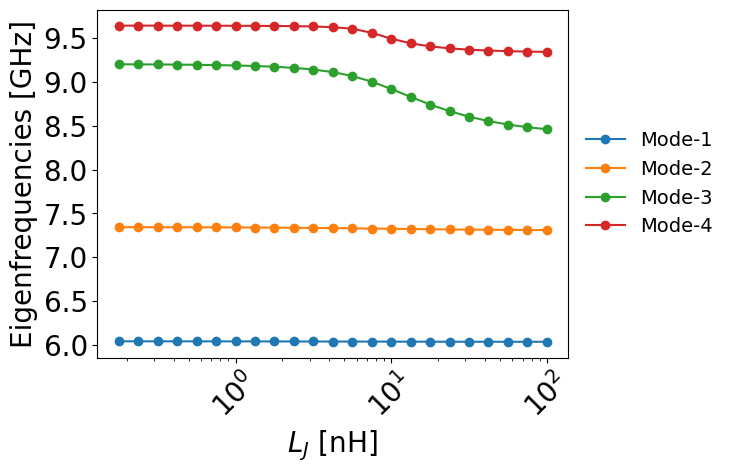

In [216]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
dstr = datetime.datetime.today().strftime('%y%m%d')
fsize = 20
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
idx_start = 4
Nmodes = 4
for k in range(Nmodes):
    wppp = np.array([wk[f'LJ{key}'][k] for key in Ljstrs])
    ax.plot(Lj_vals[2:], wppp[2:],
            'o-', label=r'Mode-%d' % (k + 1),
            color=cycle[k%clen])
    #ax.plot(LJs/1e-9, [wp0[idx]/(2*np.pi*fscale)] * len(LJs),
    #        '--', color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
#ax.set_ylim([5.88, 5.95])
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, lsize)
ax.set_xscale('log')
fig.savefig(f'../figs/modes_bare_remesh2_nondegen_{dstr}.pdf', 
            format='pdf', bbox_extra_artists=(leg, ), bbox_inches='tight',
           transparent=True)

# Plot the eigenmode $T_1$ values

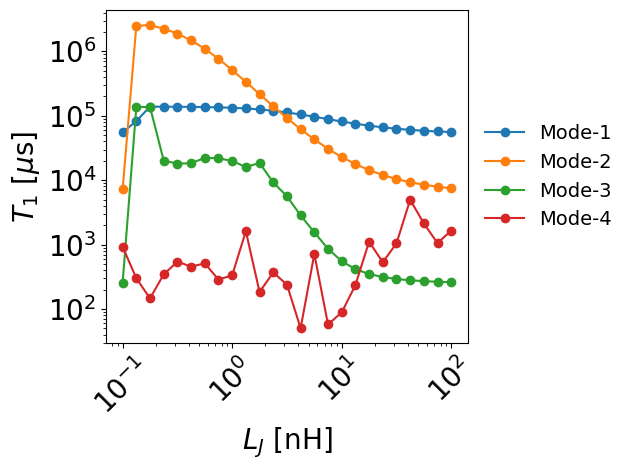

In [217]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fscale = 1e9
fscale2 = 1e6
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
T1trans = 100
for k in range(Nmodes):
    Q = np.array([Qk[f'LJ{key}'][k] for key in Ljstrs])
    wppp = 2*np.pi*np.array([wk[f'LJ{key}'][k] for key in Ljstrs])*fscale
    T1nom = 1e6 * Q / wppp
    T1tot = T1nom * T1trans / (T1nom + T1trans)
    ax.plot(Lj_vals, T1nom,
            'o-', label=r'Mode-%d' % (k + 1),
            color=cycle[k%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$T_1$ [$\mu$s]', fontsize=fsize)
# ax.plot(LJs/1e-9, np.ones(LJs.size) * dw/(fscale2), 'k--')
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
#ax.set_ylim([1e-2, 350])
#ax.set_xlim([0.5, 2.2])
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/T1_modes_coupled_remesh2_eigenmode_{dstr}.pdf',
            format='pdf')

## Compute the $g_{kk'}$ and $\widetilde{\omega}_{k}$ from $A_{kk'}$

In [272]:
"""
Compute the couplings from Akk, wk values
"""
# Iterate over all modes and inductances
gkk = {}
idx_start = 2; idx_stop = -1
Nmodes = 4
for k in range(Nmodes):
    for kp in range(Nmodes):
        for idx, LJ in enumerate(Lj_vals):
            
            # Outside sqrt(wk wk') factor
            wkey = f'LJ{Ljstrs[idx]}'
            wkwkp = np.sqrt(wk[wkey][k] * wk[wkey][kp])
            
            for idx0, LJ0 in enumerate(Lj_vals):
                
                # Key to index gkk'
                gkey = f'kkp{k+1}_{kp+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
                Akkpsum = 0
                print(f'Computing g at {gkey}, wkwkp: {wkwkp:.2e} ...')
                for kpp in range(Nmodes):
                    key = f'kkp{kpp+1}_{k+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
                    keyp = f'kkp{kpp+1}_{kp+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
                    Akppk = Akkp[key]
                    Akppkp = Akkp[keyp]
                    Akkpsum += Akppk * Akppkp

                # Store the results
                if (k != kp):
                    gkk.update({gkey : wkwkp * Akkpsum})

Computing g at kkp1_1_LJLJp_0p10000000000000001nH_0p10000000000000001nH, wkwkp: 6.03e+00 ...
Computing g at kkp1_1_LJLJp_0p10000000000000001nH_0p13335214321633199nH, wkwkp: 6.03e+00 ...
Computing g at kkp1_1_LJLJp_0p10000000000000001nH_0p17782794100389199nH, wkwkp: 6.03e+00 ...
Computing g at kkp1_1_LJLJp_0p10000000000000001nH_0p23713737056616499nH, wkwkp: 6.03e+00 ...
Computing g at kkp1_1_LJLJp_0p10000000000000001nH_0p316227766016838nH, wkwkp: 6.03e+00 ...
Computing g at kkp1_1_LJLJp_0p10000000000000001nH_0p421696503428582nH, wkwkp: 6.03e+00 ...
Computing g at kkp1_1_LJLJp_0p10000000000000001nH_0p56234132519034896nH, wkwkp: 6.03e+00 ...
Computing g at kkp1_1_LJLJp_0p10000000000000001nH_0p74989420933245599nH, wkwkp: 6.03e+00 ...
Computing g at kkp1_1_LJLJp_0p10000000000000001nH_1nH, wkwkp: 6.03e+00 ...
Computing g at kkp1_1_LJLJp_0p10000000000000001nH_1p33352143216332nH, wkwkp: 6.03e+00 ...
Computing g at kkp1_1_LJLJp_0p10000000000000001nH_1p7782794100389201nH, wkwkp: 6.03e+00 ...
Com

Computing g at kkp4_3_LJLJp_23p713737056616601nH_4p2169650342858196nH, wkwkp: 9.02e+00 ...
Computing g at kkp4_3_LJLJp_23p713737056616601nH_5p6234132519034903nH, wkwkp: 9.02e+00 ...
Computing g at kkp4_3_LJLJp_23p713737056616601nH_7p498942093324561nH, wkwkp: 9.02e+00 ...
Computing g at kkp4_3_LJLJp_23p713737056616601nH_10nH, wkwkp: 9.02e+00 ...
Computing g at kkp4_3_LJLJp_23p713737056616601nH_13p335214321633201nH, wkwkp: 9.02e+00 ...
Computing g at kkp4_3_LJLJp_23p713737056616601nH_17p7827941003892nH, wkwkp: 9.02e+00 ...
Computing g at kkp4_3_LJLJp_23p713737056616601nH_23p713737056616601nH, wkwkp: 9.02e+00 ...
Computing g at kkp4_3_LJLJp_23p713737056616601nH_31p622776601683796nH, wkwkp: 9.02e+00 ...
Computing g at kkp4_3_LJLJp_23p713737056616601nH_42p169650342858198nH, wkwkp: 9.02e+00 ...
Computing g at kkp4_3_LJLJp_23p713737056616601nH_56p234132519034901nH, wkwkp: 9.02e+00 ...
Computing g at kkp4_3_LJLJp_23p713737056616601nH_74p989420933245597nH, wkwkp: 9.02e+00 ...
Computing g at kkp

In [219]:
'kkp1_1_LJLJp_0p10000000000000001nH_0p10000000000000001nH' in gkk.keys()

False

### Collect the results as a matrix

In [220]:
gkk_matrix = np.zeros([Nmodes, Nmodes, len(Lj_vals), len(Lj_vals)])
for k in range(Nmodes):
    for kp in range(Nmodes):
        for idx, LJ in enumerate(Lj_vals):
            for idx0, LJ0 in enumerate(Lj_vals):
                if k != kp:
                    gkey = f'kkp{k+1}_{kp+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
                    gkk_matrix[k, kp, idx, idx0] = gkk[gkey]


In [221]:
gkk_matrix

array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[-2.94842273e-03, -2.86324720e-03, -2.90557660e-03, ...,
          -4.27398286e-02, -4.45010696e-02, -4.59018886e-02],
         [-2.91482148e-03, -2.93900418e-03, -2.99049364e-03, ...,
          -4.47033420e

In [273]:
"""
Compute the couplings from Akk, wk values
"""
# Iterate over all modes and inductances
wkt = {}
idx_start = 2; idx_stop = -1
Nmodes = 4
for k in range(Nmodes):
    for idx, LJ in enumerate(Lj_vals):

        # Outside wk factor
        wkey = f'LJ{Ljstrs[idx]}'
        wkp = wk[wkey][k]

        for idx0, LJ0 in enumerate(Lj_vals):

            # Key to index gkk'
            wwkey = f'kkp{k+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
            Akkpsum = 0
            # print(f'Computing wkp at {wwkey}, wkwkp: {wkp:.2e} ...')
            for kpp in range(Nmodes):
                key = f'kkp{kpp+1}_{k+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
                Akppk = Akkp[key]
                Akkpsum += Akppk**2

            # Store the results
            wkt.update({wwkey : wkp * Akkpsum})

In [274]:
len(wkt)

2500

In [275]:
wkt_matrix = np.zeros([Nmodes, len(Lj_vals), len(Lj_vals)])

## Compute the $\widetilde{\omega}_k(L_J, L_{J_0})$ matrix

In [276]:
for k in range(Nmodes):
    for idx, LJ in enumerate(Lj_vals):
        for idx0, LJ0 in enumerate(Lj_vals):
            wwkkey = f'kkp{k+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
            wkt_matrix[k, idx, idx0] = wkt[wwkkey]

### Sort the frequencies for each $(L_J, L_{J_0})$ pair

In [277]:
wkt_matrix_sorted = np.sort(wkt_matrix, axis=0)
wkt_sort_idx = np.argsort(wkt_matrix, axis=0)

In [278]:
gkk_sort_idx = wkt_sort_idx[np.newaxis, :, :, :]

In [279]:
gkk_sort_idx.shape

(1, 4, 25, 25)

In [280]:
gkk_matrix_sorted = gkk_matrix[gkk_sort_idx]

In [282]:
gkk_matrix_sorted.shape

(1, 4, 25, 25, 4, 25, 25)

## Plot the sorted $\widetilde{\omega}_k(L_J, L_{J_0})$ values

LJ0-0 ...
LJ0-1 ...
LJ0-2 ...
LJ0-3 ...
LJ0-4 ...
LJ0-5 ...
LJ0-6 ...
LJ0-7 ...
LJ0-8 ...
LJ0-9 ...
LJ0-10 ...
LJ0-11 ...
LJ0-12 ...
LJ0-13 ...
LJ0-14 ...
LJ0-15 ...
LJ0-16 ...
LJ0-17 ...
LJ0-18 ...
LJ0-19 ...
LJ0-20 ...


C:\Users\nmaterise\AppData\Local\Temp\ipykernel_29632\541766634.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, tight_layout=True)


LJ0-21 ...
LJ0-22 ...
LJ0-23 ...
LJ0-24 ...


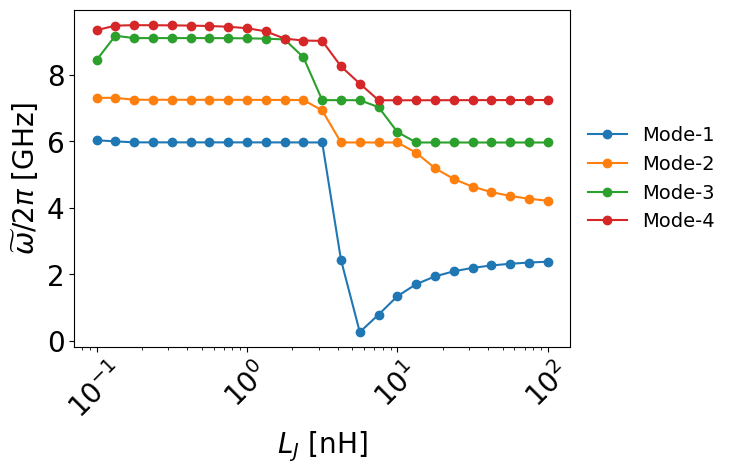

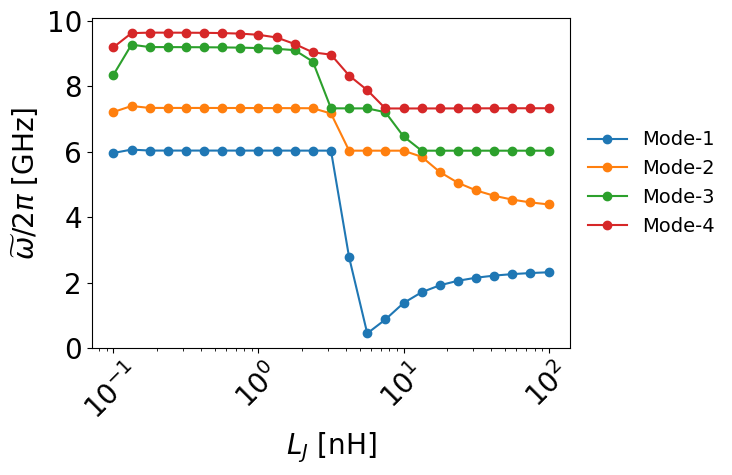

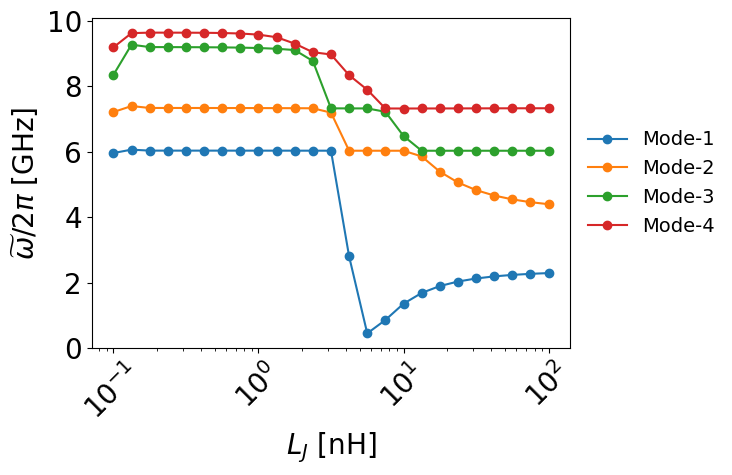

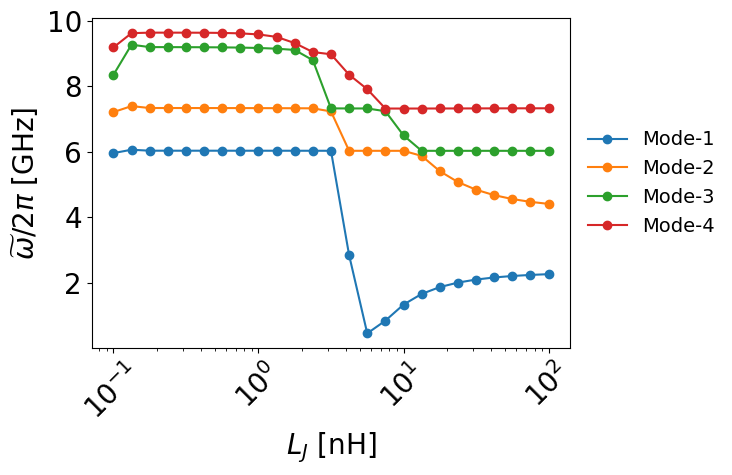

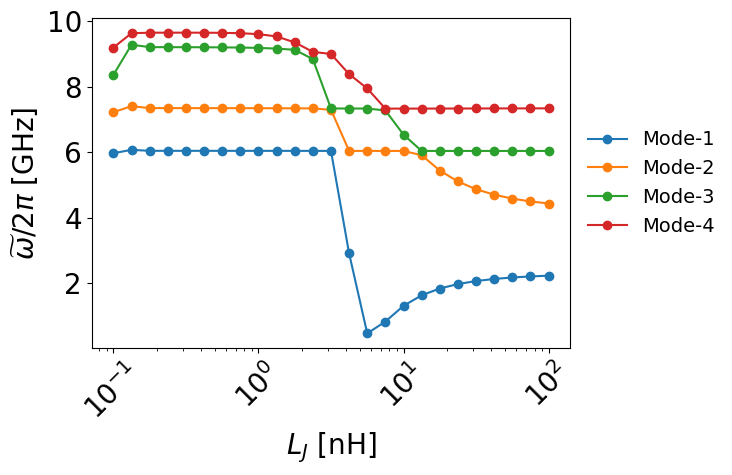

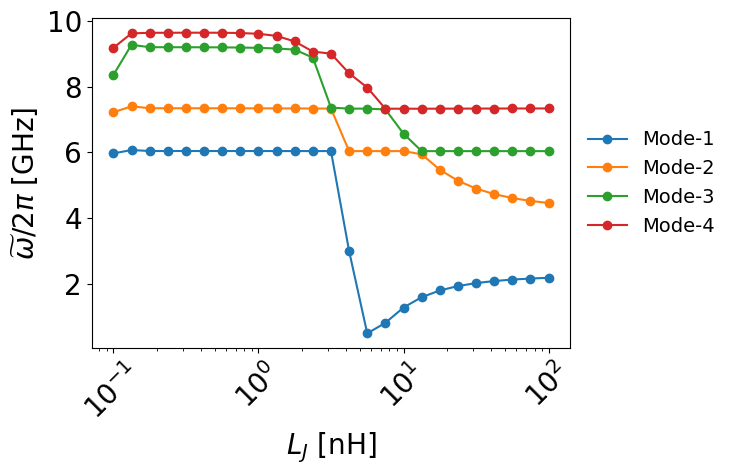

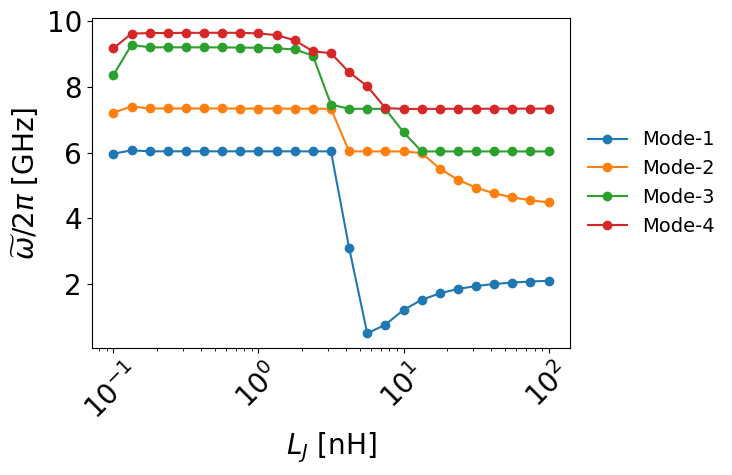

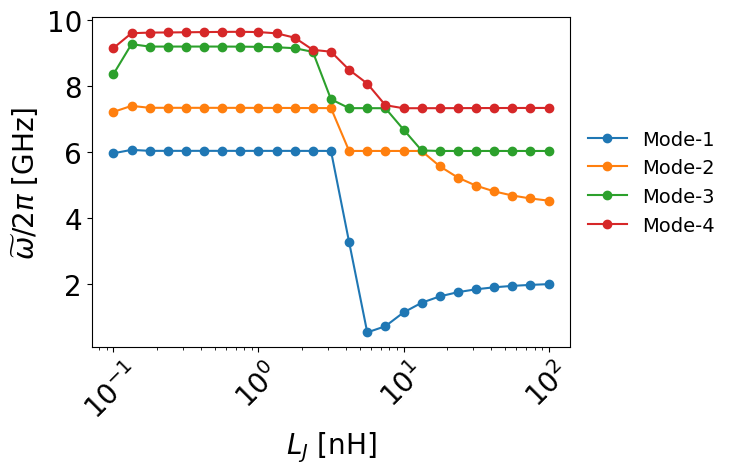

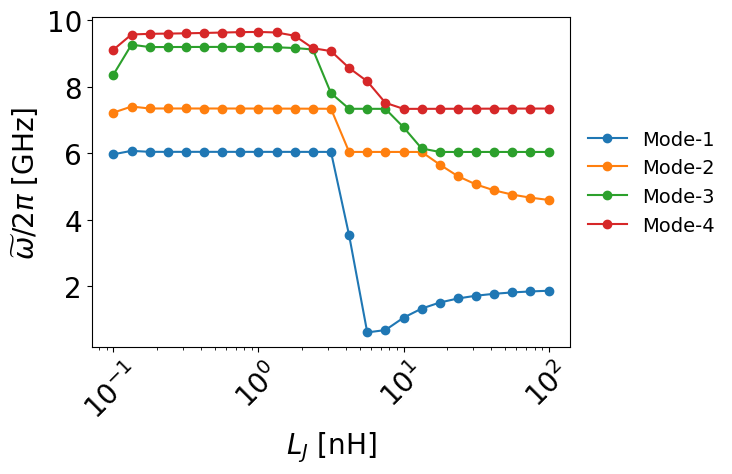

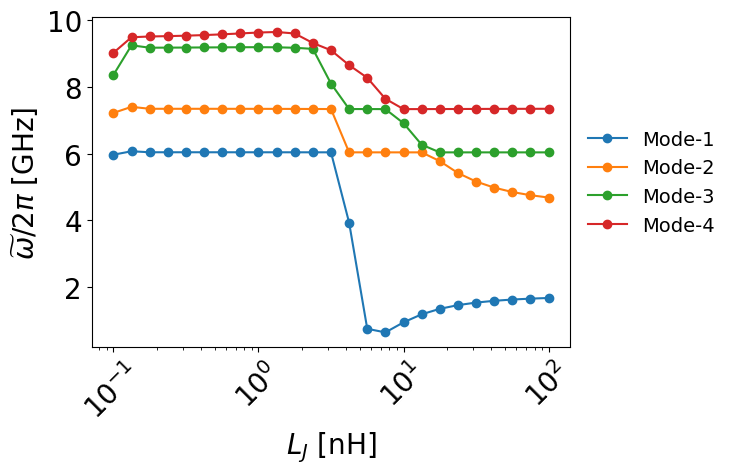

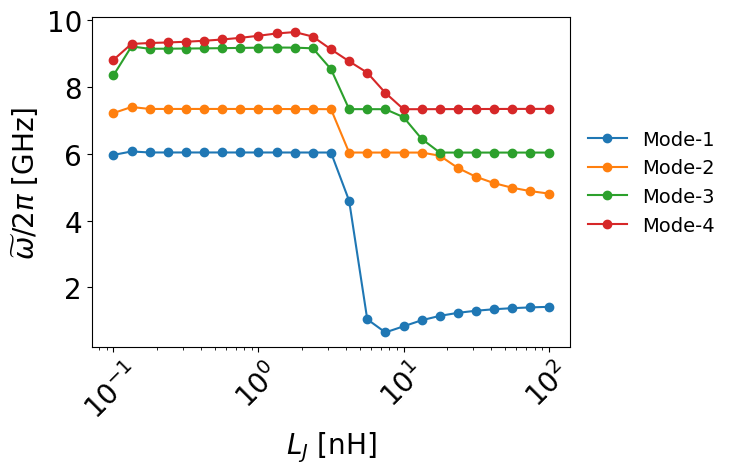

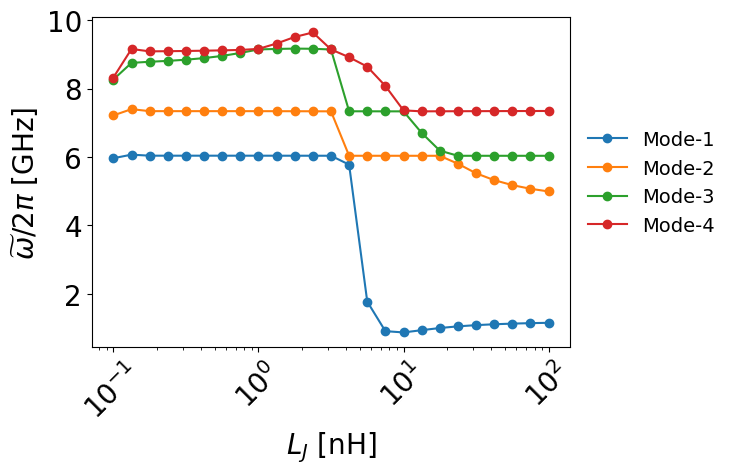

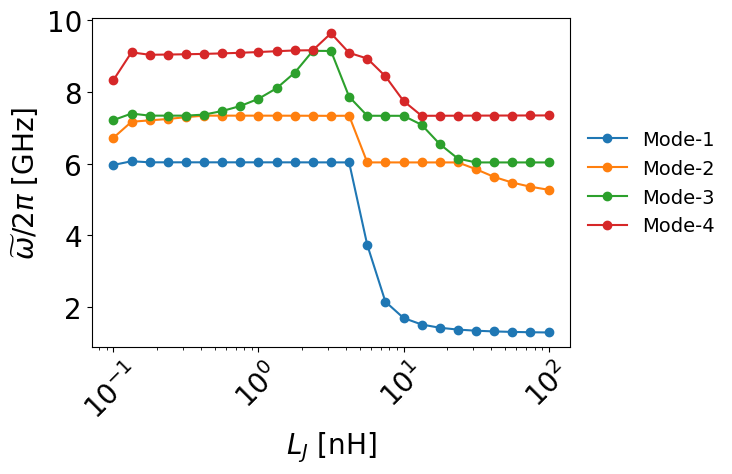

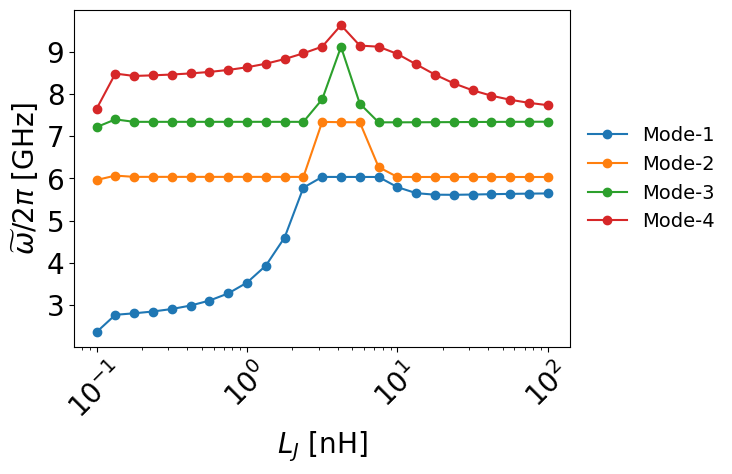

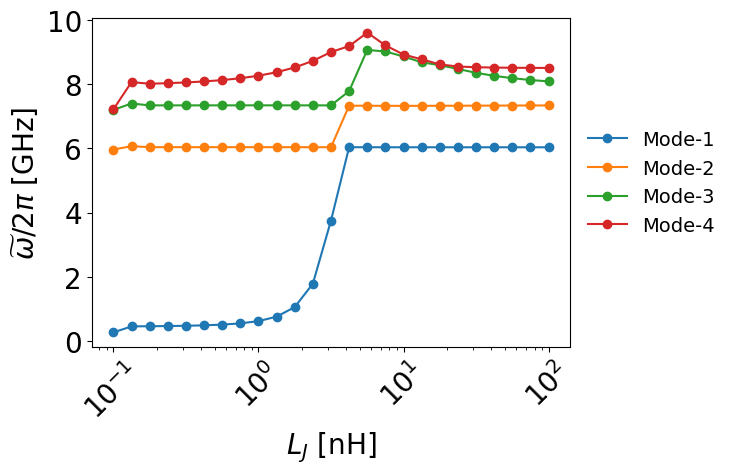

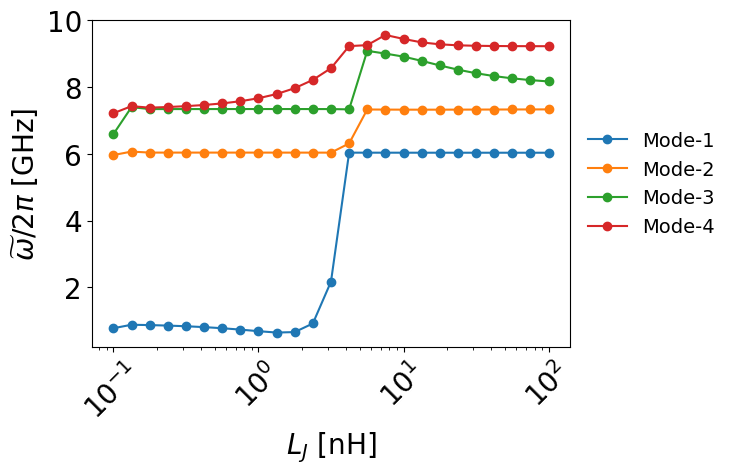

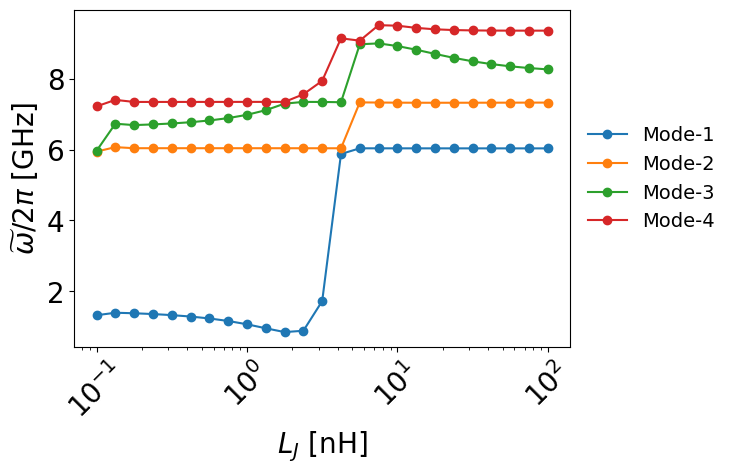

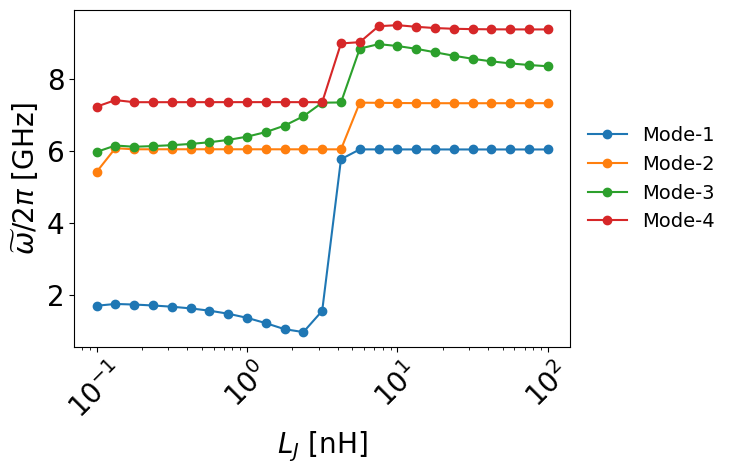

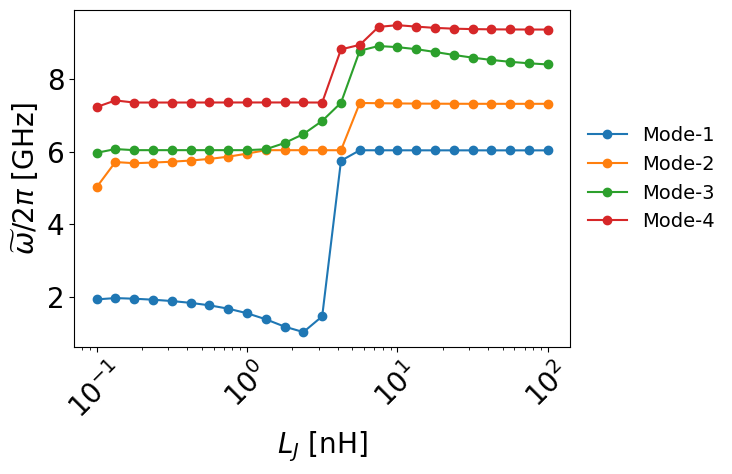

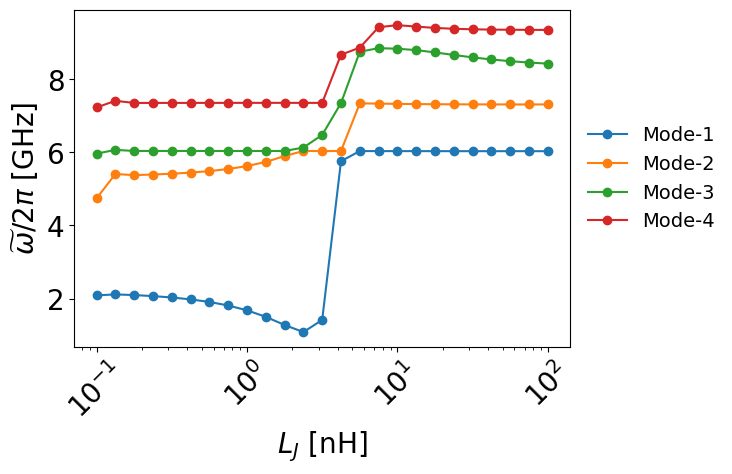

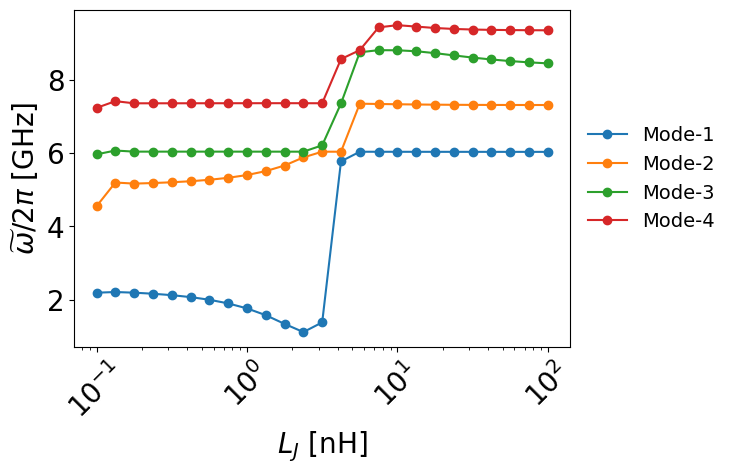

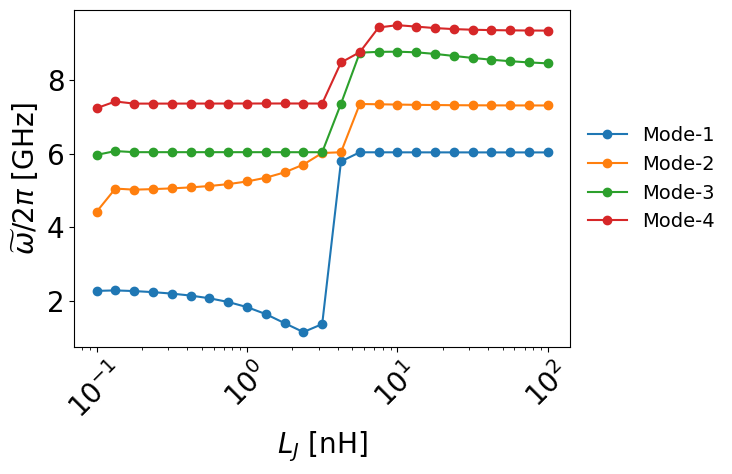

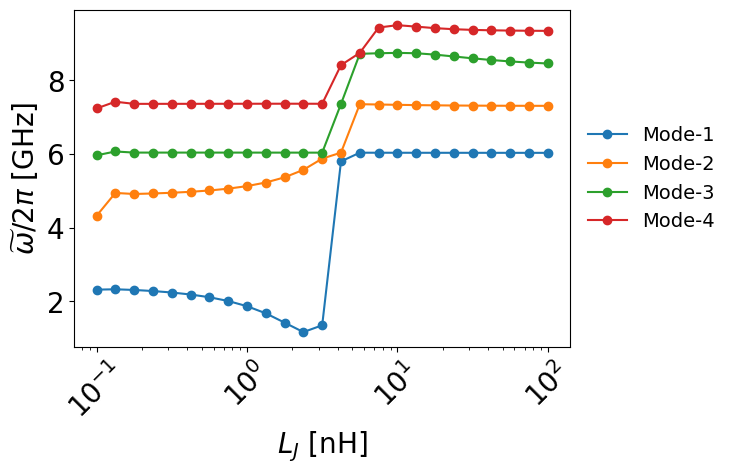

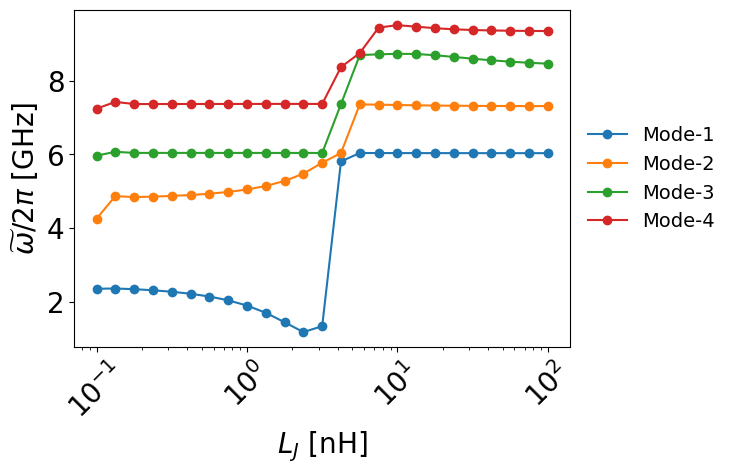

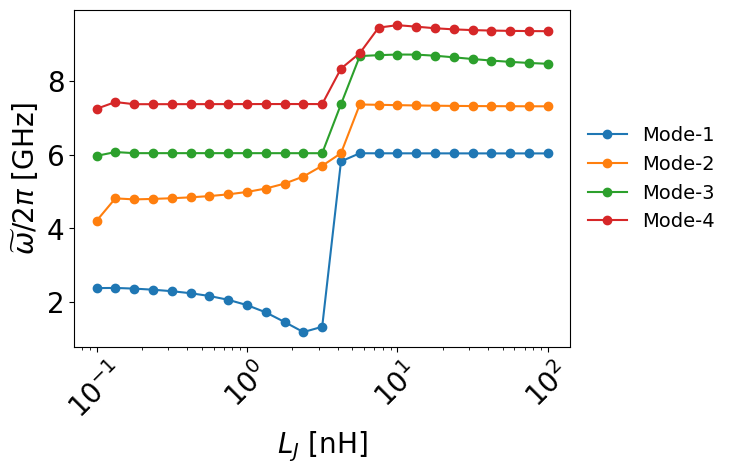

In [317]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)

for idx_fixed in range(len(Lj_vals)):
    print(f'LJ0-{idx_fixed} ...')
    fig, ax = plt.subplots(1, 1, tight_layout=True)
    for k in range(Nmodes):
        ax.plot(Lj_vals, wkt_matrix_sorted[k, :, idx_fixed],
            'o-', label=r'Mode-%d' % (k + 1),
            color=cycle[k%clen])
    ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
    ax.set_ylabel(r'$\widetilde{\omega}/2\pi$ [GHz]', fontsize=fsize)
    set_xaxis_rot(ax, 45)
    set_axes_fonts(ax, fsize)
    leg = set_leg_outside(ax, lsize)
    ax.set_xscale('log')
    fig.savefig(f'../figs/modes_eigenmode_remesh2_modified_LJ0_{Ljstrs[idx_fixed]}_{dstr}.pdf', 
                format='pdf', bbox_extra_artists=(leg, ), bbox_inches='tight',
               transparent=True)

In [232]:
'kkp1_LJLJp_0p10000000000000001nH_56p234132519034901nH' in wkt.keys()

True

## Plot $g_{k_1,k_2}$ vs. $L_J, L_{J_0}$

In [283]:
gmax = np.max(np.array(list(gkk.values()))) * 1e3
gmin = np.min(np.array(list(gkk.values()))) * 1e3

In [284]:
gmax

2941.1271603073324

In [285]:
gmin

-2976.9558421738043

Writing ../figs/g1_2_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/g1_3_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/g1_4_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/g2_1_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/g2_3_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/g2_4_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/g3_1_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/g3_2_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/g3_4_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/g4_1_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/g4_2_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/g4_3_remesh2_sorted_vs_LJLJ0_230120.pdf ...


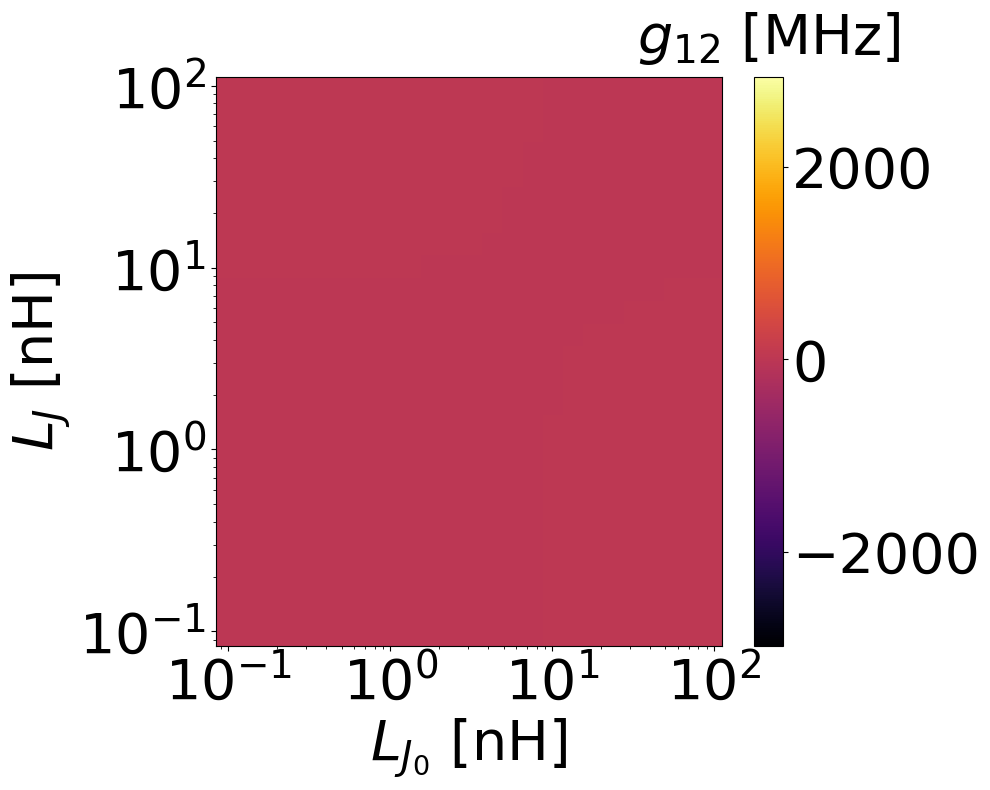

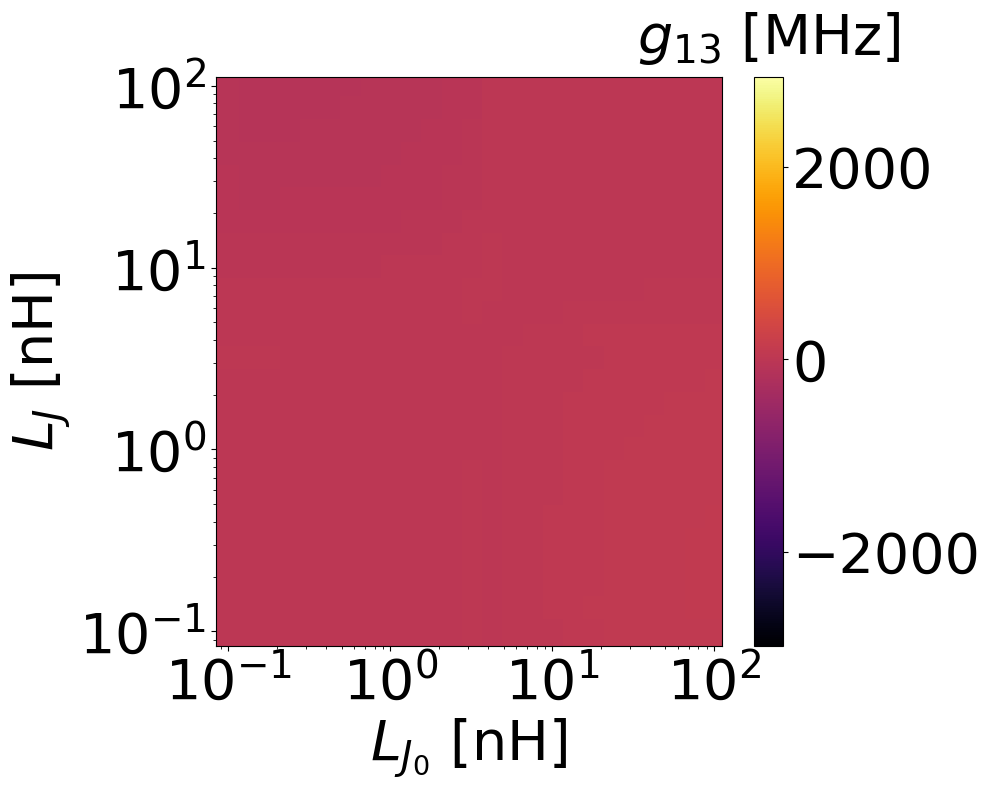

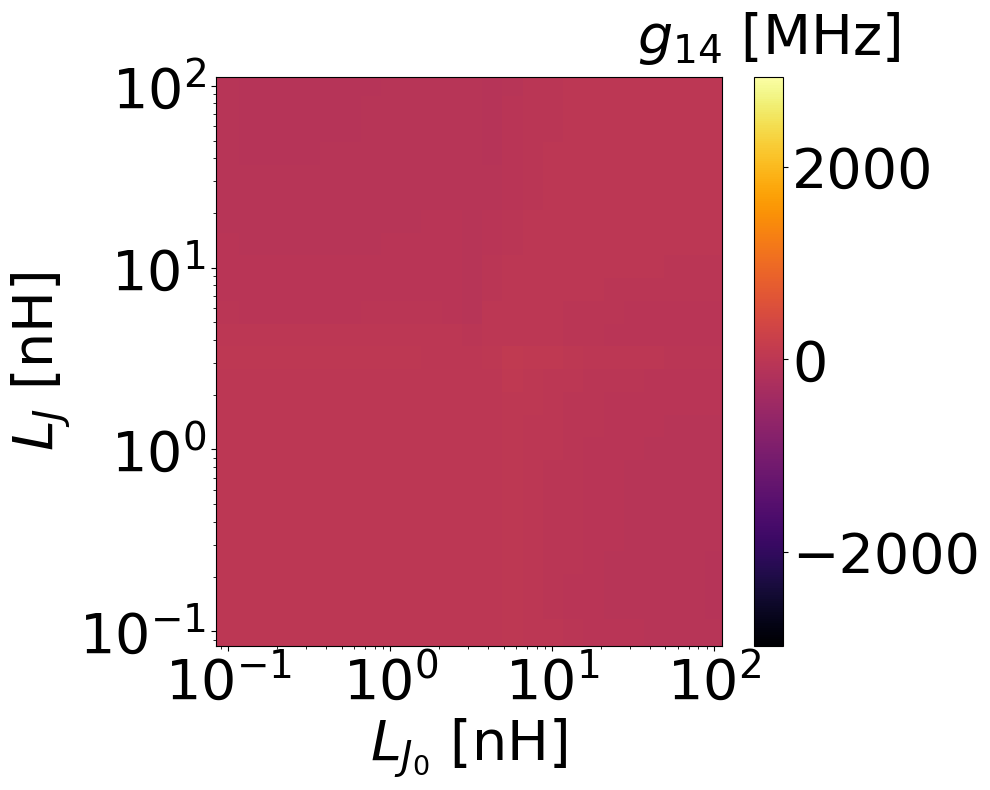

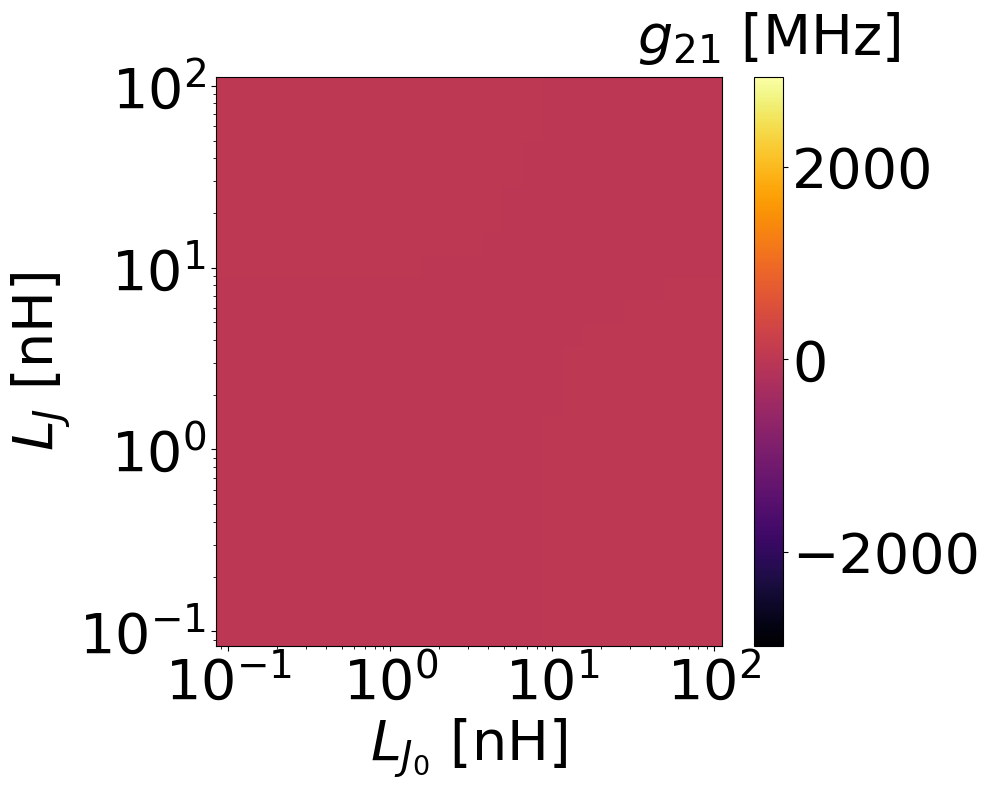

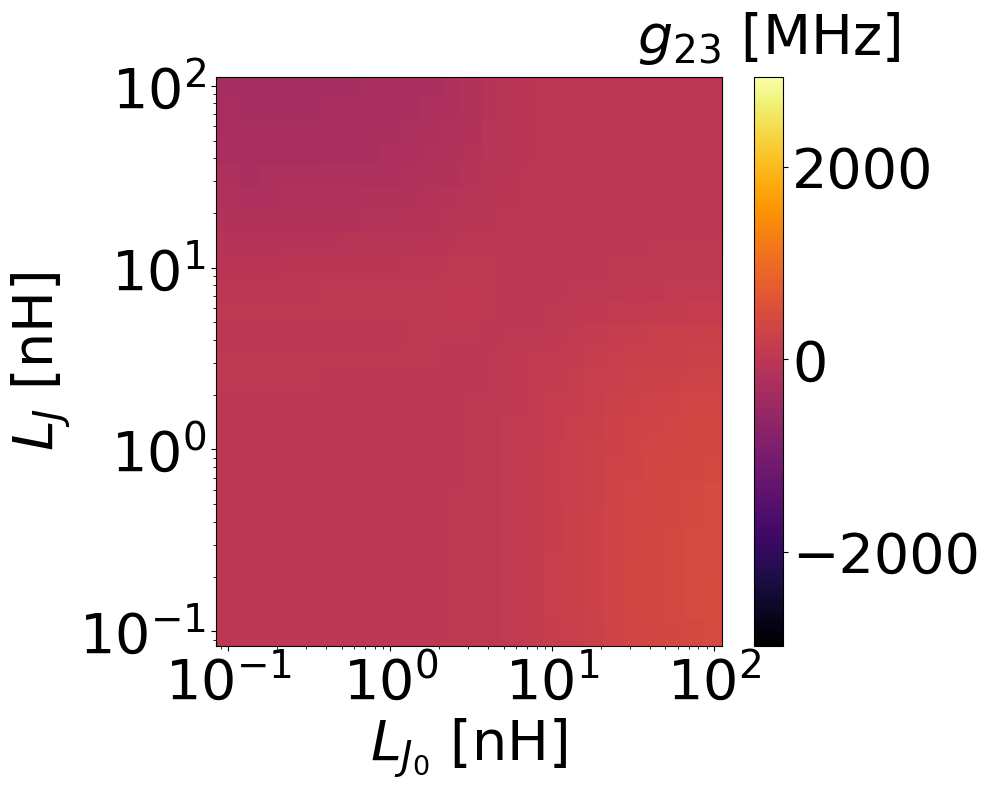

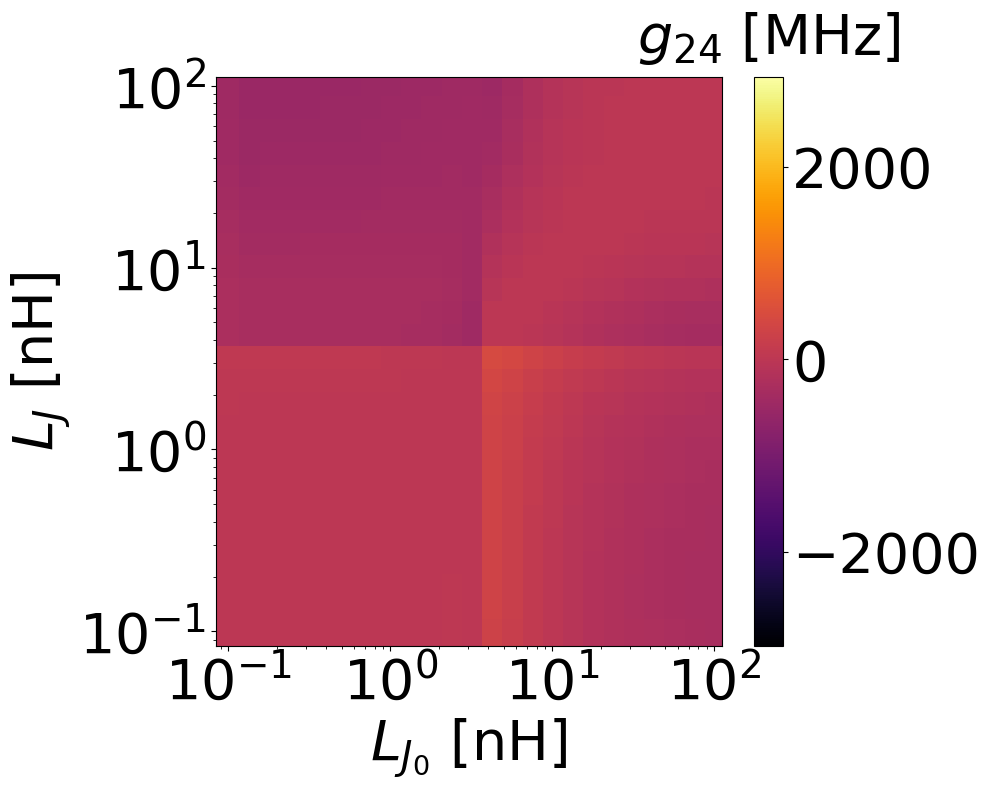

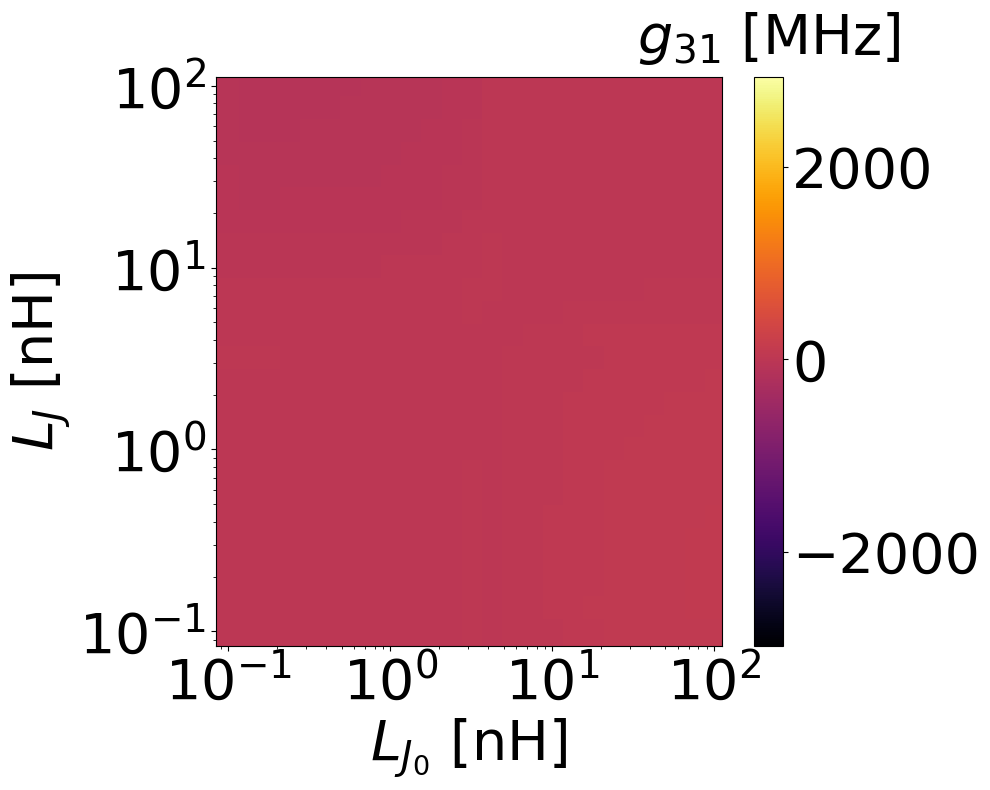

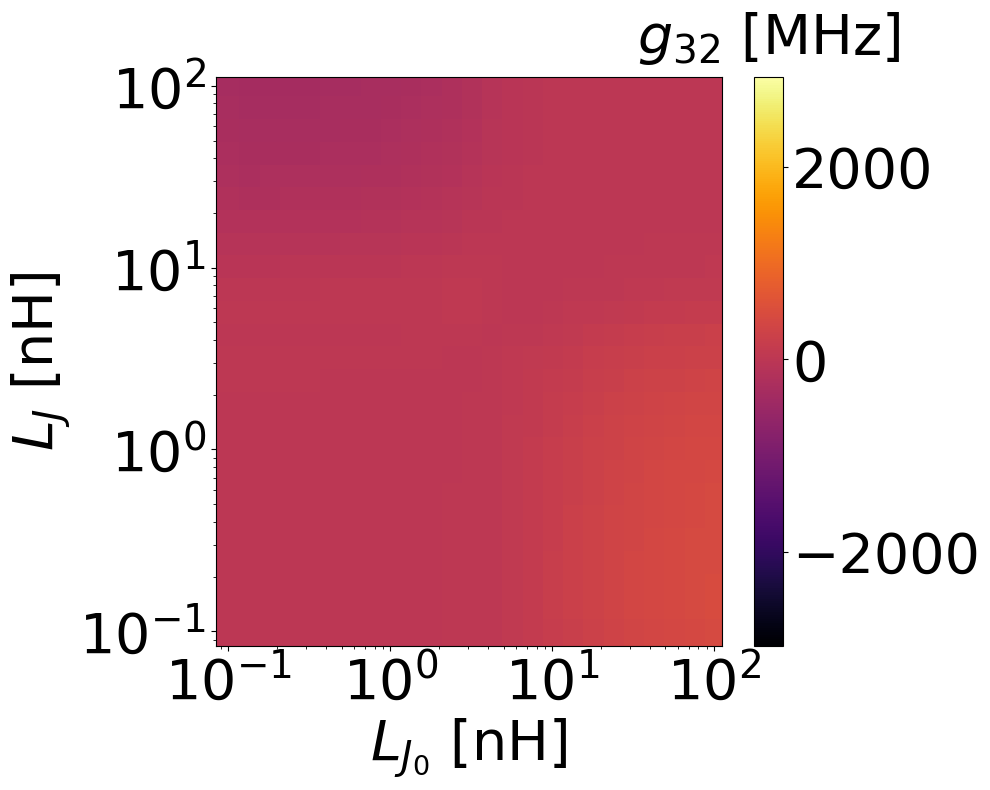

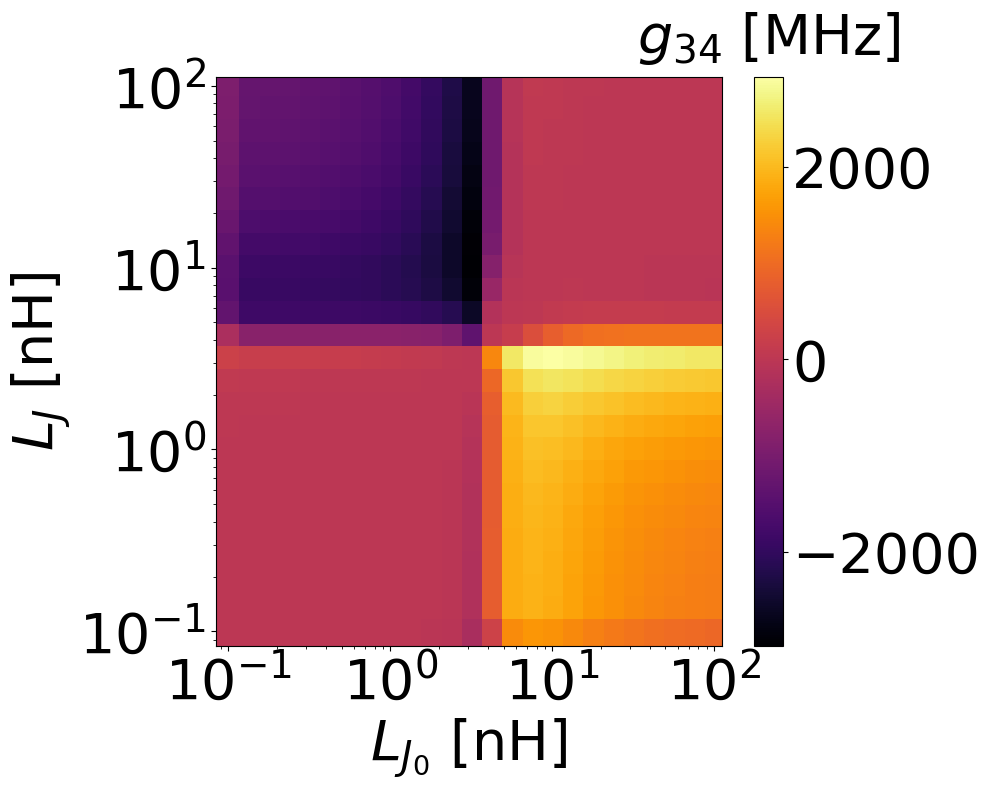

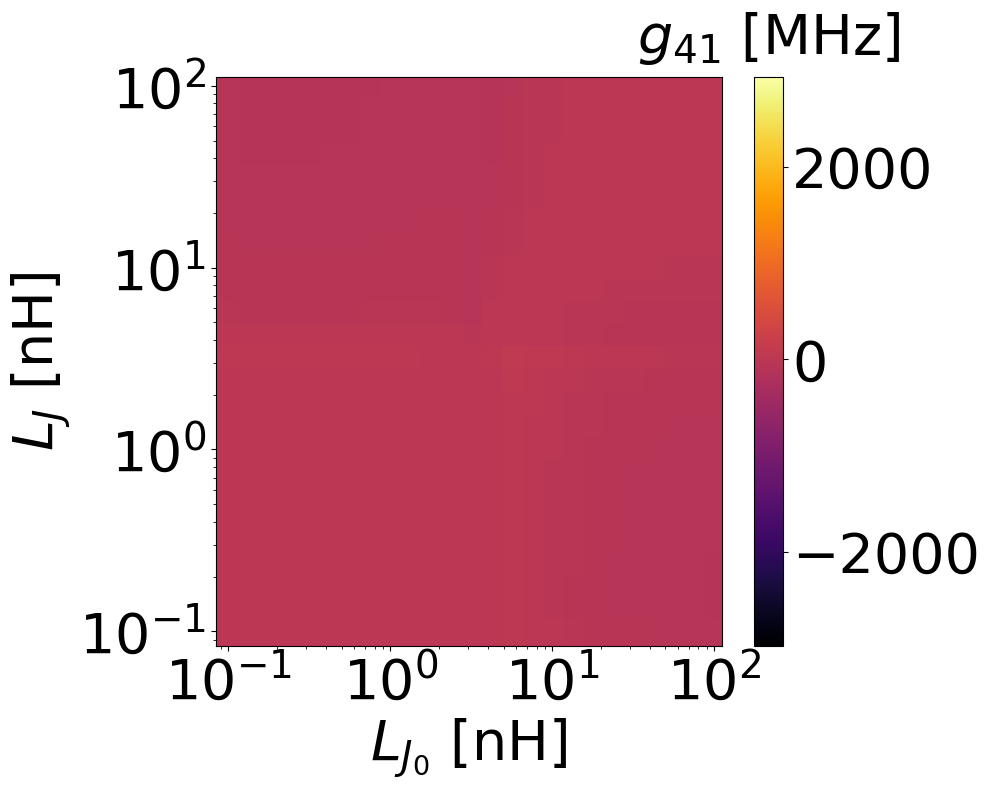

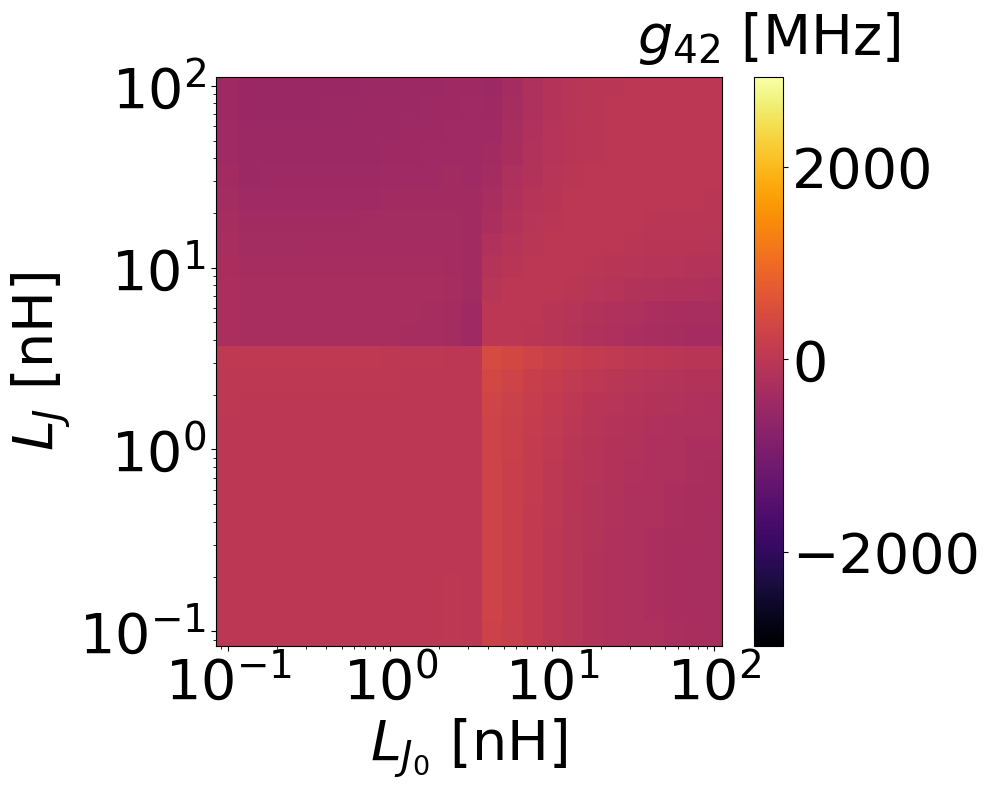

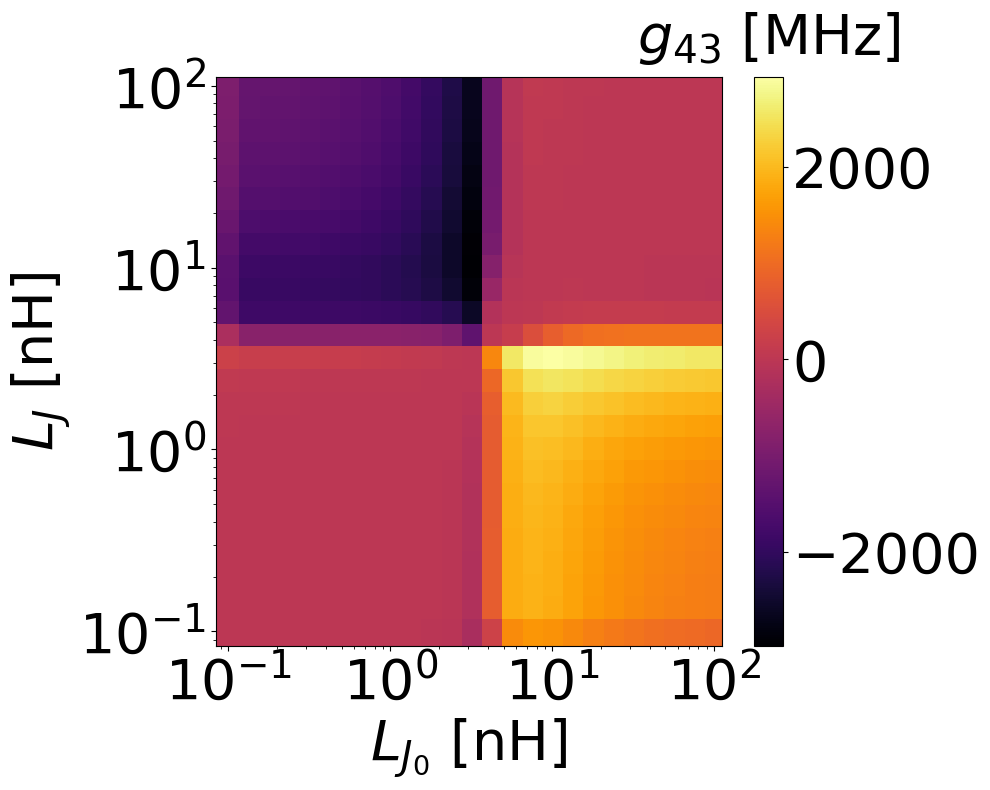

In [286]:
#plot_2d_cmap(ydata/ymax,
#    zdata/zmax,
for k1 in [1,2,3,4]:
    for k2 in [1, 2, 3, 4]:
        if k1 != k2:
            gkk12 = np.array([[gkk[f'kkp{k1}_{k2}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'] \
                               for idx in range(len(Lj_vals))] \
                               for idx0 in range(len(Lj_vals))])*1e3
            plot_2d_cmap(# LJs/1e-9,
                #Lj_vals[idx_start:idx_stop],
                #Lj_vals[idx_start:idx_stop],
                Lj_vals,
                Lj_vals,
                gkk12,
                # gkk_matrix_sorted[k1, k2, :, :],
                f'../figs/g{k1}_{k2}_remesh2_sorted_vs_LJLJ0_{dd}.pdf',
                xstr=r'$L_{J_0}$ [nH]',
                ystr=r'$L_{J}$ [nH]',
                tstr='',
                xyscales={'x' : 'log', 'y' : 'log'},
                cbar_str=r'$g_{%d%d}$ [MHz]' % (k1, k2),
                interp_zeros=False,
                interp_std_dev=3,
                image_rot_angle=0,
                norm_type='ref',
                zref=[gmin, gmax],
                fsize=40,
                tsize=46)

## Plot $A_{k_1,k_2}(L_{J}, L_{J_0})$ vs. $L_J, L_{J_0}$

In [287]:
Amax = np.max(list(Akkp.values()))
Amin = np.min(list(Akkp.values()))

In [288]:
Lj_vals

array([  0.1       ,   0.13335214,   0.17782794,   0.23713737,
         0.31622777,   0.4216965 ,   0.56234133,   0.74989421,
         1.        ,   1.33352143,   1.77827941,   2.37137371,
         3.16227766,   4.21696503,   5.62341325,   7.49894209,
        10.        ,  13.33521432,  17.7827941 ,  23.71373706,
        31.6227766 ,  42.16965034,  56.23413252,  74.98942093,
       100.        ])

In [289]:
Ljstrs

array(['0p10000000000000001nH', '0p13335214321633199nH',
       '0p17782794100389199nH', '0p23713737056616499nH',
       '0p316227766016838nH', '0p421696503428582nH',
       '0p56234132519034896nH', '0p74989420933245599nH', '1nH',
       '1p33352143216332nH', '1p7782794100389201nH',
       '2p3713737056616599nH', '3p16227766016838nH',
       '4p2169650342858196nH', '5p6234132519034903nH',
       '7p498942093324561nH', '10nH', '13p335214321633201nH',
       '17p7827941003892nH', '23p713737056616601nH',
       '31p622776601683796nH', '42p169650342858198nH',
       '56p234132519034901nH', '74p989420933245597nH', '100nH'],
      dtype='<U21')

In [290]:
Amax

1.000000000000068

In [291]:
Amin

-0.900181241632405

Writing ../figs/A1_1_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A1_2_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A1_3_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A1_4_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A2_1_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A2_2_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A2_3_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A2_4_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A3_1_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A3_2_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A3_3_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A3_4_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A4_1_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A4_2_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A4_3_mag_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/A4_4_mag_remesh2_vs_LJLJ0_230120.pdf ...


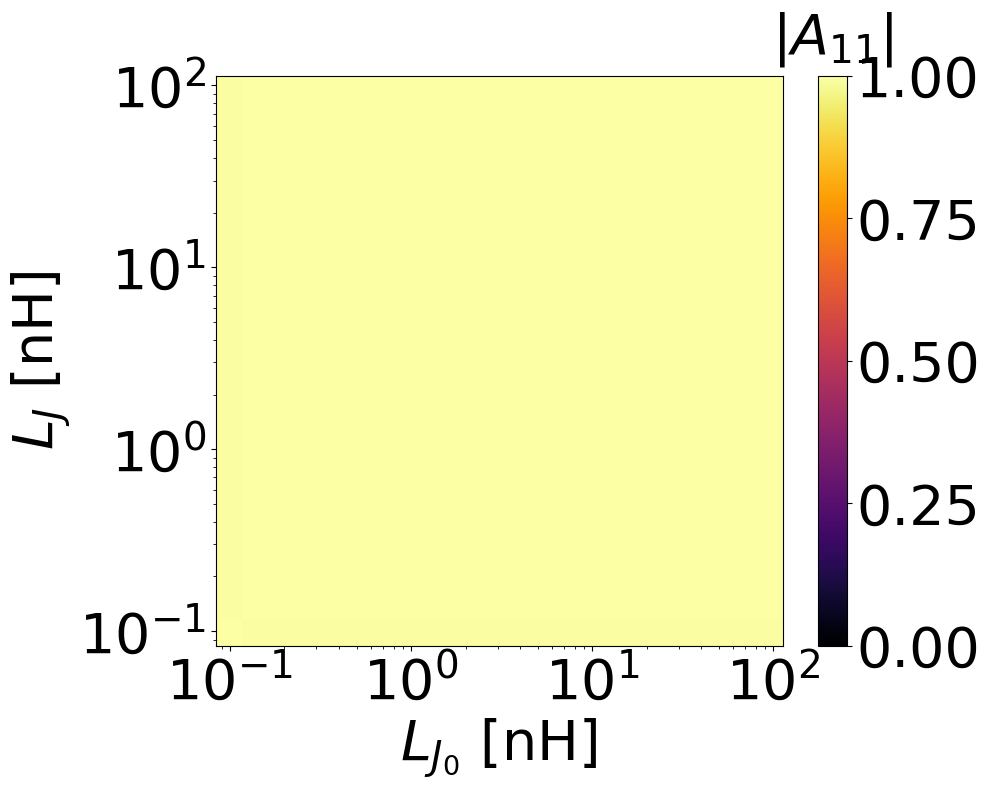

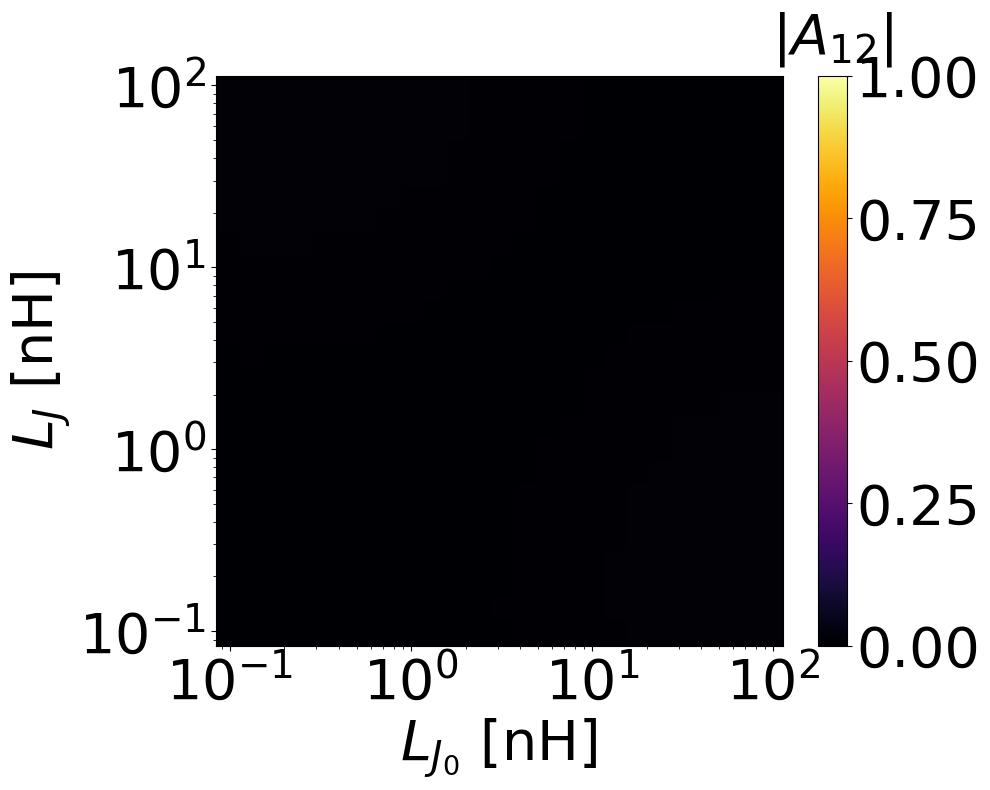

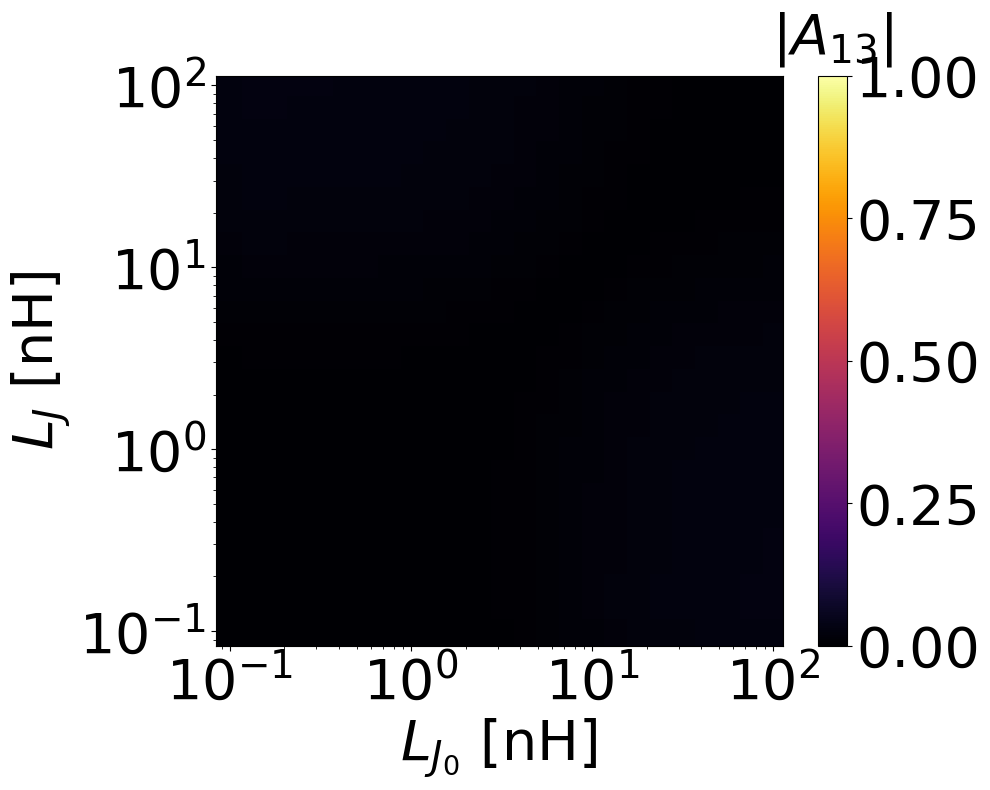

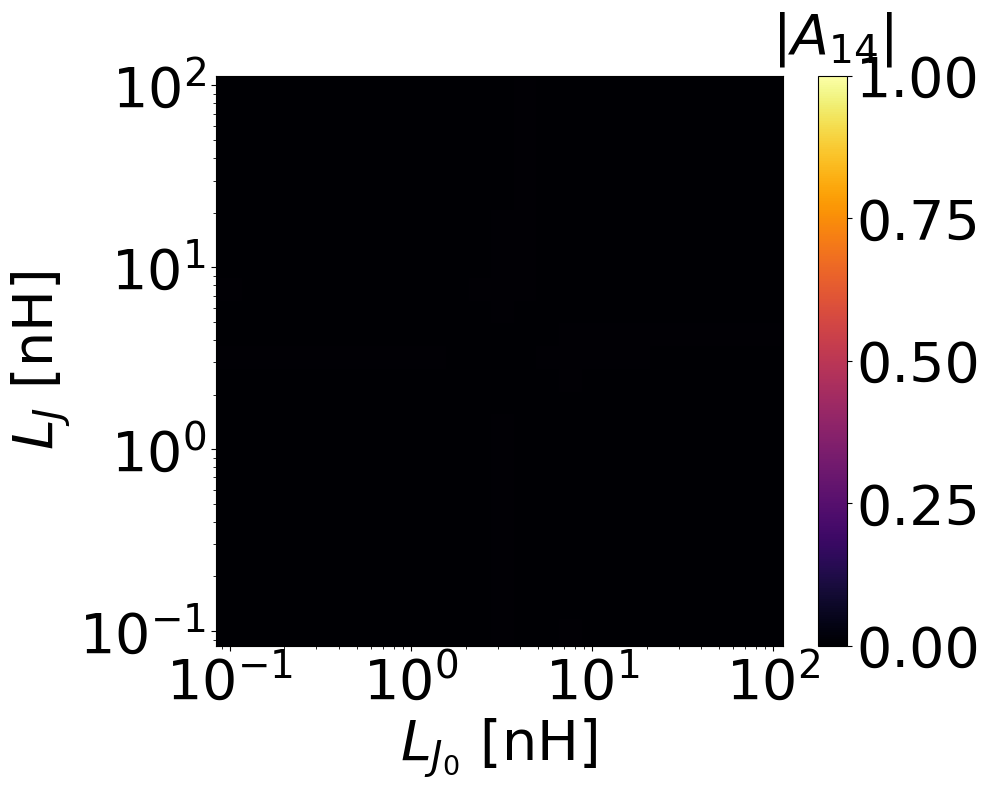

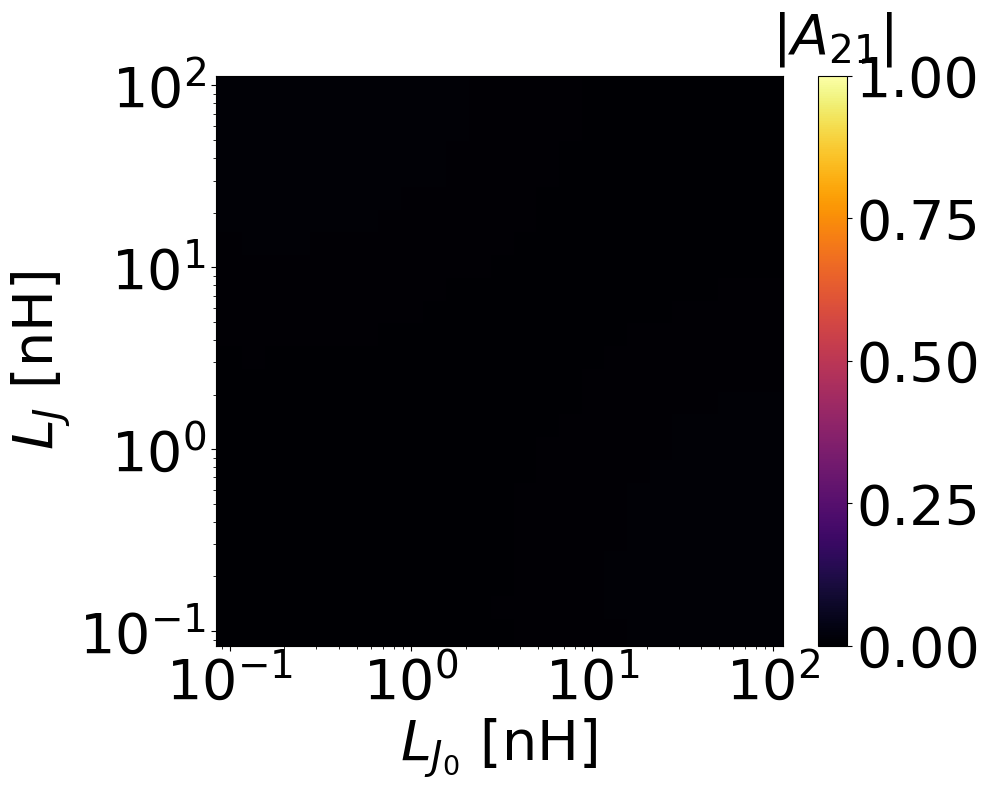

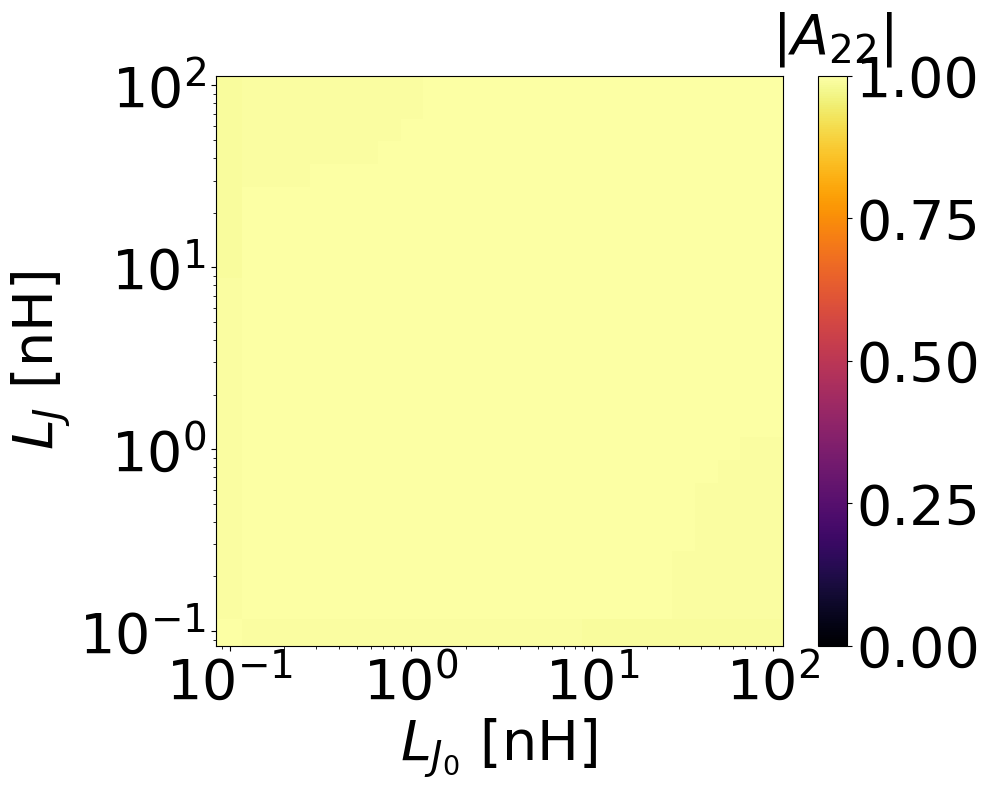

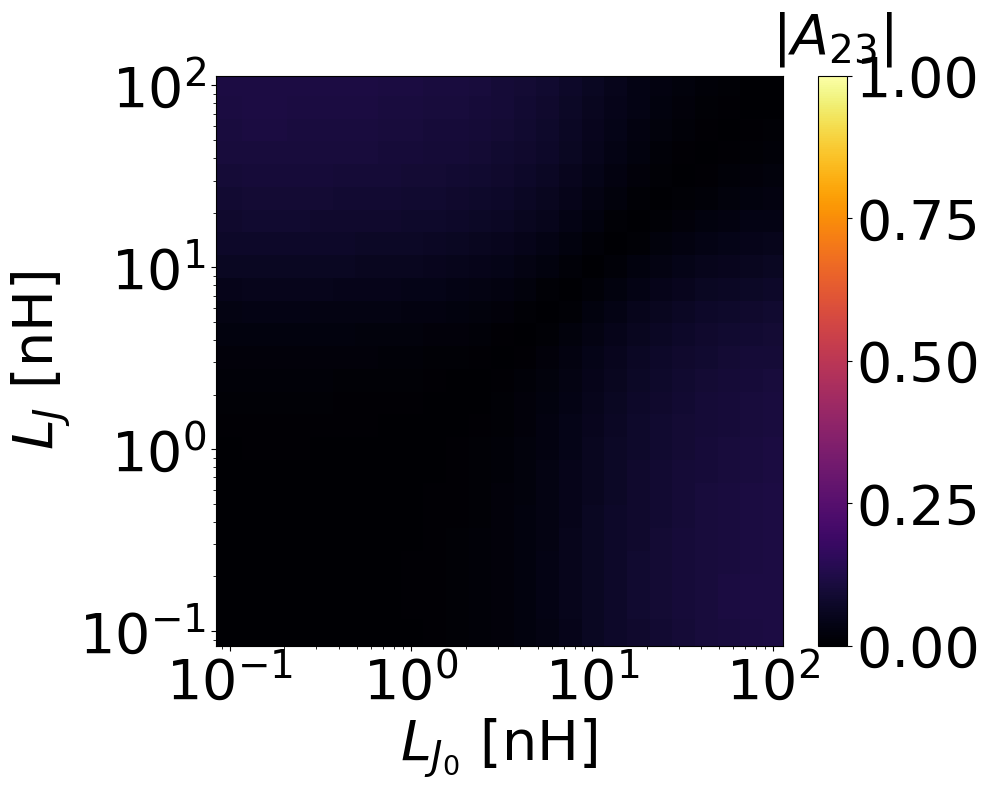

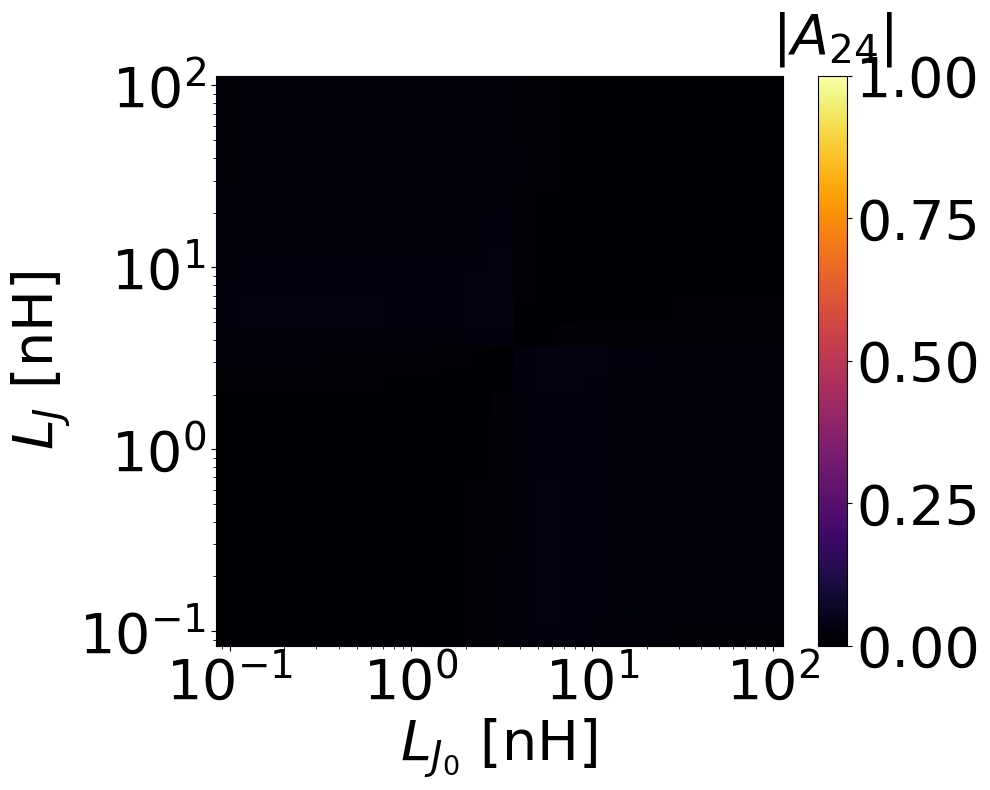

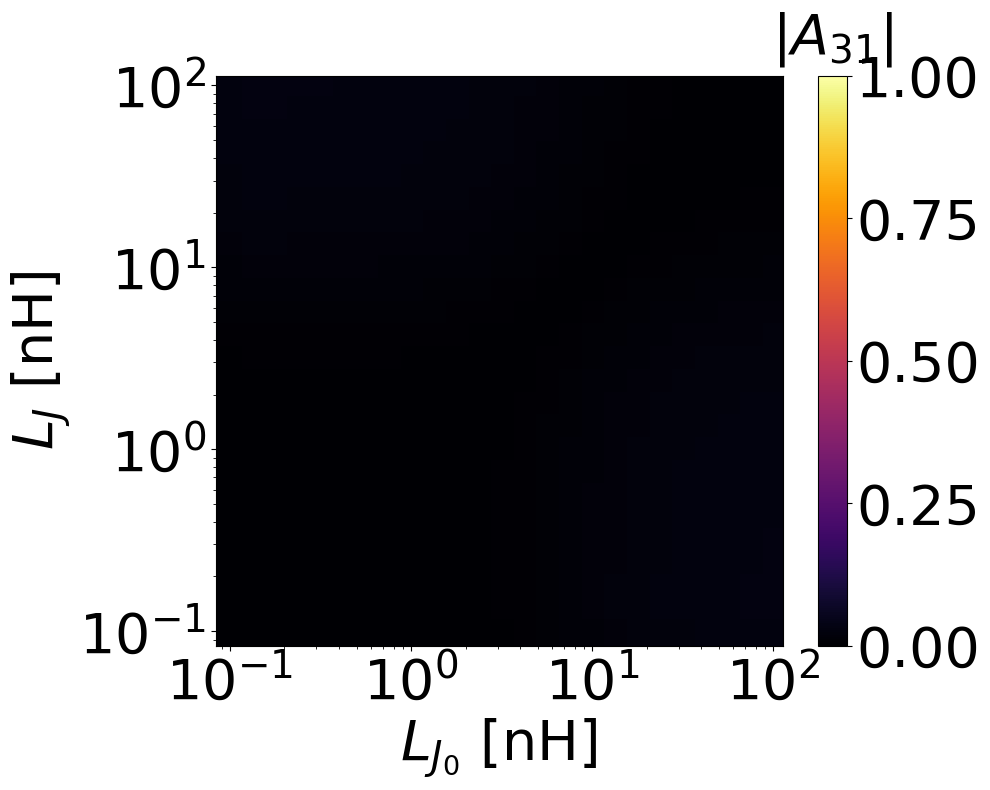

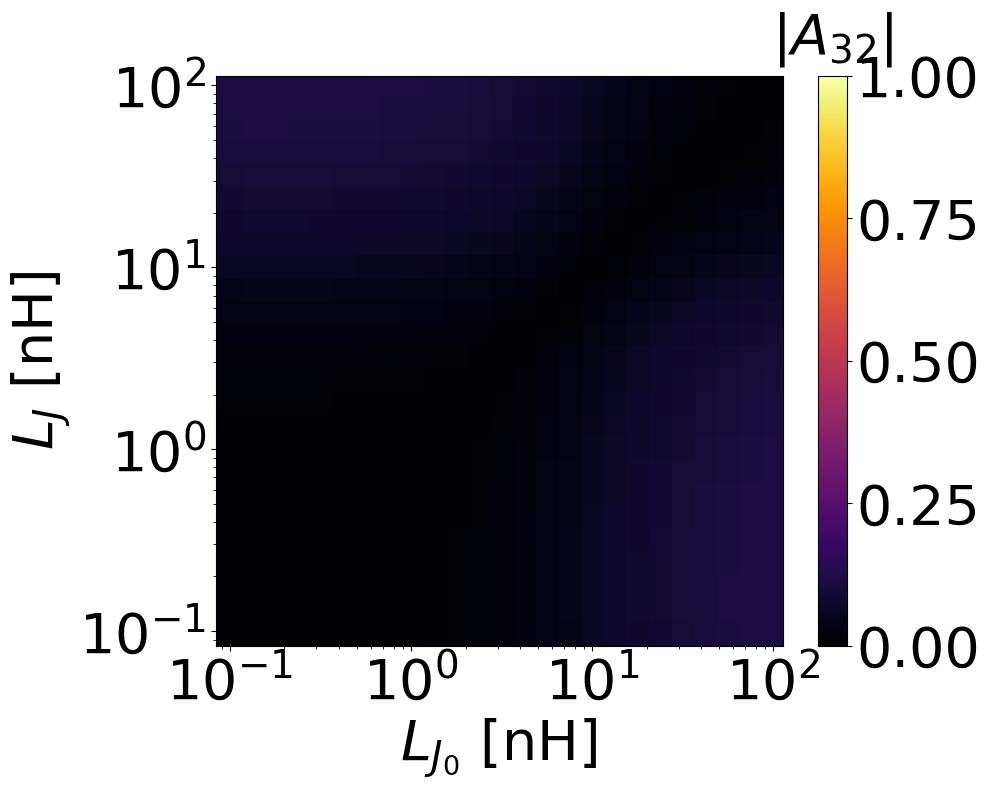

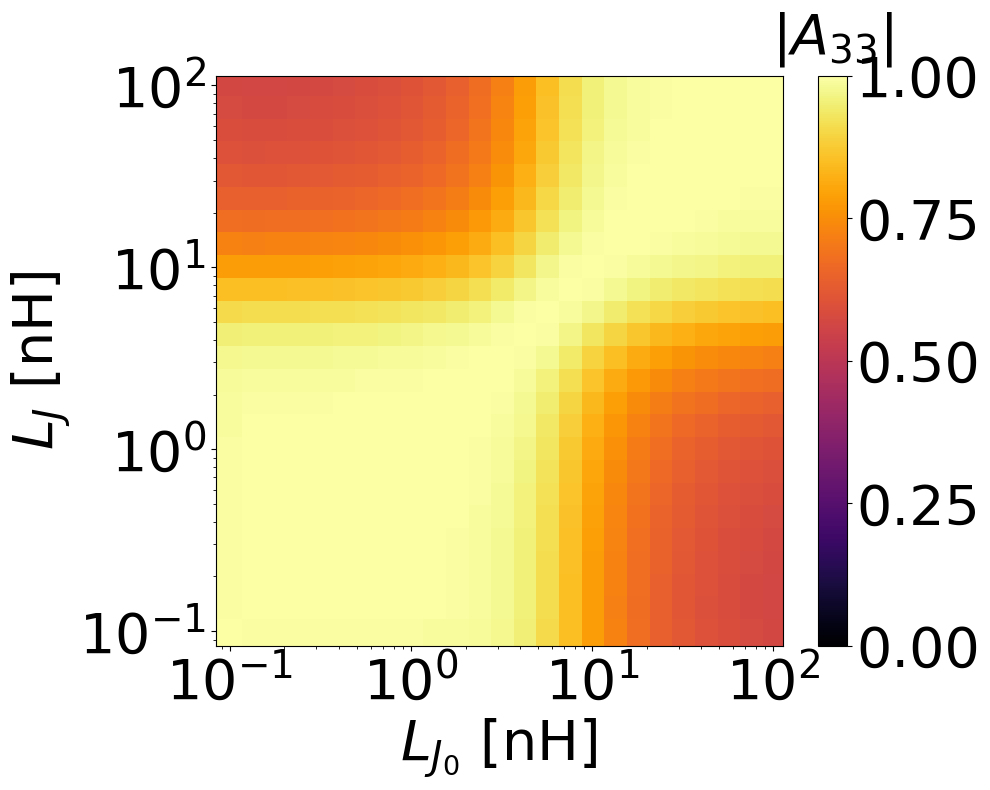

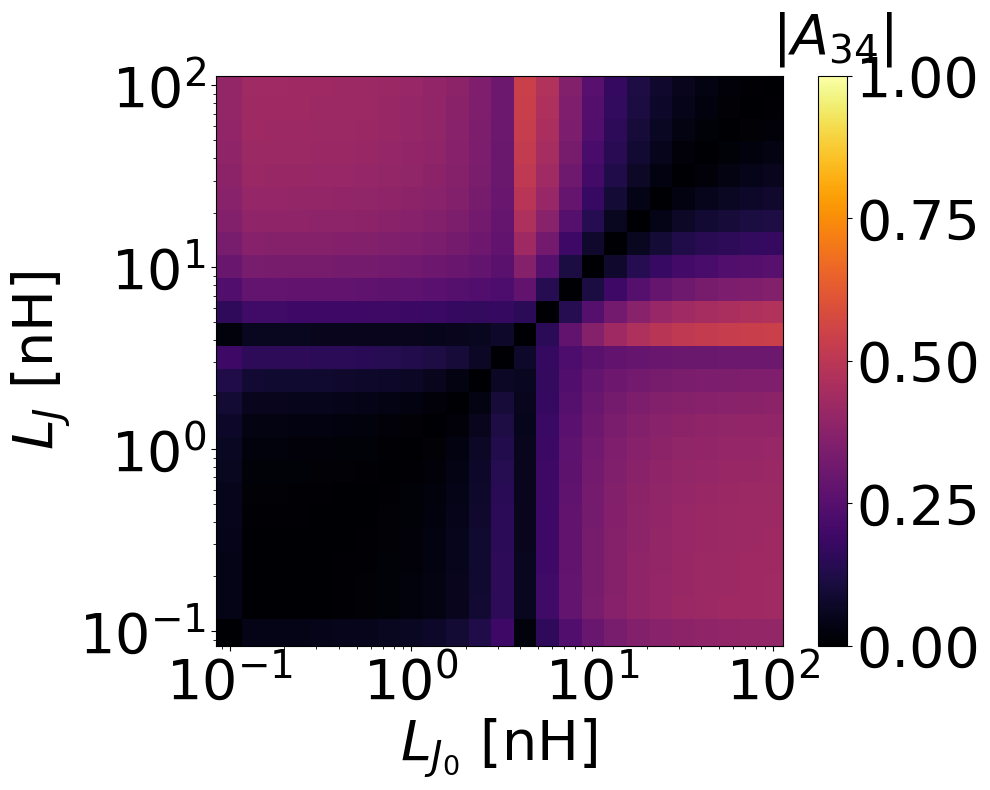

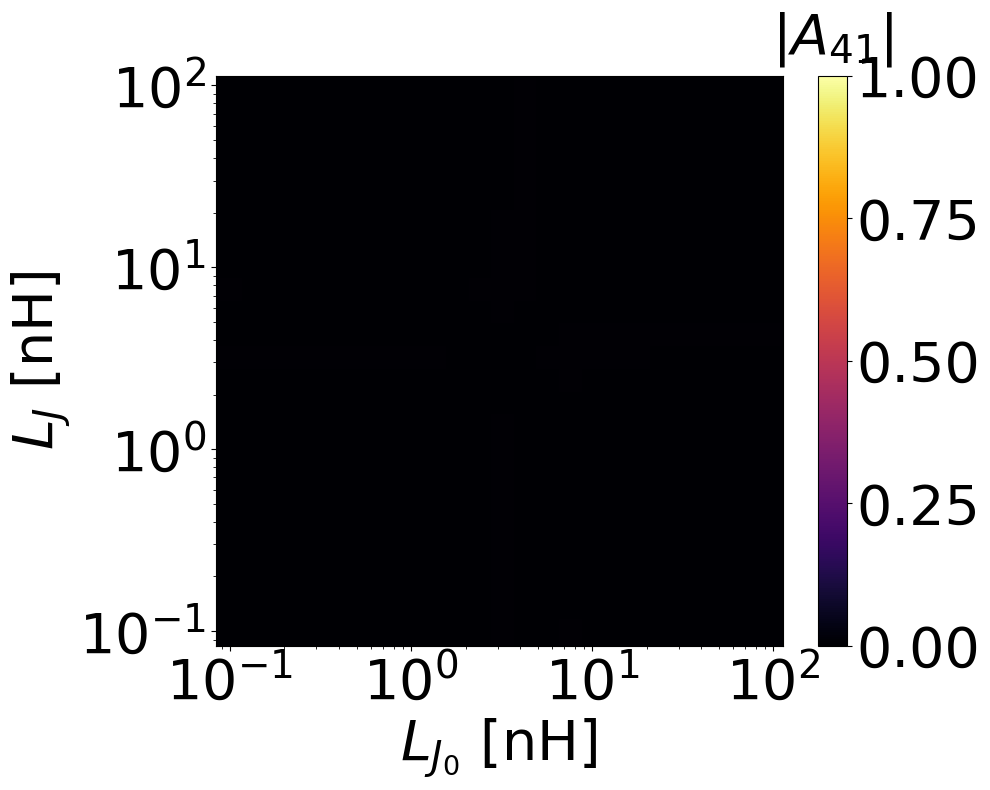

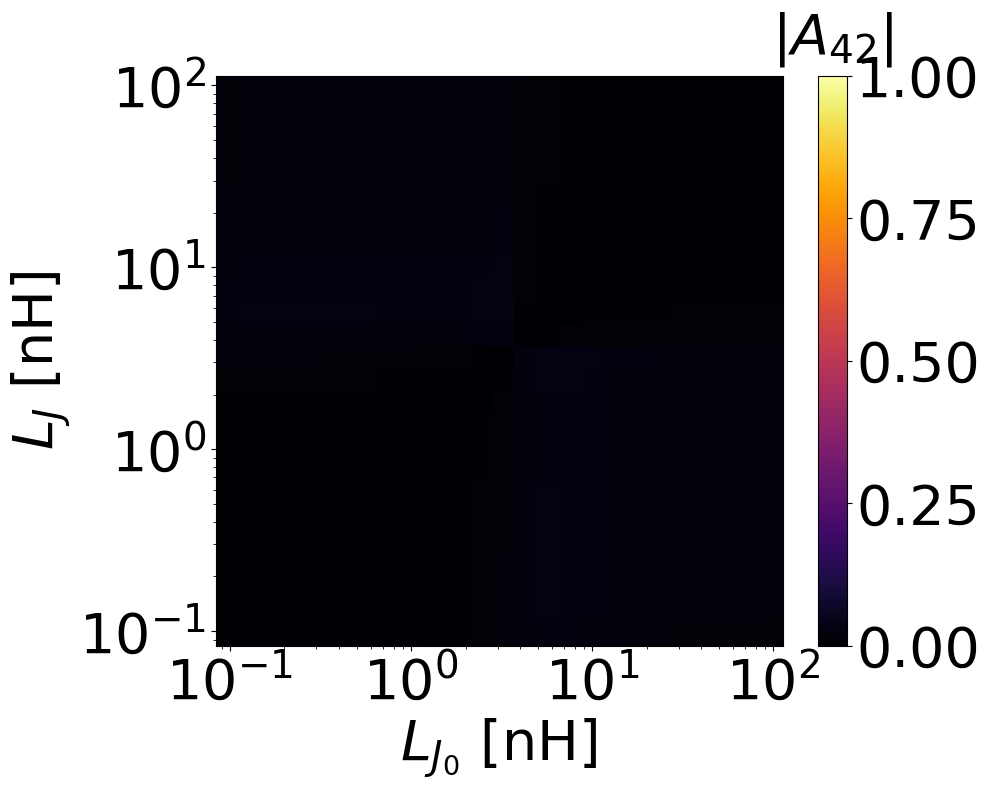

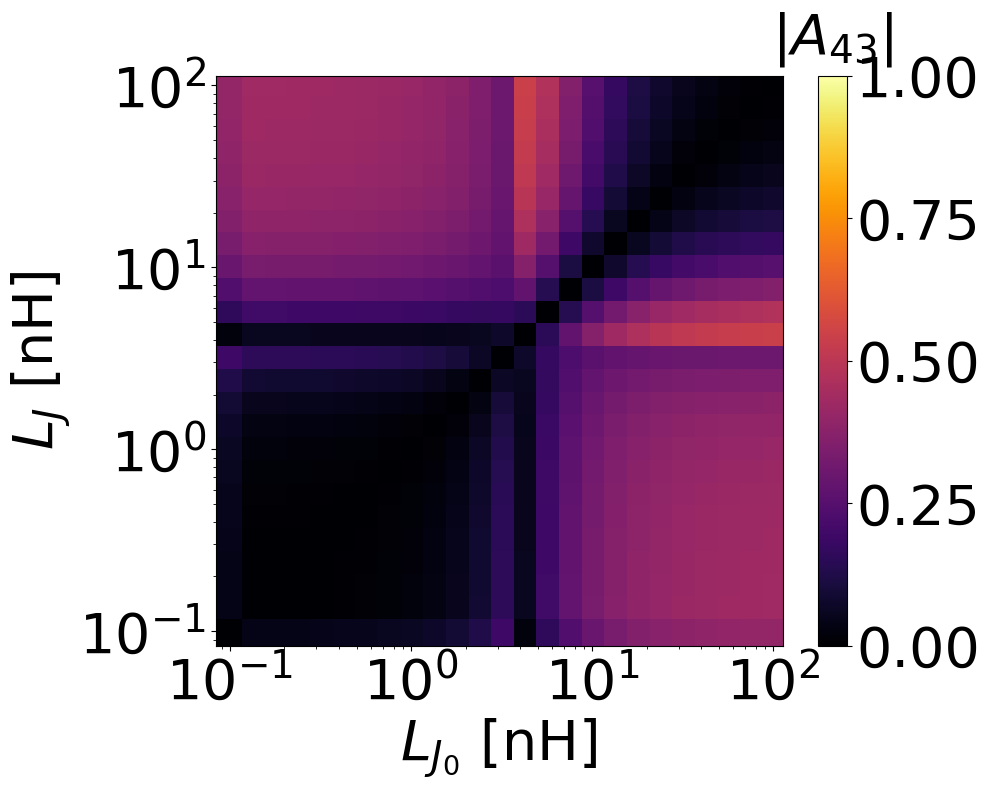

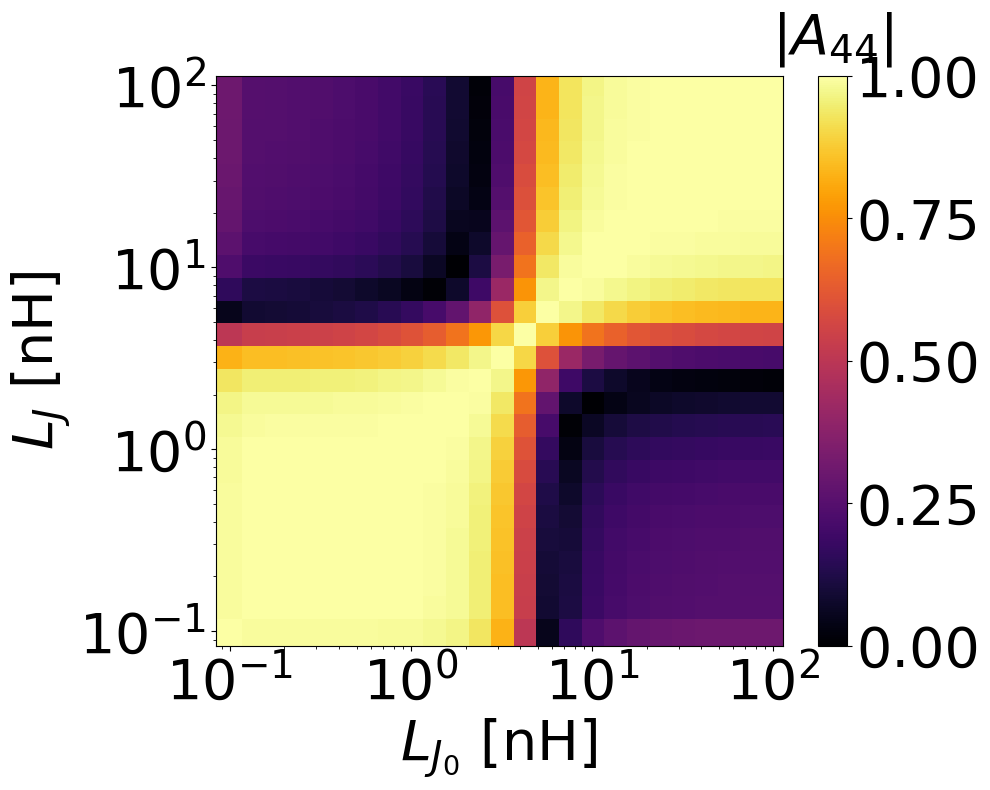

In [292]:
for k1 in [1, 2, 3, 4]:
    for k2 in [1, 2, 3, 4]:

        Akk12 = np.array([[Akkp[f'kkp{k1}_{k2}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'] \
                           for idx in range(len(Lj_vals))] \
                           for idx0 in range(len(Lj_vals))])
        
        
        plot_2d_cmap(
            Lj_vals,
            Lj_vals,
            np.abs(Akk12),
            f'../figs/A{k1}_{k2}_mag_remesh2_vs_LJLJ0_{dd}.pdf',
            xstr=r'$L_{J_0}$ [nH]',
            ystr=r'$L_{J}$ [nH]',
            tstr='',
            xyscales={'x' : 'log', 'y' : 'log'},
            cbar_str=r'$|A_{%d%d}|$' % (k1, k2),
            interp_zeros=False,
            interp_std_dev=3,
            image_rot_angle=0,
            norm_type='ref',
            zref=[0, Amax],
            fsize=40,
            tsize=46)

In [293]:
wmax = np.max(np.array(list(wkt.values())))
wmin = np.min(np.array(list(wkt.values())))

In [294]:
wmax

9.643974592709897

In [295]:
wmin

0.2620733444893086

Writing ../figs/w_1_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/w_2_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/w_3_remesh2_sorted_vs_LJLJ0_230120.pdf ...
Writing ../figs/w_4_remesh2_sorted_vs_LJLJ0_230120.pdf ...


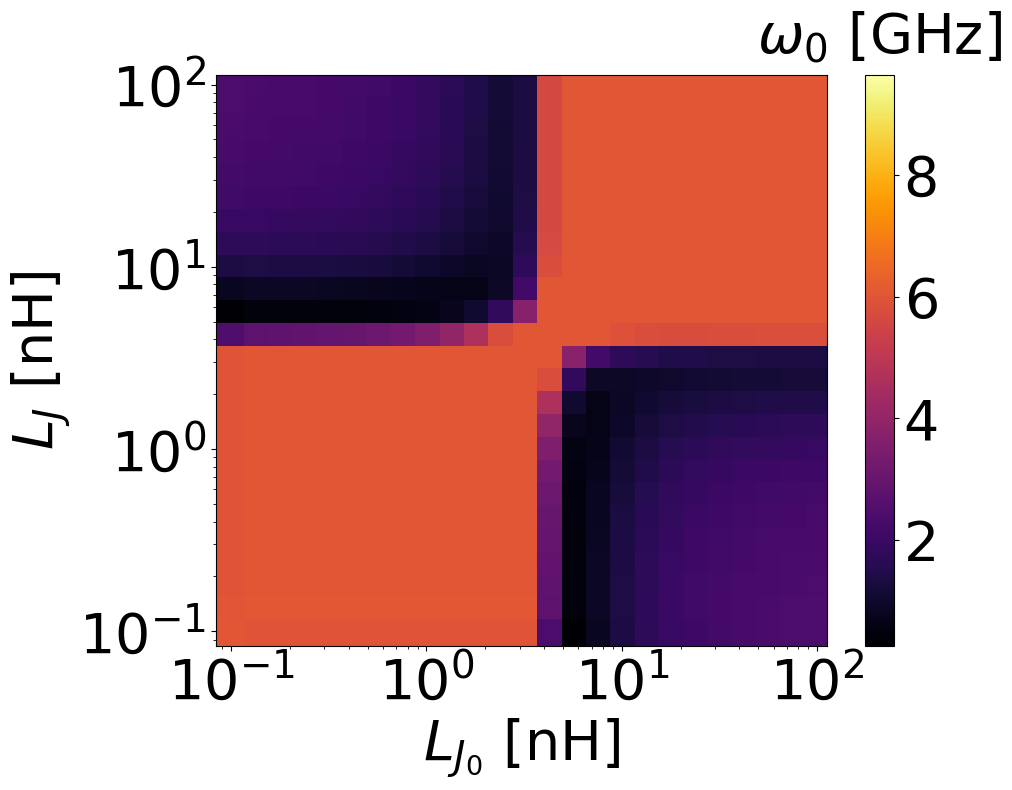

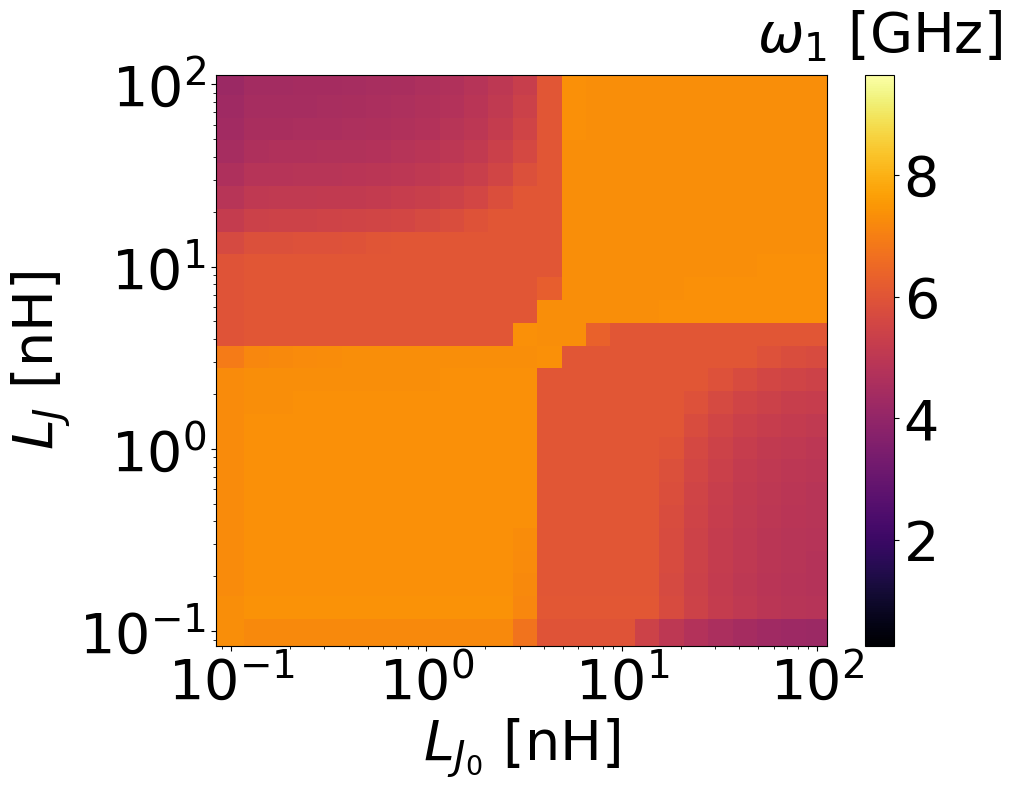

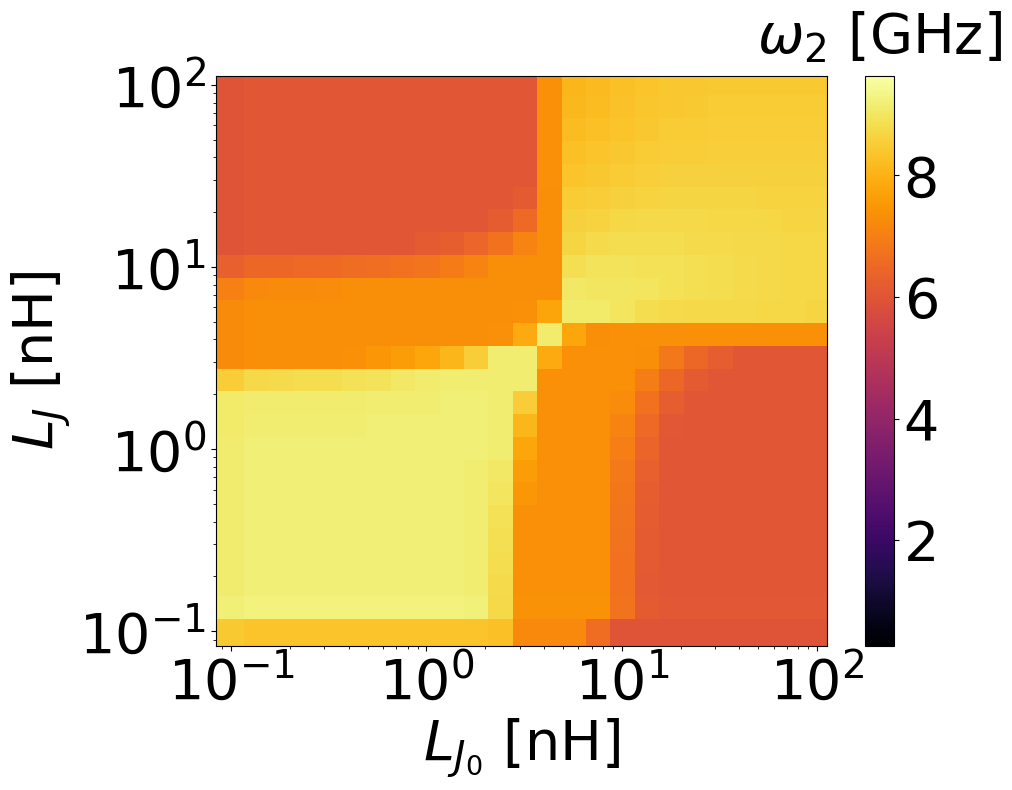

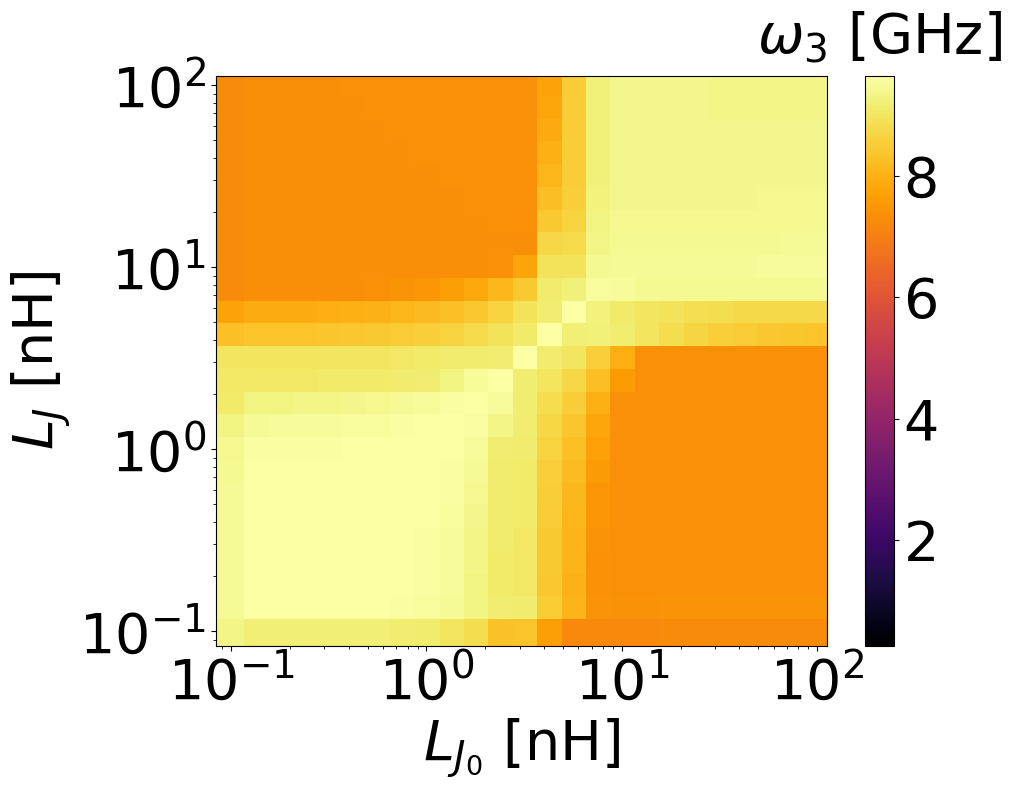

In [296]:
#plot_2d_cmap(ydata/ymax,
#    zdata/zmax,
# for k1 in [1,2,3,4]:
for k1 in range(Nmodes):
        # wkk12 = np.array([[wkt[f'kkp{k1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'] \
        #                   for idx in range(len(Lj_vals))] \
        #                   for idx0 in range(len(Lj_vals))])
        plot_2d_cmap(# LJs/1e-9,
            Lj_vals,
            Lj_vals,
            #wkk12,
            wkt_matrix_sorted[k1, :, :],
            # f'../figs/w_{k1}_vs_LJLJ0_{dd}.pdf',
            f'../figs/w_{k1+1}_remesh2_sorted_vs_LJLJ0_{dd}.pdf',
            xstr=r'$L_{J_0}$ [nH]',
            ystr=r'$L_{J}$ [nH]',
            tstr='',
            xyscales={'x' : 'log', 'y' : 'log'},
            cbar_str=r'$\omega_{%d}$ [GHz]' % (k1),
            interp_zeros=False,
            interp_std_dev=3,
            image_rot_angle=0,
            norm_type='ref',
            zref=[wmin, wmax],
            fsize=40,
            tsize=46)

## Compute the derivatives to estimate the driven coupling strengths

Writing ../figs/eps_1_2_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/eps_1_3_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/eps_1_4_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/eps_2_1_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/eps_2_3_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/eps_2_4_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/eps_3_1_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/eps_3_2_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/eps_3_4_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/eps_4_1_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/eps_4_2_remesh2_vs_LJLJ0_230120.pdf ...
Writing ../figs/eps_4_3_remesh2_vs_LJLJ0_230120.pdf ...


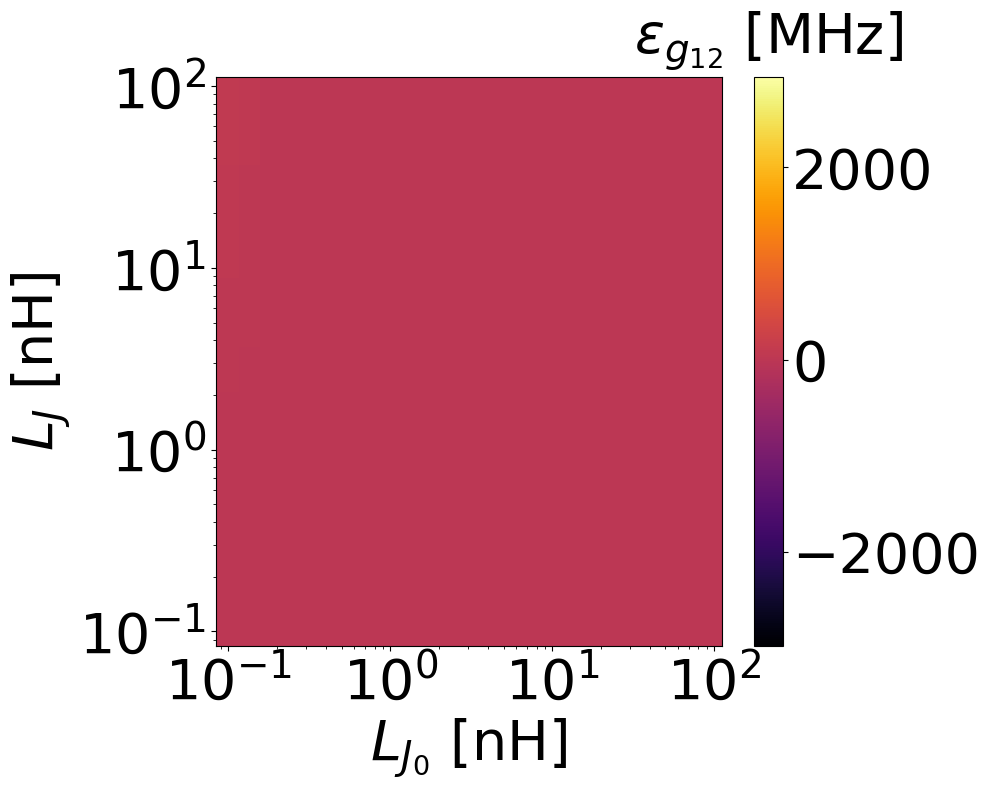

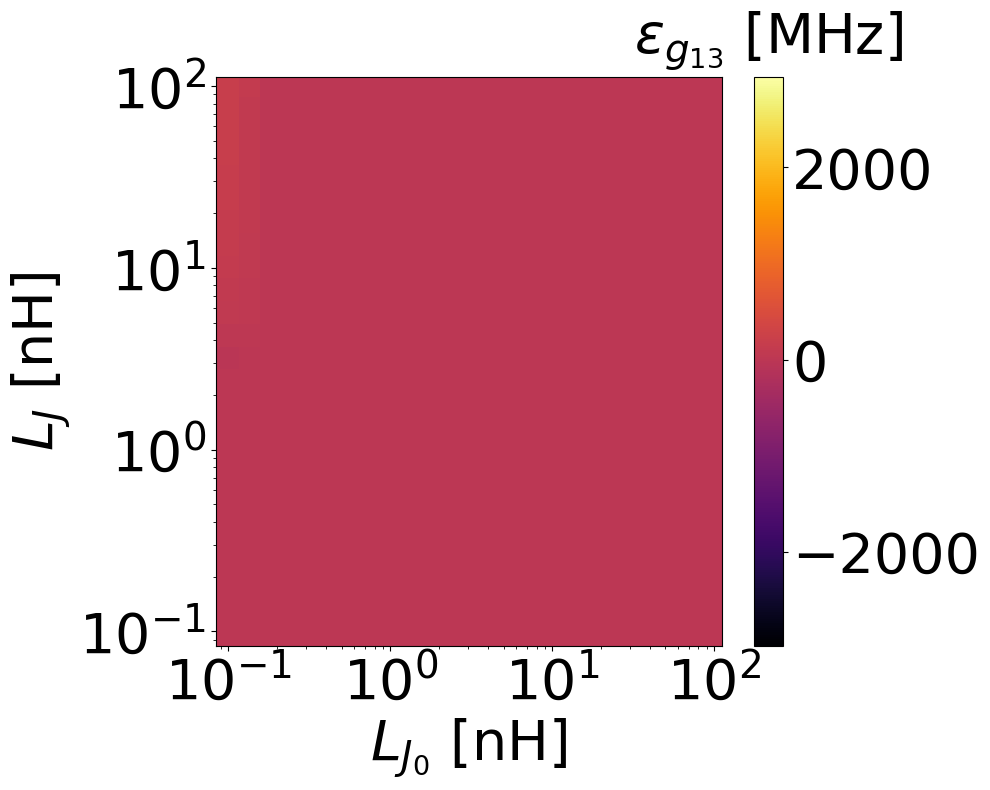

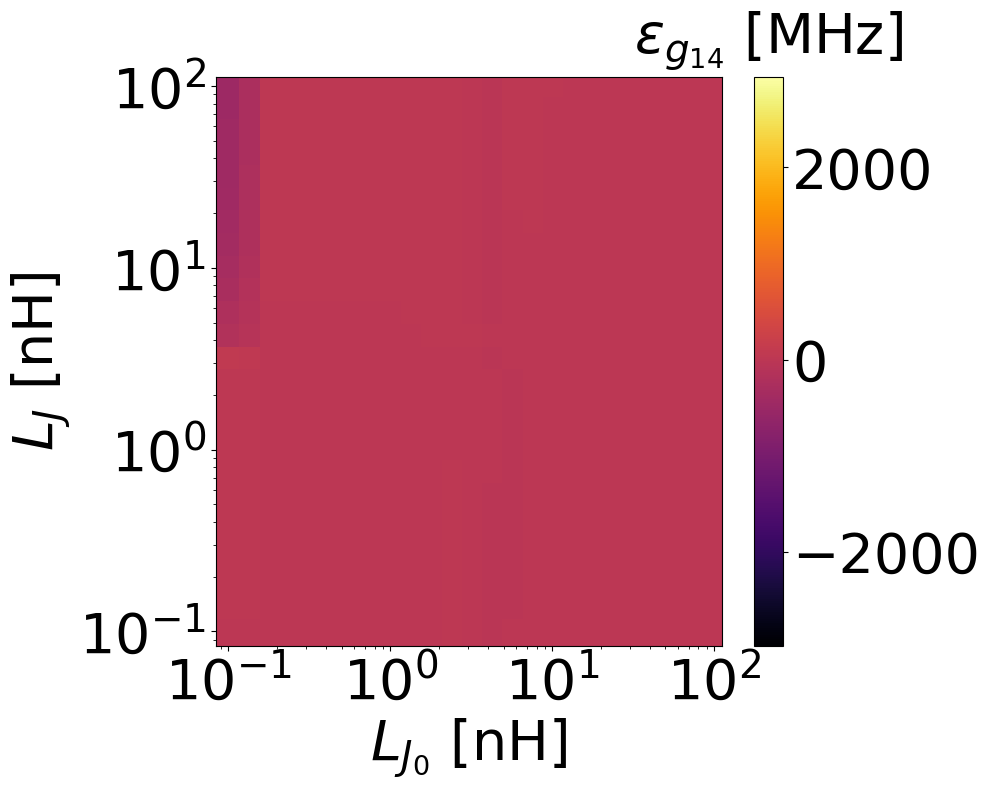

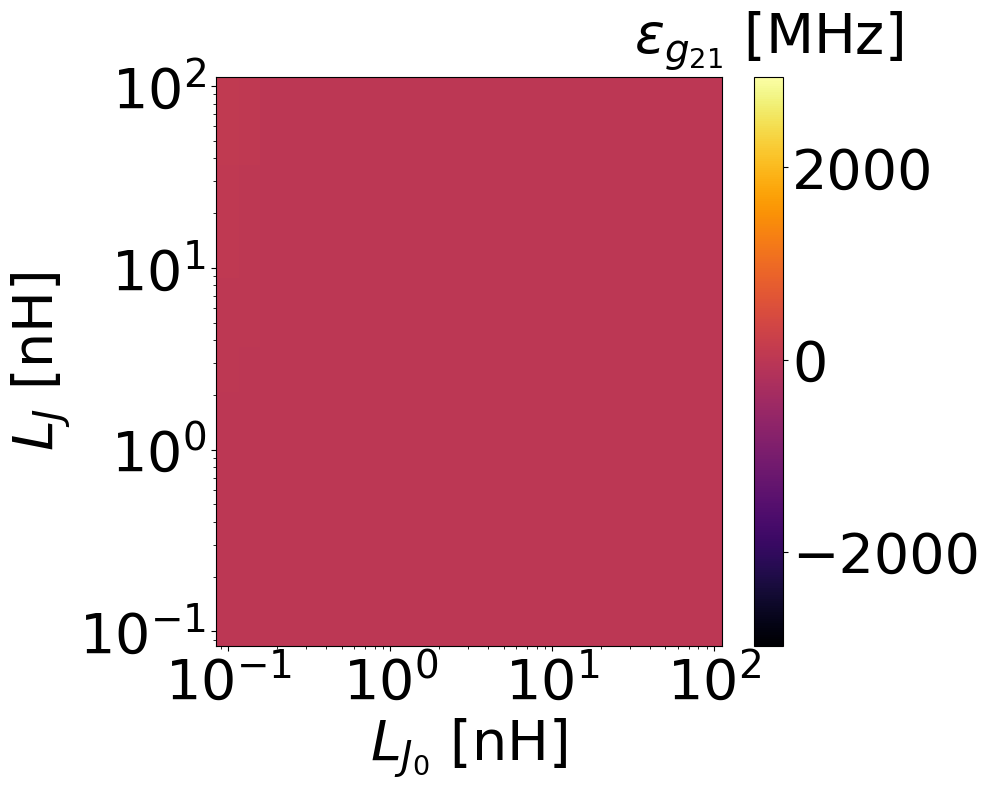

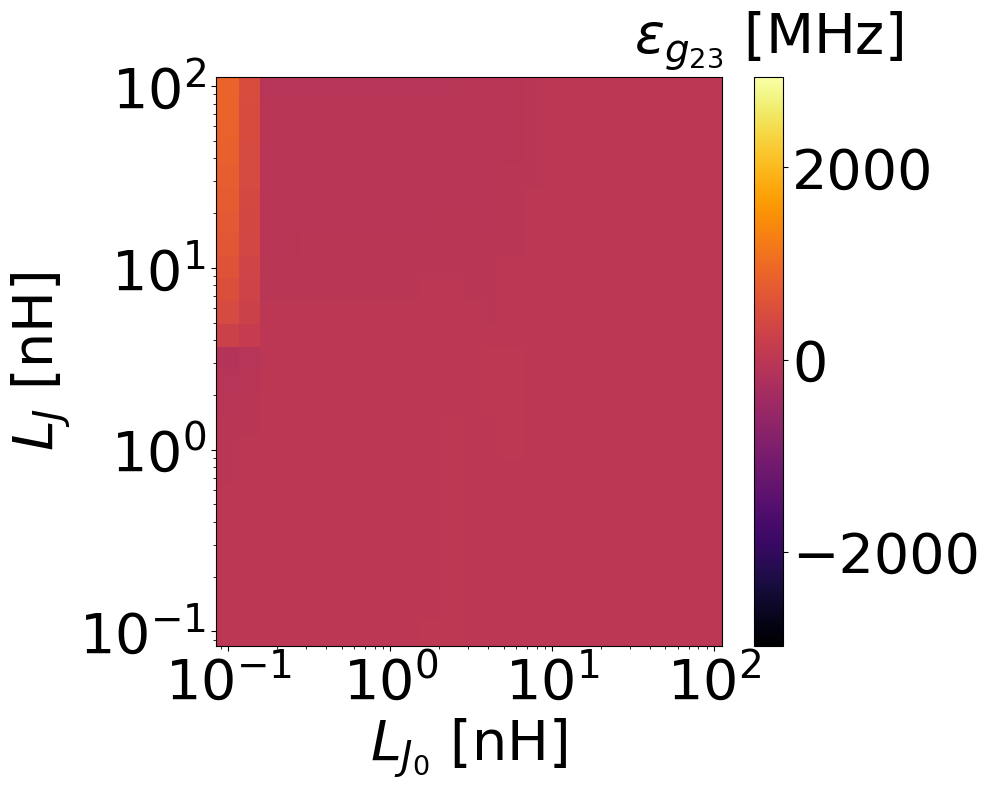

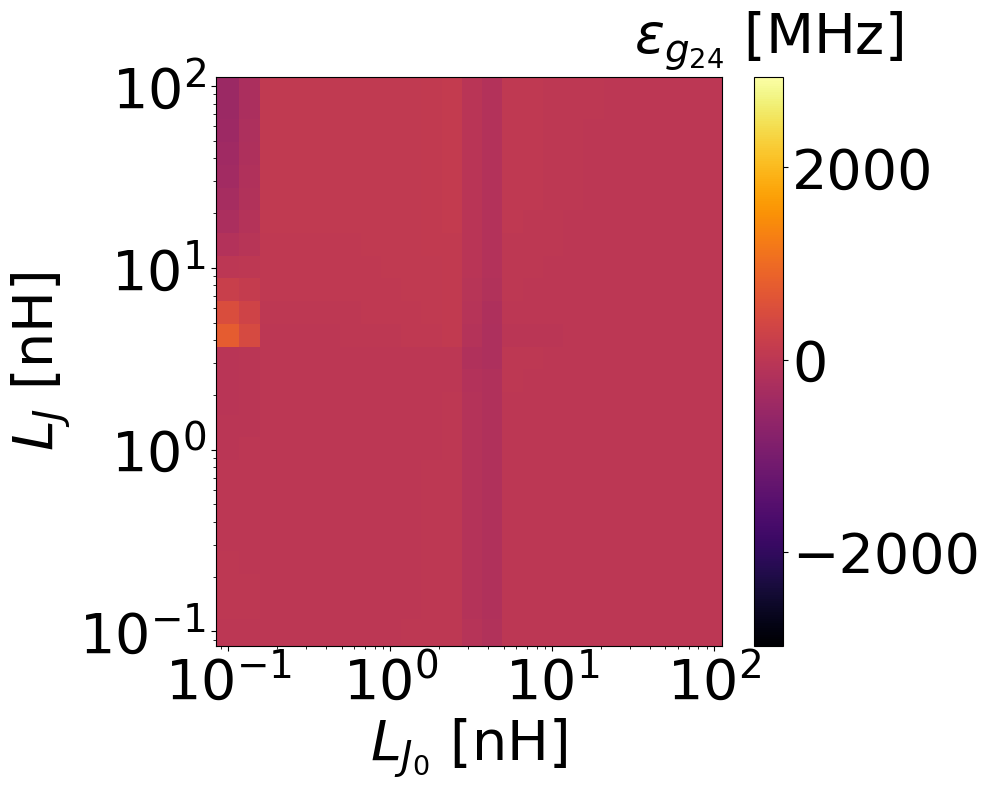

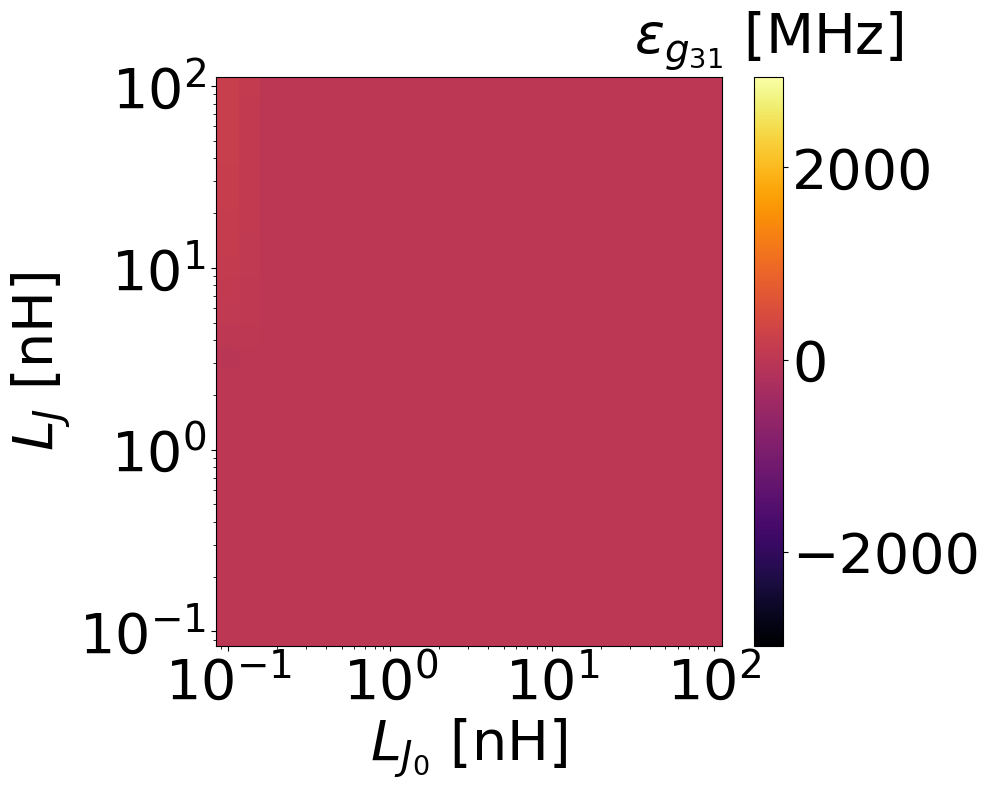

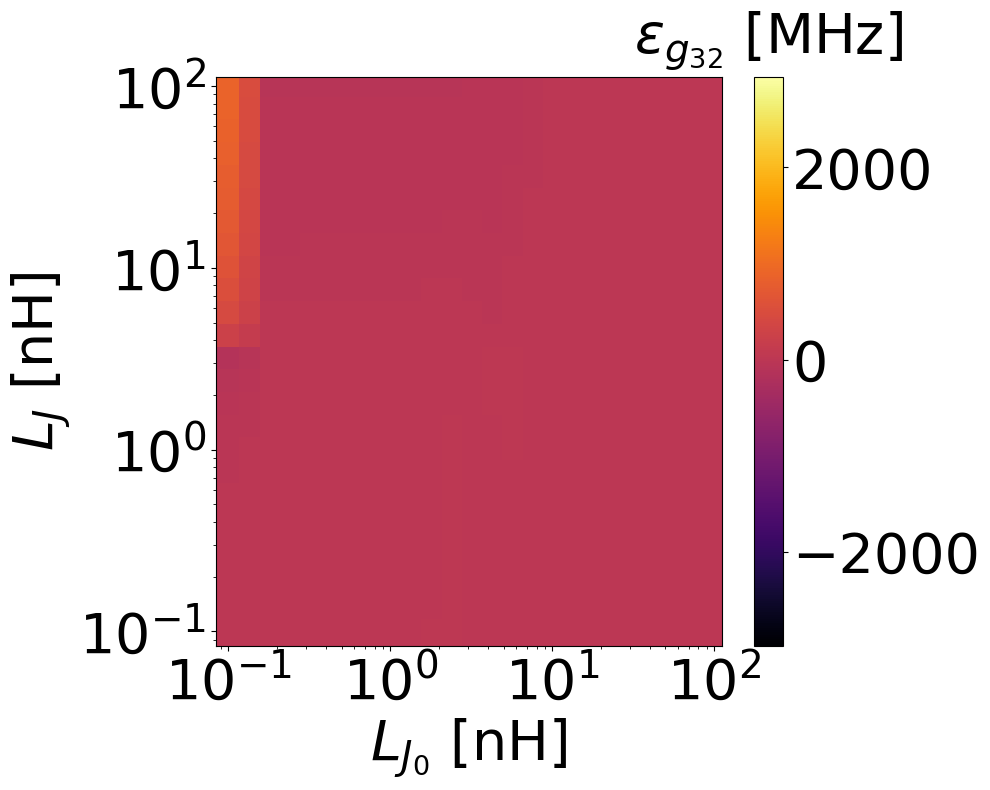

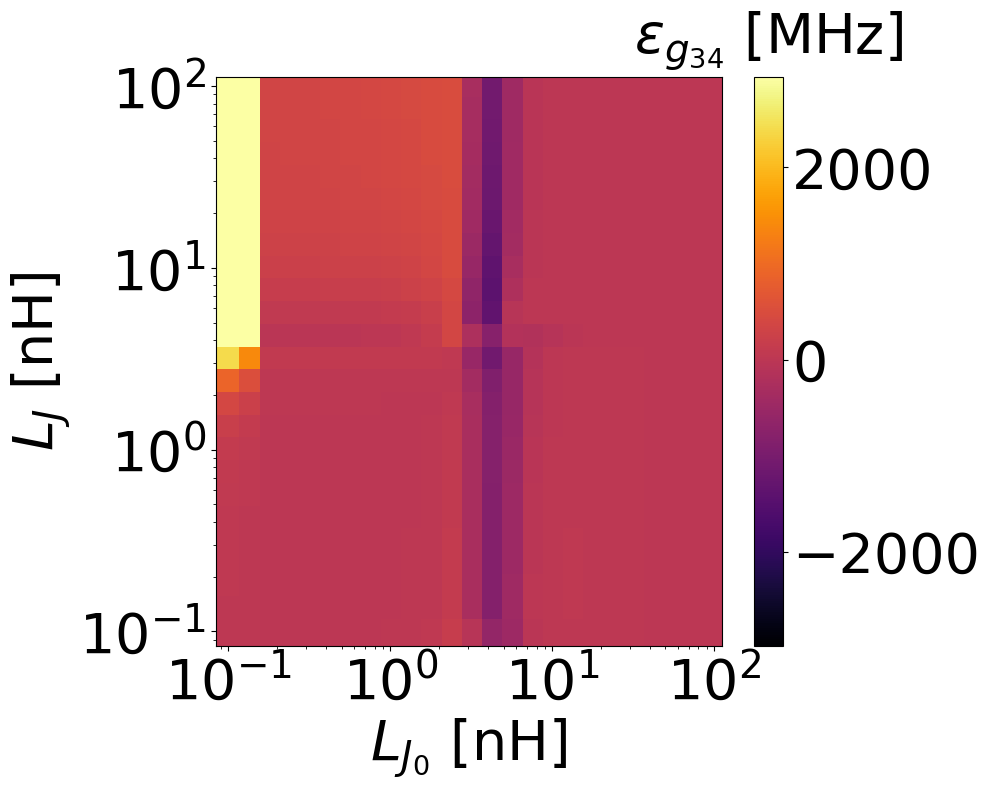

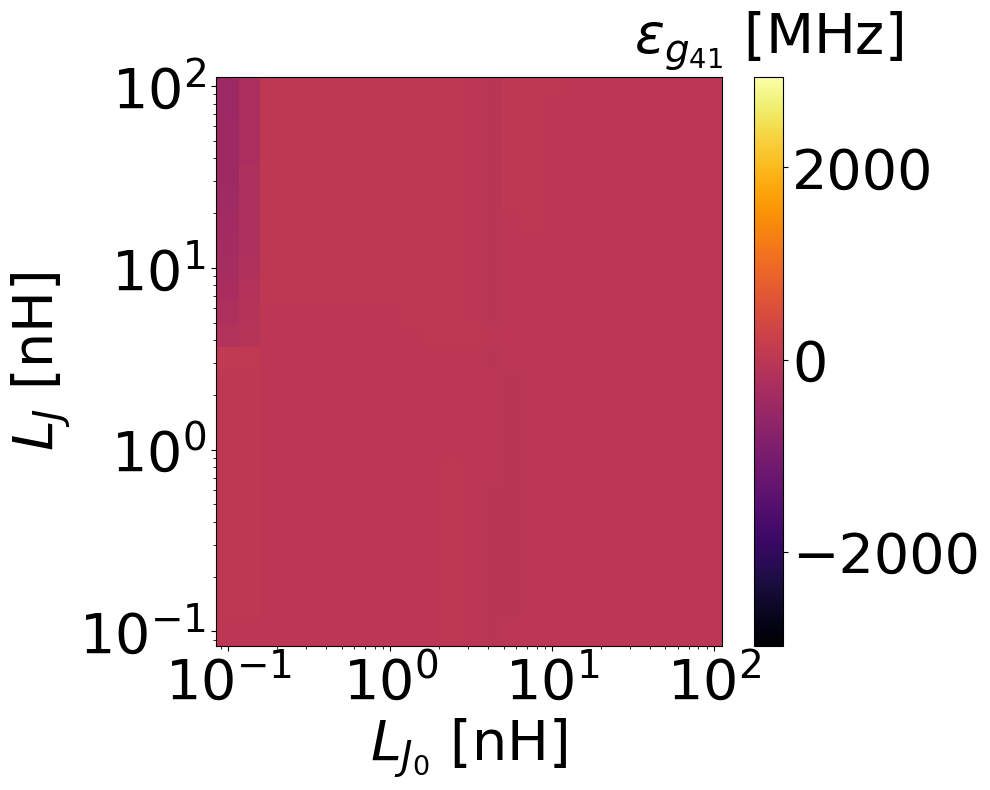

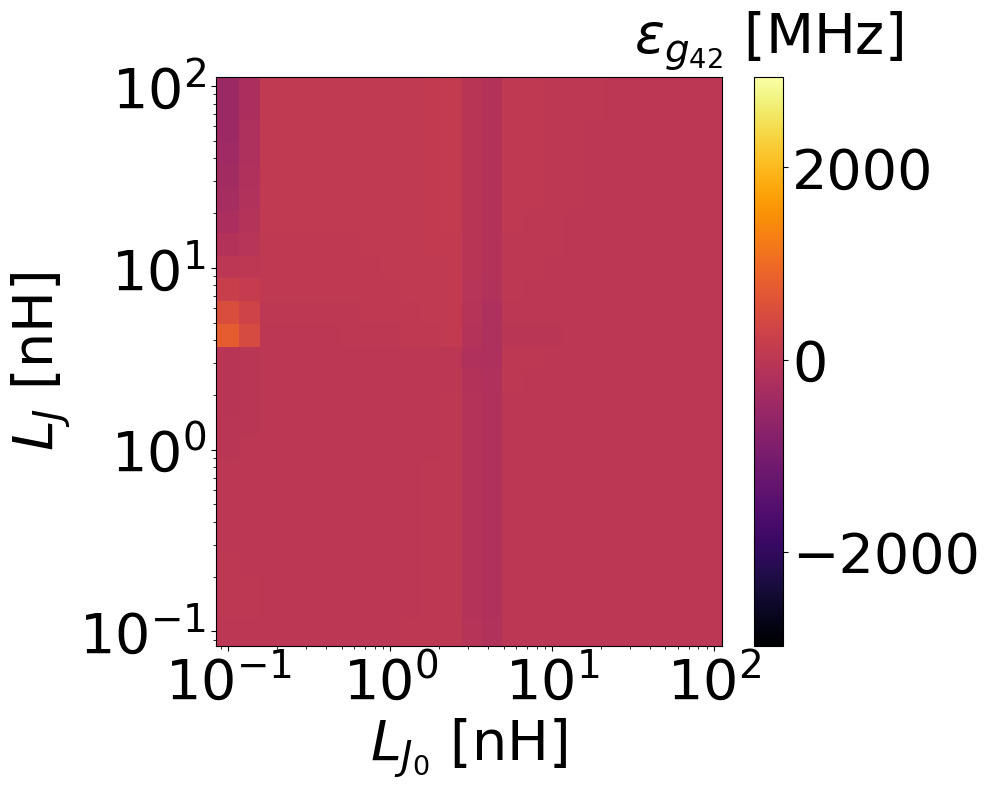

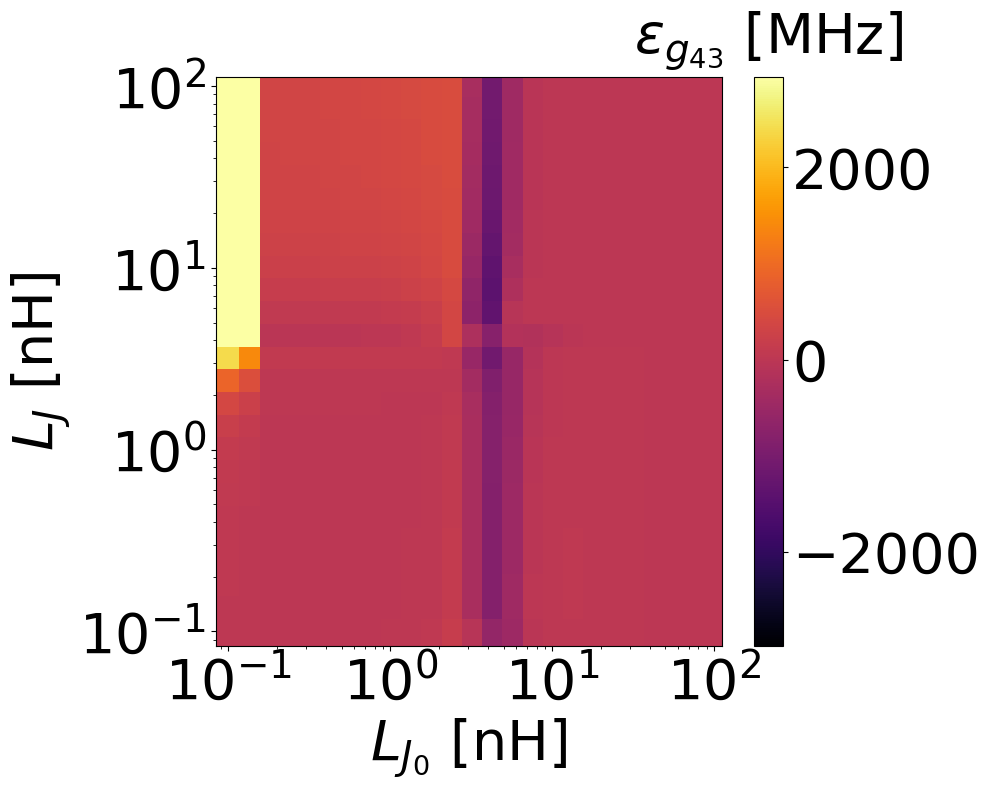

In [297]:
dLJ = 1 # 10 nH as a possible driving point
for k1 in [1,2,3,4]:
    for k2 in [1, 2, 3, 4]:
        if k1 != k2:
            gkk12 = np.array([[gkk[f'kkp{k1}_{k2}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'] \
                               for idx in range(len(Lj_vals))] \
                               for idx0 in range(len(Lj_vals))])
            gkk12_grad = np.array([np.gradient(gkk12[:, j], Lj_vals) for j in range(len(Lj_vals))])
            epskk = gkk12_grad * dLJ * 1e3
            # Write the results to file
            plot_2d_cmap(# LJs/1e-9,
            Lj_vals,
            Lj_vals,
            epskk,
            f'../figs/eps_{k1}_{k2}_remesh2_vs_LJLJ0_{dd}.pdf',
            xstr=r'$L_{J_0}$ [nH]',
            ystr=r'$L_{J}$ [nH]',
            tstr='',
            xyscales={'x' : 'log', 'y' : 'log'},
            cbar_str=r'$\epsilon_{g_{%d %d}}$ [MHz]' % (k1, k2),
            interp_zeros=False,
            interp_std_dev=3,
            image_rot_angle=0,
            norm_type='ref',
            zref=[gmin, gmax],
            fsize=40,
            tsize=46)

## Plot $g_{12}$ for a fixed $L_{J_0}$

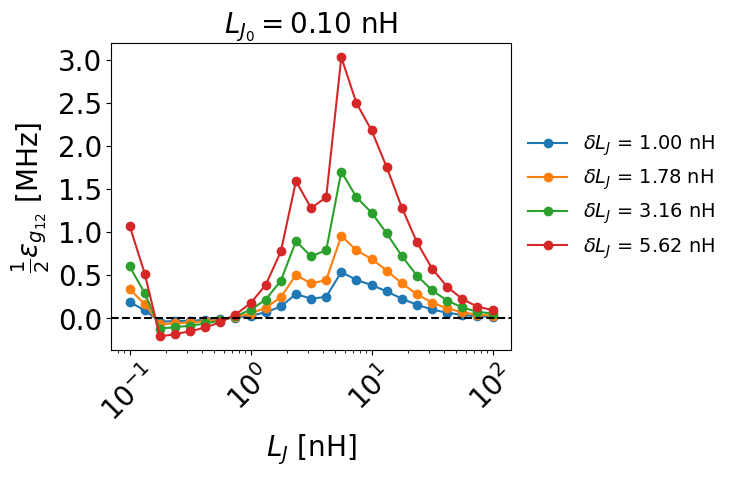

In [382]:
LJidx0 = 0
dLJ = 10 # 10 nH as a possible driving point
k1 = 1; k2 = 2

fig, ax = plt.subplots(1, 1, tight_layout=True)
dstr = datetime.datetime.today().strftime('%y%m%d')
fsize = 20
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
idx_start = 4
cidx = 0
for idx0 in [8, 10, 12, 14]:
    gkk12 = np.array([gkk[f'kkp{k1}_{k2}_LJLJp_{Ljstrs[idx]}_{Ljstrs[LJidx0]}'] \
                               for idx in range(len(Lj_vals))])
    gkk12_grad = np.gradient(gkk12, Lj_vals)
    epskk = gkk12_grad * Lj_vals[idx0] * 1e3
    ax.plot(Lj_vals, epskk / 2,
        'o-', color=cycle[cidx%clen],
           label=r'$\delta L_{J}$ = %.2f nH' % Lj_vals[idx0])
    cidx += 1

ax.axhline(y=0, color='k', ls='--')
ax.set_title(r'$L_{J_0} = %.2f$ nH' % Lj_vals[LJidx0],
             fontsize=fsize)
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$\frac{1}{2}\epsilon_{g_{%d%d}}$ [MHz]' % (k1, k2), fontsize=fsize)
set_xaxis_rot(ax, 45)
#ax.set_ylim([-0.5, 1.5])
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
leg = set_leg_outside(ax, lsize)
fig.savefig(f'../figs/epsg_{k1}{k2}_bbq_1_10_100nH_remesh2_{dstr}.pdf', 
            bbox_extra_artists=(leg, ), bbox_inches='tight',
            format='pdf', transparent=True)

## Combine the geometric mean and field analysis data

In [8]:
def load_ydata_from_txt(filenames, delimiter=','):
    fdata = np.array([])
    ydata = np.array([], dtype=complex)
    # Iterate over all discrete frequency sweeps
    for fname in filenames:
        print(f'Reading {fname} ...')
        data = np.genfromtxt(fname, delimiter=delimiter).T
        f   = data[0]
        yre = data[1]
        yim = data[2]

        fdata = np.hstack((fdata, f))
        ydata = np.hstack((ydata, yre + 1j*yim))
    return fdata, ydata

In [9]:
filenames = [f'../data/ydata_230110_sweep_{i}.csv' for i in range(21)]
fdata1, ydata1 = load_ydata_from_txt(filenames)
filenames = [f'../data/ydata_230210_sweep_{i}.csv' for i in range(21)]
fdata2, ydata2 = load_ydata_from_txt(filenames)

Reading ../data/ydata_230110_sweep_0.csv ...
Reading ../data/ydata_230110_sweep_1.csv ...
Reading ../data/ydata_230110_sweep_2.csv ...
Reading ../data/ydata_230110_sweep_3.csv ...
Reading ../data/ydata_230110_sweep_4.csv ...
Reading ../data/ydata_230110_sweep_5.csv ...
Reading ../data/ydata_230110_sweep_6.csv ...
Reading ../data/ydata_230110_sweep_7.csv ...
Reading ../data/ydata_230110_sweep_8.csv ...
Reading ../data/ydata_230110_sweep_9.csv ...
Reading ../data/ydata_230110_sweep_10.csv ...
Reading ../data/ydata_230110_sweep_11.csv ...
Reading ../data/ydata_230110_sweep_12.csv ...
Reading ../data/ydata_230110_sweep_13.csv ...
Reading ../data/ydata_230110_sweep_14.csv ...
Reading ../data/ydata_230110_sweep_15.csv ...
Reading ../data/ydata_230110_sweep_16.csv ...
Reading ../data/ydata_230110_sweep_17.csv ...
Reading ../data/ydata_230110_sweep_18.csv ...
Reading ../data/ydata_230110_sweep_19.csv ...
Reading ../data/ydata_230110_sweep_20.csv ...
Reading ../data/ydata_230210_sweep_0.csv ...

In [10]:
def get_wp_Cp_Lp(f, y, LJ0=10e-9, CJ0=2e-15, fscale=1e9, use_Zq=False,
                GJ0=7.748e-10):
    """
    Converts frequency-dependent imaginary parts
    of the admittance data to poles,
    capacitances, and inductances
    """
    # Add the junction inductance and capacitance to the
    # total admittance
    # Compute the zero crossings
    fcpy = np.copy(f * fscale)
    ycpy = np.copy(np.complex128(y))
    if LJ0:
        ycpy += (1. / (1j * fcpy * 2 * np.pi * LJ0)) \
          + 1j * fcpy * 2 * np.pi * CJ0
    if LJ0 and GJ0:
        ycpy += (1. / (1j * fcpy * 2 * np.pi * LJ0)) \
             + 1j * fcpy * 2 * np.pi * CJ0 \
             + GJ0
    yim = ycpy.imag
    zero_xing_idxs = np.where(np.diff(np.sign(yim))>0)[0]
    wp = 2 * np.pi * fcpy[zero_xing_idxs]
    yp = yim[zero_xing_idxs]

    # Compute the capacitances from the derivatives
    ypp = np.gradient(ycpy, 2*np.pi*(fcpy[1]-fcpy[0]))
    Cp = 0.5 * np.abs(ypp.imag[zero_xing_idxs])
    Lp = 1. / (wp**2 * Cp)
    Zp = np.sqrt(Lp / Cp)
    Rp = 1. / np.abs(np.real(ycpy[zero_xing_idxs]))
    Qp = wp * Rp * Cp
    
    # Physical constants
    h    = 6.62607015e-34 
    hbar = h / (2 * np.pi)
    e    = 1.602176634e-19
    Phi0 = h / (2 * e)
    
    # Compute Ej, Ec
    if LJ0 and CJ0:
        # Compute the Josephson inductive and charging energies
        Ej = (Phi0 / (2 * np.pi))**2 / LJ0
        Ec = e**2 / (2 * CJ0)

        # Compute inductive energies, EL
        EL = 0.5 * Phi0**2 / Lp

        # Compute the phase zero point fluctuations
        GQ = 2 * e**2 / h
        phip2 = 2 * np.pi * GQ * Zp

        # Compute the participations
        # p = phi2 * 2 * Ej / (hbar * wp)
        pl = Lp / LJ0
        pc = Cp / CJ0

        # Compute the gs / Ds
        Zq = np.sqrt(LJ0 / CJ0)
        gD = np.sqrt(Zp / Zq)

        # Compute the g's in units of Hz, divide by h to get v, Ej = hv
        gpq = (2 * np.pi * GQ * Ej / 24.) * sum(phip2) * np.asarray([[
            np.sqrt(Zpp * Zqq) / h for p, Zpp in enumerate(Zp)]
                               for q, Zqq in enumerate(Zp) ])
        gpq = gpq.reshape([len(gpq), len(gpq)])
        
        # Compute the chis, anharmonicities
        # In units of Hz
        chipp  = -Ec * gD**2 / h
        chippp = np.asarray([-2 * np.sqrt(chipp[p] * chipp[q]) 
                             for p in range(len(chipp))
                             for q in range(len(chipp))])
        chippp = chippp.reshape([len(chipp), len(chipp)])

        return wp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gpq, chippp
    
    else:
        return wp, Lp, Cp, Qp, fcpy, ycpy, yp, None, None, None, None

In [54]:
def get_bbq_params(fdata, ydata, NLJ=25, Nmodes=6, fscale=1e9):
    wps = []
    pcs = []
    pls = []
    gDs = []
    Cps = []
    Lps = []
    Qps = []
    chis = []

    # Whether or not to use the largest impedance mode
    # as the junction mode in the calculations
    use_Zq = False
    print_results = True

    LJs = np.logspace(np.log10(0.1e-9), np.log10(1000e-9), NLJ)
    LJs = np.logspace(np.log10(0.1e-9), np.log10(100e-9), NLJ)
    LJ0 = 10e-9
    #for idx, x in enumerate(xdata):
    for LJ in LJs:
        wpp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gD, chip \
        = get_wp_Cp_Lp(fdata, ydata, LJ0=LJ, fscale=fscale, use_Zq=use_Zq)
        wps.append(np.sort(wpp[0:Nmodes]))
        #wps.append(wpp[0:Nmodes])
        pls.append(pl[0:Nmodes])
        pcs.append(pc[0:Nmodes])
        gDs.append(gD[0:Nmodes, 0:Nmodes])
        Lps.append(Lp[0:Nmodes])
        Cps.append(Cp[0:Nmodes])
        Qps.append(Qp[0:Nmodes])
        chis.append(chip[0:Nmodes, 0:Nmodes])
        if print_results:
            print(f'wps: {wps}')
        # wps.append(wpp)
        # print(f'LJ: {LJ}, wpp: {wpp}')
    wps = np.asarray(wps).T
    pls  = np.asarray(pls).T
    pcs  = np.asarray(pls).T
    gDs = np.asarray(gDs).T
    Lps = np.asarray(Lps).T
    Cps = np.asarray(Cps).T
    Qps = np.asarray(Qps).T
    chis = np.asarray(chis).T

    return wps, pls, pcs, gDs, Lps, Cps, Qps, chis

In [55]:
wps1, pls1, pcs1, gDs1, Lps1, Cps1, Qps1, chis1 = get_bbq_params(fdata1, ydata1, Nmodes=4)
wps2, pls2, pcs2, gDs2, Lps2, Cps2, Qps2, chis2 = get_bbq_params(fdata2, ydata2, Nmodes=5)

wps: [array([3.70836086e+10, 3.73498336e+10, 5.60907844e+10, 5.66727307e+10])]
wps: [array([3.70836086e+10, 3.73498336e+10, 5.60907844e+10, 5.66727307e+10]), array([3.70834273e+10, 3.73496523e+10, 5.60875210e+10, 5.66723681e+10])]
wps: [array([3.70836086e+10, 3.73498336e+10, 5.60907844e+10, 5.66727307e+10]), array([3.70834273e+10, 3.73496523e+10, 5.60875210e+10, 5.66723681e+10]), array([3.70830647e+10, 3.73494710e+10, 5.60831698e+10, 5.66720055e+10])]
wps: [array([3.70836086e+10, 3.73498336e+10, 5.60907844e+10, 5.66727307e+10]), array([3.70834273e+10, 3.73496523e+10, 5.60875210e+10, 5.66723681e+10]), array([3.70830647e+10, 3.73494710e+10, 5.60831698e+10, 5.66720055e+10]), array([3.70828834e+10, 3.73492897e+10, 5.60271258e+10, 5.66712803e+10])]
wps: [array([3.70836086e+10, 3.73498336e+10, 5.60907844e+10, 5.66727307e+10]), array([3.70834273e+10, 3.73496523e+10, 5.60875210e+10, 5.66723681e+10]), array([3.70830647e+10, 3.73494710e+10, 5.60831698e+10, 5.66720055e+10]), array([3.70828834e+10

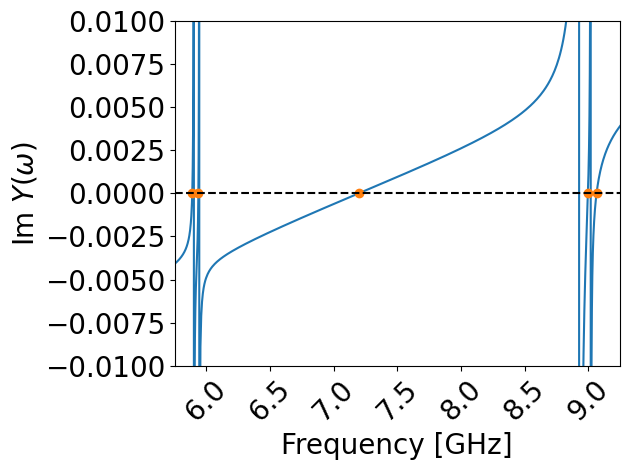

In [65]:
# Plot the results, save the figure(s)
fsize = 20
fscale = 1e9
dstr = datetime.datetime.today().strftime('%y%m%d')
wp1, _, _, _, _, _, yp1, _, _, _, _ = \
get_wp_Cp_Lp(fdata1, ydata1, LJ0=None, CJ0=None, fscale=1e9, use_Zq=False)

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(fdata1, ydata1.imag)
ax.plot(wp1/(2*np.pi*fscale), yp1.imag, 'o', label='Zero Crossings')
ax.set_ylabel(r'Im $Y(\omega)$', fontsize=fsize)
ax.set_xlabel(r'Frequency [GHz]', fontsize=fsize)
set_axes_fonts(ax, fsize)
set_xaxis_rot(ax, 45.)
ax.set_xlim([5.75, 9.25])
#ax.set_xlim([5.88, 5.95])
ax.set_ylim([-0.01, 0.01])
ax.axhline(y=0, color='k', ls='--')
fig.savefig(f'../figs/zeros_wa_{dstr}.pdf', format='pdf')

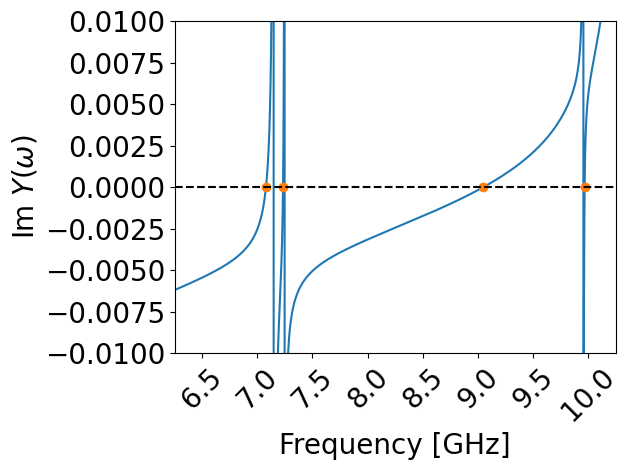

In [71]:
# Plot the results, save the figure(s)
fsize = 20
fscale = 1e9
dstr = datetime.datetime.today().strftime('%y%m%d')
wp2, _, _, _, _, _, yp2, _, _, _, _ = \
get_wp_Cp_Lp(fdata2, ydata2, LJ0=None, CJ0=None, fscale=1e9, use_Zq=False)

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(fdata2, ydata2.imag)
ax.plot(wp2/(2*np.pi*fscale), yp2.imag, 'o', label='Zero Crossings')
ax.set_ylabel(r'Im $Y(\omega)$', fontsize=fsize)
ax.set_xlabel(r'Frequency [GHz]', fontsize=fsize)
set_axes_fonts(ax, fsize)
set_xaxis_rot(ax, 45.)
ax.set_xlim([6.25, 10.25])
#ax.set_xlim([5.88, 5.95])
ax.set_ylim([-0.01, 0.01])
ax.axhline(y=0, color='k', ls='--')
fig.savefig(f'../figs/zeros_wb_{dstr}.pdf', format='pdf')

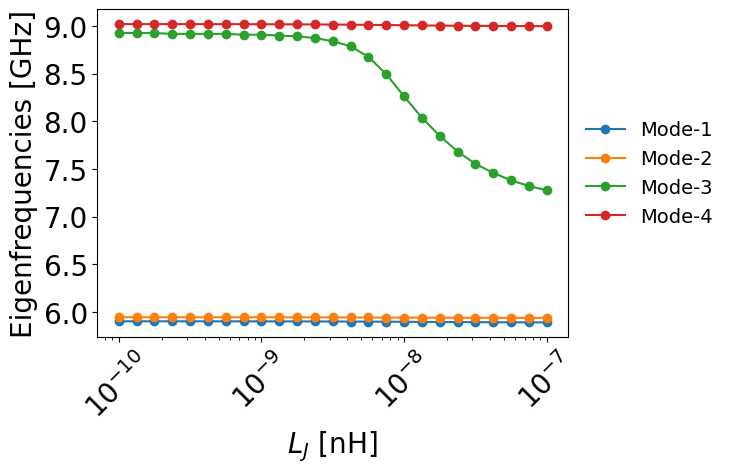

In [41]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
dstr = datetime.datetime.today().strftime('%y%m%d')
fsize = 20
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
Nmodes = 4
fscale=1e9
LJs = np.logspace(np.log10(0.1e-9), np.log10(100e-9), NLJ)
for k in range(Nmodes):
    ax.plot(LJs, wps1[k,:]/(2*np.pi*fscale),
            'o-', label=r'Mode-%d' % (k + 1),
            color=cycle[k%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
#ax.set_ylim([5.88, 5.95])
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, lsize)
ax.set_xscale('log')
fig.savefig(f'../figs/modes_wa_bbq_nondegen_{dstr}.pdf', 
            format='pdf', bbox_extra_artists=(leg, ), bbox_inches='tight',
           transparent=True)

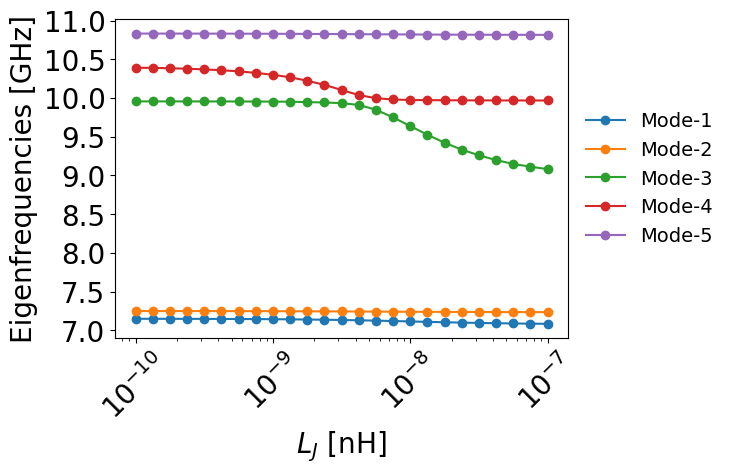

In [73]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
dstr = datetime.datetime.today().strftime('%y%m%d')
fsize = 20
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
Nmodes = 5
fscale=1e9
LJs = np.logspace(np.log10(0.1e-9), np.log10(100e-9), NLJ)
for k in range(Nmodes):
    ax.plot(LJs, wps2[k,:]/(2*np.pi*fscale),
            'o-', label=r'Mode-%d' % (k + 1),
            color=cycle[k%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
#ax.set_ylim([5.88, 5.95])
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, lsize)
ax.set_xscale('log')
fig.savefig(f'../figs/modes_wb_bbq_nondegen_{dstr}.pdf', 
            format='pdf', bbox_extra_artists=(leg, ), bbox_inches='tight',
           transparent=True)

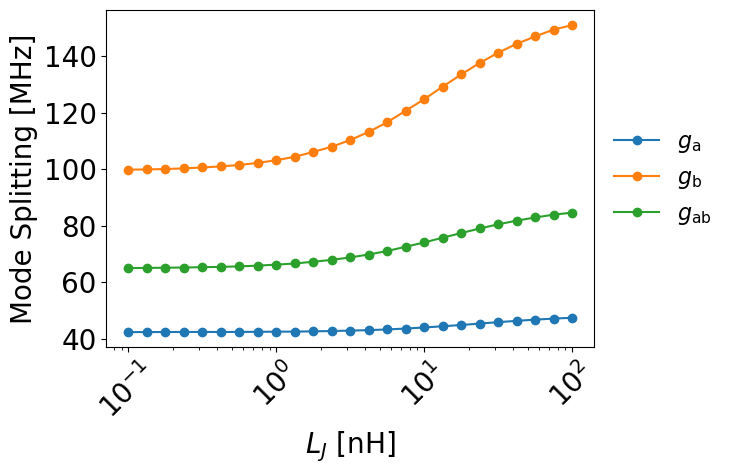

In [19]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fscale2 = 1e6
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
split1 = (wps1[1]-wps1[0])/(2*np.pi*fscale2)
split2 = (wps2[1]-wps2[0])/(2*np.pi*fscale2)
NLJ = 25
LJs = np.logspace(np.log10(0.1e-9), np.log10(100e-9), NLJ)
dstr = datetime.datetime.today().strftime('%y%m%d')
ax.plot(LJs/1e-9, split1,
           'o-',
            color=cycle[0],
           label=r'$g_{\mathrm{a}}$')
ax.plot(LJs/1e-9, split2,
           'o-',
            color=cycle[1],
           label=r'$g_{\mathrm{b}}$')
ax.plot(LJs/1e-9, np.sqrt(split1 * split2),
           'o-',
            color=cycle[2],
           label=r'$g_{\mathrm{ab}}$')
# ax.plot(LJs/1e-9, np.ones(LJs.size) * dw/(fscale2), 'k--')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Mode Splitting [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, 16)
#ax.set_ylim([0, 150])
#ax.set_xlim([0.5, 2.2])
ax.set_xscale('log')
fig.savefig(f'../figs/modes_ab_splitting_term_bbq_inductive_planar_sapphire_{dstr}.pdf',
            transparent=True,
            bbox_extra_artists=(leg, ), bbox_inches='tight',
            format='pdf')

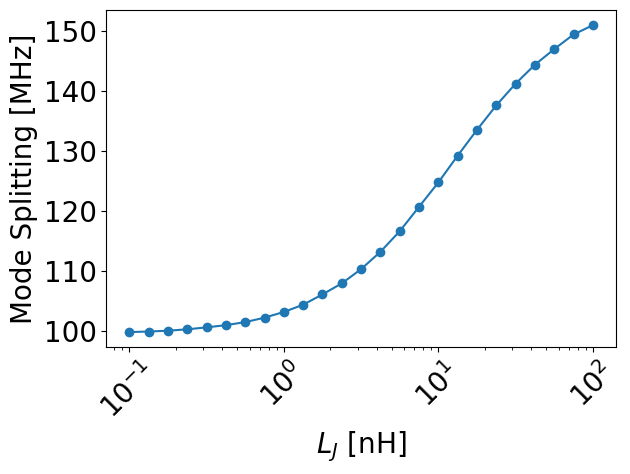

In [74]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fscale2 = 1e6
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
split1 = (wps1[1]-wps1[0])/(2*np.pi*fscale2)
split2 = (wps2[1]-wps2[0])/(2*np.pi*fscale2)
NLJ = 25
LJs = np.logspace(np.log10(0.1e-9), np.log10(100e-9), NLJ)
dstr = datetime.datetime.today().strftime('%y%m%d')
ax.plot(LJs/1e-9, split2,
           'o-',
            color=cycle[0])
           
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Mode Splitting [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
#ax.set_ylim([0, 150])
#ax.set_xlim([0.5, 2.2])
ax.set_xscale('log')
fig.savefig(f'../figs/modes_b_splitting_term_bbq_inductive_planar_sapphire_{dstr}.pdf',
            transparent=True,
            bbox_extra_artists=(leg, ), bbox_inches='tight',
            format='pdf')

In [ ]:
LJidx0 = 0
k1 = 1; k2 = 2

fig, ax = plt.subplots(1, 1, tight_layout=True)
dstr = datetime.datetime.today().strftime('%y%m%d')
fsize = 20
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
idx_start = 4
cidx = 0
for idx0 in [4, 8, 10, 12]: #16, 20, 22]: #, 11, 12, 19, 20, 22, 24]:
    gkk12 = np.array([gkk[f'kkp{k1}_{k2}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'] \
                               for idx in range(len(Lj_vals))])    
    ax.plot(Lj_vals, (gkk12) * 1e3,
        'o-', color=cycle[cidx%clen],
           label=r'$L_{J_0}$ = %.2f nH' % Lj_vals[idx0])
    cidx += 1
ax.plot(LJs/1e-9, np.sqrt(split1 * split2), ls='-.', lw=2,
        color='gray',
        label=r'$g_{ab}=\sqrt{g_{aa}g_{bb}}$')
ax.axhline(y=0, color='k', ls='--')
# ax.axhline(y=22, color='k', ls='--')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$g_{%d%d}$ [MHz]' % (k1, k2), fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
# ax.set_yscale('log')
leg = set_leg_outside(ax, lsize)
fig.savefig(f'../figs/g_bbq_1_10_100nH_remesh2_{dstr}.pdf', 
            bbox_extra_artists=(leg, ), bbox_inches='tight',
            format='pdf', transparent=True)